In [1]:
import jax
jax.config.update("jax_default_device",jax.devices()[1])
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import jit,grad,jacfwd,jacrev,vmap
import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm
plt.style.use("ggplot")

from importlib import reload
#import keql_tools
#reload(keql_tools)
#from keql_tools import *
from Kernels import *
from EquationModel import *
from jax.scipy.linalg import solve
from EquationModel import *
from GP_sampler import *
from plotting import *
from evaluation_metrics import *

import LM_Solve
import importlib
importlib.reload(LM_Solve)
from LM_Solve import LevenbergMarquadtMinimize

from LM_Solve import adaptive_refine_solution

/home/josorior/miniconda3/envs/myjaxenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Utils

In [2]:
## Utils
# Build interior and boundary grids
def build_xy_grid(x_range,y_range,num_grid_x,num_grid_y):
    full_x_grid = jnp.linspace(x_range[0],x_range[1],num_grid_x)
    full_y_grid = jnp.linspace(y_range[0],y_range[1],num_grid_y)

    x_interior = full_x_grid[1:-1]
    y_interior = full_y_grid[1:-1]
    
    x_boundary = full_x_grid[jnp.array([0,-1])]
    y_boundary = full_y_grid[jnp.array([0,-1])]

    #Get interior points
    x,y = jnp.meshgrid(x_interior,y_interior)
    xy_interior = jnp.vstack([x.flatten(),y.flatten()]).T

    #I'm doing this with meshgrid to handle more general higher dimensions, ie circular domain in 2d
    #Get boundary points
    x,y = jnp.meshgrid(x_interior,y_boundary)
    xy_boundary_1 = jnp.vstack([x.flatten(),y.flatten()]).T

    x,y = jnp.meshgrid(x_boundary,y_interior)
    xy_boundary_2 = jnp.vstack([x.flatten(),y.flatten()]).T

    x,y = jnp.meshgrid(x_boundary,y_boundary)
    xy_boundary_3 = jnp.vstack([x.flatten(),y.flatten()]).T

    xy_boundary = jnp.vstack([xy_boundary_1,xy_boundary_2,xy_boundary_3])
    return xy_interior,xy_boundary

In [3]:
def get_obs(num_obs, xy_int, xy_bdy,vmapped_u_true_functions, vmapped_rhs, seed):
    """
        Gets samples(functions) of GP. 

        Args:
            num_obs (list): List of integers of number of observed points per function.
            xy_int (jnp.array): Interior domain to get the sample.
            xy_bdy (jnp.array): Boundary domain.
            vmapped_u_true_functions (list): List of vmapped u true functions.
            vmapped_u_true_functions (list): List of vmapped f true functions.
            seed (int): Integer to fix the simulation.

        Returns:
            list: List of lists xy_obs, u_obs, f_obs.   
    """

    if len(num_obs) != len(vmapped_u_true_functions):
        raise Exception("len of list of provided observed points not same as len of list of provided functions.")
    
    num_f = len(vmapped_rhs)
    key = jax.random.PRNGKey(seed)
    seed = jax.random.randint(key=key, shape=(num_f,), minval=1, maxval=40)
    xy_obs, u_obs, f_obs =  [], [], []
    for i, num_ob in enumerate(num_obs):
        np.random.seed(seed[i])
        xy_sample_indsi = np.random.choice(list(np.arange(len(xy_int))),num_ob,replace = False)
        xy_obsi = jnp.vstack([xy_bdy,xy_int[xy_sample_indsi]])
        xy_obs.append(xy_obsi)
        u_obs.append(vmapped_u_true_functions[i](xy_obsi))
        f_obs.append(vmapped_rhs[i](xy_obsi))
    return xy_obs, u_obs, f_obs

In [4]:
# Build operator features
def diff_x_op(k,index):
    return get_selected_grad(k,index,0)

def diff_xx_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,0)

def diff_y_op(k,index):
    return get_selected_grad(k,index,1)

def diff_yy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,1),index,1)

def diff_xy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,1)

feature_operators = tuple([eval_k,diff_x_op,diff_xx_op,diff_y_op,diff_yy_op,diff_xy_op])

In [5]:
def run_exp(m, obs_pts,run):
    # Define grid to get samples from GP
    x_grid=jnp.linspace(0,1,25)
    y_grid=jnp.linspace(0,1,25)
    X,Y=jnp.meshgrid(x_grid,y_grid)
    pairs = jnp.vstack([X.ravel(), Y.ravel()]).T

    # Sample m training functions from a GP
    kernel_GP = get_gaussianRBF(0.5)
    u_true_functions = tuple(GP_sampler(num_samples = m,
                                            X = pairs, 
                                            kernel = kernel_GP,
                                            reg = 1e-12,
                                            seed = run
                                        )  
                                        )

    # Permeability field A
    def A(xy):
        x = xy[0]
        y = xy[1]
        return jnp.exp(2*(jnp.sin(jnp.cos(2*x) + jnp.cos(2*y))))

    # Compute f = Pu for any u
    def get_rhs_darcy(u):
        def Agradu(xy):
            return A(xy)*jax.grad(u)(xy)
        def Pu(xy):
            return jnp.trace(jax.jacfwd(Agradu)(xy))
        return Pu

    # Lists of m true u's and f's
    vmapped_u_true_functions = tuple([jax.vmap(u) for u in u_true_functions]) # vmap'ed
    rhs_functions = tuple([jax.vmap(get_rhs_darcy(u)) for u in u_true_functions]) #vmap'ed

    # Define the num of ghost points for each u
    num_grid_points = 8
    # Ghost grid - Same per function
    xy_int,xy_bdy = build_xy_grid([0,1],[0,1],num_grid_points,num_grid_points)
    xy_all = jnp.vstack([xy_bdy,xy_int])

    # Number of observed points per u
    num_obs = [obs_pts]*m

    xy_obs, u_obs, f_obs = get_obs(num_obs, xy_int, xy_bdy,vmapped_u_true_functions, rhs_functions, seed=2024)

    # Build interpolants for u's
    k_u = get_gaussianRBF(0.5)
    u_models = tuple([InducedRKHS(
        xy_all,
        feature_operators,
        k_u
        ) for i in range(m)])
    
    # Get necessary tuples
    observation_points = tuple(xy_obs)
    observation_values = tuple(u_obs)
    collocation_points = (xy_int,)*m

    rhs_values = tuple(rhs_func(xy_int) for rhs_func in rhs_functions)

    all_u_params_init = tuple([model.get_fitted_params(obs_loc,obs_val) for obs_loc,obs_val,model in zip(observation_points,observation_values,u_models)])

    grid_features_u_init = jnp.vstack([(model.evaluate_operators(feature_operators,xy_int,model_params)).reshape(
                len(xy_int),
                len(feature_operators),
                order = 'F'
            ) for model,model_params in zip(u_models,all_u_params_init) ])


    k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_u_init,c=1)
    k_P_x_part = get_gaussianRBF(0.4)
    def k_P(x,y):
        return k_P_x_part(x[:2],y[:2]) * k_P_u_part(x[2:],y[2:])
    

    class P_model():

        kernel_function = jit(
            get_kernel_block_ops(k_P,[eval_k],[eval_k])
        )

        num_params = len(grid_features_u_init)

        @jit
        def predict(input_data,params):
            K = P_model.kernel_function(input_data,input_data)
            return K@params
        
        def get_P_eval(input_data,params):
            def predict(prediction_points):
                K = P_model.kernel_function(prediction_points,input_data)
                return K@params
            return predict
        
    collocation_points = tuple([xy_int]*m)
    
    EqnModel  = OperatorPDEModel(
        P_model,
        u_models,
        observation_points,
        observation_values,
        collocation_points,
        feature_operators,
        rhs_values,
        datafit_weight = 5.,
    )

    params_init = jnp.hstack(list(all_u_params_init)+[jnp.zeros(m*len(xy_int))])

    params,loss_vals,JtRes,improvement_ratios,alpha_vals,iterate_history = LevenbergMarquadtMinimize(
        params_init.copy(),
        EqnModel,
        beta = 1e-8,
        max_iter = 501,
        init_alpha=3,
        line_search_increase_ratio=2.
    )

    p_adjusted,refinement_losses,reg_sequence = adaptive_refine_solution(params,EqnModel,1e-1,500)

    u_sols = EqnModel.get_u_params(p_adjusted)
    P_sol = EqnModel.get_P_params(p_adjusted)

    # Testing grid
    num_fine_grid = 50
    x_fine,y_fine = np.meshgrid(np.linspace(0,1,num_fine_grid+4)[2:-2],np.linspace(0,1,num_fine_grid+4)[2:-2])
    xy_fine_int = np.vstack([x_fine.flatten(),y_fine.flatten()]).T

    # Estimated P from 1.5 step method
    model_grid_features_all = EqnModel.get_stacked_eqn_features(u_sols)    
    S_train = model_grid_features_all
    P_func = P_model.get_P_eval(S_train,P_sol)

    # Estimated P from 2 step method
    init_P_features = EqnModel.get_stacked_eqn_features(all_u_params_init)
    S_train_2 = init_P_features 
    K = P_model.kernel_function(S_train_2,S_train_2)
    P_params_naive = solve(K+1e-5*diagpart(K),EqnModel.stacked_collocation_rhs)
    P_func2 = P_model.get_P_eval(S_train_2,P_params_naive)

    # P[\phi(w)](fine_grid)
    def evaluate_hatP(P_func, w, fine_grid, feature_operators):

        # Build S_test
        w_features = jnp.array([jax.vmap(operator(w,0))(xy_fine_int) for operator in feature_operators]).T
        model_fine_features = jnp.hstack([fine_grid, w_features])
        S_test = model_fine_features


        #P_preds_model_features = P_model.kernel_function(S_test,S_train)@P_sol 
        P_preds = P_func(S_test)
        return P_preds
    
    ########### Errors ################
    
    # In sample

    # Get list of approximated functions ^U = [^u_1, ^u_2, ^u_3]
    true = [f(xy_fine_int) for f in rhs_functions]

    u_approx_funcs = [u_models[ind].get_eval_function(u_sols[ind]) 
                    for ind in range(m)]
    pred1_5 = [
        evaluate_hatP(
        P_func,
        u, xy_fine_int,feature_operators) for u in u_approx_funcs
    ]

    twostep_u_approx_funcs = [u_models[ind].get_eval_function(all_u_params_init[ind]) 
                    for ind in range(m)]
    pred2 = [
        evaluate_hatP(
        P_func2,
        u, xy_fine_int,feature_operators) for u in twostep_u_approx_funcs
    ]
    i_smpl_1_5 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred1_5)])) # RMSE
    i_smpl_2 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred2)]))



    # In distribution

    M = 50
    kernel_GP = get_gaussianRBF(0.5)
    # Sample M training functions from GP(0,K)
    w_train_functions = GP_sampler(num_samples = M,
                    X = pairs, 
                    kernel = kernel_GP,
                    reg = 1e-12,
                    seed = run
                    )
    vmapped_w_train_functions = tuple([jax.vmap(w) for w in w_train_functions]) # vmap'ed
    w_rhs_functions = tuple([jax.vmap(get_rhs_darcy(w)) for w in w_train_functions]) #vmap'ed

    # mean 
    true = [f_w(xy_fine_int) for f_w in w_rhs_functions]
    #pred = [evaluate_hatP(w, xy_fine_int, u_sols, P_sol,feature_operators) for w in w_test_functions]
    pred1_5 = [
        evaluate_hatP(
        lambda x:P_model.kernel_function(x,S_train)@P_sol,
        w, xy_fine_int,feature_operators) for w in w_train_functions
    ]

    pred2 = [
        evaluate_hatP(
        P_func2,
        u, xy_fine_int,feature_operators) for u in w_train_functions
    ]

    i_dis_1_5 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred1_5)]))
    i_dis_2 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred2)]))


    

    # Out of sample
    M = 50
    kernel_GP = get_gaussianRBF(0.2)
    # Sample M test functions from GP(0,K)
    w_test_functions = GP_sampler(num_samples = M,
                    X = pairs, 
                    kernel = kernel_GP,
                    reg = 1e-12,
                    seed = run
                    )
    vmapped_w_test_functions = tuple([jax.vmap(w) for w in w_test_functions]) # vmap'ed
    w_rhs_functions = tuple([jax.vmap(get_rhs_darcy(w)) for w in w_test_functions]) #vmap'ed

    # mean 
    true = [f_w(xy_fine_int) for f_w in w_rhs_functions]
    #pred = [evaluate_hatP(w, xy_fine_int, u_sols, P_sol,feature_operators) for w in w_test_functions]
    pred1_5 = [
        evaluate_hatP(
        lambda x:P_model.kernel_function(x,S_train)@P_sol,
        w, xy_fine_int,feature_operators) for w in w_test_functions
    ]

    pred2 = [
        evaluate_hatP(
        P_func2,
        u, xy_fine_int,feature_operators) for u in w_test_functions
    ]

    o_dis_1_5 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred1_5)]))
    o_dis_2 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred2)]))

    return i_dis_1_5, i_dis_2, o_dis_1_5, o_dis_2, i_smpl_1_5, i_smpl_2

## Structure to store the errors

We create a dictionary called `err` to store errors (nrmse) where we denote the keys as follows:

>  `1_5_mthd`: This is the main algorithm.

>  `2_obs`: This means that its parent method was trained using the observed functions at 2 points.

>  `i_dis`: List of list which contains the errors for P at the training functions.

>  `o_dis`: List of list which contains the errors for P at the testing functions.

In [6]:
err = {
    '1_5_mthd': {
        '2_obs': {'i_dis': [],'o_dis': [], 'i_smpl' : []},
        '4_obs': {'i_dis': [],'o_dis': [], 'i_smpl' : []},
        '8_obs': {'i_dis': [],'o_dis': [], 'i_smpl' : []}
                  },
    '2_mthd':   {
        '2_obs': {'i_dis': [],'o_dis': [], 'i_smpl' : []},
        '4_obs': {'i_dis': [],'o_dis': [], 'i_smpl' : []},
        '8_obs': {'i_dis': [],'o_dis': [], 'i_smpl' : []}
                }
}

In [7]:
NUM_FUN_LIST = [2,4,8,16]
NUM_RUNS = 10
OBS_PTS_LIST = [2,4,8]

for obs_pt in OBS_PTS_LIST:
    for m in NUM_FUN_LIST:
        i_dis_1_5 = []
        i_dis_2 = []
        o_dis_1_5 = []
        o_dis_2 = []
        i_smpl_1_5 = []
        i_smpl_2 = []
        for run in range(NUM_RUNS):
            # Run
            res = run_exp(m, obs_pt, run)
            # Append
            i_dis_1_5.append(res[0])
            i_dis_2.append(res[1])
            o_dis_1_5.append(res[2])
            o_dis_2.append(res[3])
            i_smpl_1_5.append(res[4])
            i_smpl_2.append(res[5])
        # Append each list    
        err['1_5_mthd'][f'{obs_pt}_obs']['i_dis'].append(i_dis_1_5)
        err['2_mthd'][f'{obs_pt}_obs']['i_dis'].append(i_dis_2)
        err['1_5_mthd'][f'{obs_pt}_obs']['o_dis'].append(o_dis_1_5)
        err['2_mthd'][f'{obs_pt}_obs']['o_dis'].append(o_dis_2)
        err['1_5_mthd'][f'{obs_pt}_obs']['i_smpl'].append(i_smpl_1_5)
        err['2_mthd'][f'{obs_pt}_obs']['i_smpl'].append(i_smpl_2)    
    # Save after 
    jnp.save('errors/err', err)

  2%|▏         | 12/501 [00:00<00:13, 36.78it/s]

Iteration 0, loss = 1.675e+03, Jres = 570.0, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.168e+03, Jres = 1.496e+04, alpha = 20.0, improvement_ratio = 0.4149
Iteration 2, loss = 205.1, Jres = 4.147e+04, alpha = 16.67, improvement_ratio = 0.9778
Iteration 3, loss = 112.3, Jres = 4.541e+03, alpha = 13.89, improvement_ratio = 1.017
Iteration 4, loss = 78.55, Jres = 993.9, alpha = 11.57, improvement_ratio = 1.005
Iteration 5, loss = 60.39, Jres = 562.3, alpha = 9.645, improvement_ratio = 0.9971


 15%|█▌        | 77/501 [00:00<00:02, 154.89it/s]

Iteration 50, loss = 0.09842, Jres = 7.098, alpha = 0.002637, improvement_ratio = 0.9872


 29%|██▊       | 144/501 [00:01<00:01, 197.75it/s]

Iteration 100, loss = 0.002449, Jres = 5.913, alpha = 0.0001426, improvement_ratio = 0.6718


 38%|███▊      | 188/501 [00:01<00:01, 207.34it/s]

Iteration 150, loss = 0.0003773, Jres = 2.678, alpha = 4.777e-05, improvement_ratio = 0.6736


 46%|████▋     | 232/501 [00:01<00:01, 211.02it/s]

Iteration 200, loss = 0.0001221, Jres = 1.071, alpha = 1.333e-05, improvement_ratio = 0.7752


 55%|█████▌    | 276/501 [00:01<00:01, 211.00it/s]

Iteration 250, loss = 7.951e-05, Jres = 0.4732, alpha = 6.429e-06, improvement_ratio = 0.8026


 68%|██████▊   | 342/501 [00:01<00:00, 210.14it/s]

Iteration 300, loss = 6.597e-05, Jres = 0.2405, alpha = 3.721e-06, improvement_ratio = 0.7894


 77%|███████▋  | 387/501 [00:02<00:00, 214.36it/s]

Iteration 350, loss = 6.103e-05, Jres = 0.2246, alpha = 2.153e-06, improvement_ratio = 0.7443


 86%|████████▋ | 433/501 [00:02<00:00, 217.85it/s]

Iteration 400, loss = 5.917e-05, Jres = 0.2212, alpha = 1.794e-06, improvement_ratio = 0.7282


 95%|█████████▌| 478/501 [00:02<00:00, 219.07it/s]

Iteration 450, loss = 5.85e-05, Jres = 0.151, alpha = 1.495e-06, improvement_ratio = 0.6466


100%|██████████| 501/501 [00:02<00:00, 187.12it/s]


Iteration 500, loss = 5.836e-05, Jres = 0.1324, alpha = 1.495e-06, improvement_ratio = 0.7974


  8%|▊         | 42/501 [00:00<00:02, 207.52it/s]

Iteration 0, loss = 1.323e+03, Jres = 549.1, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.136e+03, Jres = 1.691e+04, alpha = 24.0, improvement_ratio = 0.1777
Iteration 2, loss = 136.9, Jres = 5.672e+04, alpha = 16.67, improvement_ratio = 0.9707
Iteration 3, loss = 76.34, Jres = 6.084e+03, alpha = 13.89, improvement_ratio = 0.9961
Iteration 4, loss = 52.55, Jres = 659.8, alpha = 11.57, improvement_ratio = 1.005
Iteration 5, loss = 38.41, Jres = 320.1, alpha = 9.645, improvement_ratio = 1.0


 17%|█▋        | 87/501 [00:00<00:01, 216.49it/s]

Iteration 50, loss = 0.0548, Jres = 13.34, alpha = 0.002637, improvement_ratio = 0.957


 26%|██▋       | 132/501 [00:00<00:01, 218.64it/s]

Iteration 100, loss = 0.001331, Jres = 6.018, alpha = 8.255e-05, improvement_ratio = 0.8108


 36%|███▌      | 178/501 [00:00<00:01, 220.26it/s]

Iteration 150, loss = 0.0002367, Jres = 2.015, alpha = 2.304e-05, improvement_ratio = 0.7541


 45%|████▍     | 224/501 [00:01<00:01, 219.84it/s]

Iteration 200, loss = 0.0001228, Jres = 0.9393, alpha = 1.6e-05, improvement_ratio = 0.7884


 58%|█████▊    | 293/501 [00:01<00:00, 220.07it/s]

Iteration 250, loss = 8.617e-05, Jres = 0.7207, alpha = 1.111e-05, improvement_ratio = 0.7681


 67%|██████▋   | 338/501 [00:01<00:00, 214.25it/s]

Iteration 300, loss = 6.917e-05, Jres = 0.5177, alpha = 7.715e-06, improvement_ratio = 0.7703


 76%|███████▌  | 382/501 [00:01<00:00, 210.54it/s]

Iteration 350, loss = 6.062e-05, Jres = 0.329, alpha = 4.465e-06, improvement_ratio = 0.8025


 85%|████████▌ | 427/501 [00:01<00:00, 215.78it/s]

Iteration 400, loss = 5.619e-05, Jres = 0.2534, alpha = 2.584e-06, improvement_ratio = 0.8022


 99%|█████████▉| 496/501 [00:02<00:00, 221.54it/s]

Iteration 450, loss = 5.373e-05, Jres = 0.1788, alpha = 1.794e-06, improvement_ratio = 0.8


100%|██████████| 501/501 [00:02<00:00, 217.29it/s]


Iteration 500, loss = 5.217e-05, Jres = 0.1358, alpha = 1.794e-06, improvement_ratio = 0.7487


  9%|▊         | 43/501 [00:00<00:02, 214.35it/s]

Iteration 0, loss = 829.2, Jres = 603.7, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 635.2, Jres = 1.302e+04, alpha = 5.0, improvement_ratio = 0.275
Iteration 2, loss = 47.54, Jres = 3.281e+04, alpha = 4.167, improvement_ratio = 0.9713
Iteration 3, loss = 21.49, Jres = 3.541e+03, alpha = 3.472, improvement_ratio = 0.9939
Iteration 4, loss = 14.66, Jres = 273.1, alpha = 2.894, improvement_ratio = 1.011
Iteration 5, loss = 10.47, Jres = 71.62, alpha = 2.411, improvement_ratio = 1.009


 18%|█▊        | 89/501 [00:00<00:01, 223.51it/s]

Iteration 50, loss = 0.01432, Jres = 18.94, alpha = 0.0009494, improvement_ratio = 0.7801


 27%|██▋       | 135/501 [00:00<00:01, 221.82it/s]

Iteration 100, loss = 0.0006616, Jres = 3.771, alpha = 8.874e-05, improvement_ratio = 0.7793


 36%|███▌      | 181/501 [00:00<00:01, 221.21it/s]

Iteration 150, loss = 9.834e-05, Jres = 0.8261, alpha = 2.972e-05, improvement_ratio = 0.791


 45%|████▌     | 227/501 [00:01<00:01, 221.19it/s]

Iteration 200, loss = 5.915e-05, Jres = 0.3891, alpha = 1.433e-05, improvement_ratio = 0.7864


 54%|█████▍    | 273/501 [00:01<00:01, 221.29it/s]

Iteration 250, loss = 4.431e-05, Jres = 0.3212, alpha = 6.911e-06, improvement_ratio = 0.7783


 68%|██████▊   | 342/501 [00:01<00:00, 221.79it/s]

Iteration 300, loss = 3.679e-05, Jres = 0.2718, alpha = 4.799e-06, improvement_ratio = 0.7642


 77%|███████▋  | 388/501 [00:01<00:00, 221.70it/s]

Iteration 350, loss = 3.328e-05, Jres = 0.2197, alpha = 2.777e-06, improvement_ratio = 0.7376


 87%|████████▋ | 434/501 [00:01<00:00, 221.75it/s]

Iteration 400, loss = 3.219e-05, Jres = 0.1051, alpha = 1.607e-06, improvement_ratio = 0.6531


 96%|█████████▌| 480/501 [00:02<00:00, 221.58it/s]

Iteration 450, loss = 3.196e-05, Jres = 0.08956, alpha = 1.116e-06, improvement_ratio = 0.7596


100%|██████████| 501/501 [00:02<00:00, 221.22it/s]


Iteration 500, loss = 3.191e-05, Jres = 0.03817, alpha = 8.333e-07, improvement_ratio = 0.8657


  9%|▊         | 43/501 [00:00<00:02, 213.05it/s]

Iteration 0, loss = 2.191e+03, Jres = 896.3, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.667e+03, Jres = 2.692e+04, alpha = 5.0, improvement_ratio = 0.259
Iteration 2, loss = 64.42, Jres = 7.034e+04, alpha = 4.167, improvement_ratio = 0.9742
Iteration 3, loss = 15.95, Jres = 8.119e+03, alpha = 3.472, improvement_ratio = 0.9928
Iteration 4, loss = 11.42, Jres = 442.3, alpha = 2.894, improvement_ratio = 1.005
Iteration 5, loss = 8.863, Jres = 67.78, alpha = 2.411, improvement_ratio = 1.006


 18%|█▊        | 89/501 [00:00<00:01, 219.21it/s]

Iteration 50, loss = 0.02822, Jres = 10.9, alpha = 0.0007912, improvement_ratio = 0.8187


 27%|██▋       | 134/501 [00:00<00:01, 218.58it/s]

Iteration 100, loss = 0.001341, Jres = 6.764, alpha = 6.162e-05, improvement_ratio = 0.7445


 36%|███▌      | 180/501 [00:00<00:01, 220.66it/s]

Iteration 150, loss = 0.0003428, Jres = 3.256, alpha = 2.064e-05, improvement_ratio = 0.7358


 45%|████▌     | 226/501 [00:01<00:01, 220.52it/s]

Iteration 200, loss = 0.0001805, Jres = 1.61, alpha = 1.433e-05, improvement_ratio = 0.7739


 58%|█████▊    | 293/501 [00:01<00:00, 218.65it/s]

Iteration 250, loss = 0.0001243, Jres = 1.192, alpha = 9.952e-06, improvement_ratio = 0.7736


 67%|██████▋   | 338/501 [00:01<00:00, 218.86it/s]

Iteration 300, loss = 9.653e-05, Jres = 1.014, alpha = 6.911e-06, improvement_ratio = 0.7111


 76%|███████▋  | 383/501 [00:01<00:00, 219.57it/s]

Iteration 350, loss = 8.327e-05, Jres = 0.4884, alpha = 5.759e-06, improvement_ratio = 0.7801


 85%|████████▌ | 428/501 [00:01<00:00, 219.62it/s]

Iteration 400, loss = 7.763e-05, Jres = 0.3117, alpha = 4e-06, improvement_ratio = 0.7844


 94%|█████████▍| 473/501 [00:02<00:00, 219.80it/s]

Iteration 450, loss = 7.507e-05, Jres = 0.2984, alpha = 2.777e-06, improvement_ratio = 0.7384


100%|██████████| 501/501 [00:02<00:00, 218.78it/s]


Iteration 500, loss = 7.38e-05, Jres = 0.2397, alpha = 2.315e-06, improvement_ratio = 0.7574


  9%|▊         | 43/501 [00:00<00:02, 212.41it/s]

Iteration 0, loss = 1.39e+03, Jres = 953.0, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 639.5, Jres = 3.063e+04, alpha = 2.5, improvement_ratio = 0.5612
Iteration 2, loss = 30.21, Jres = 4.965e+04, alpha = 2.083, improvement_ratio = 0.9763
Iteration 3, loss = 11.98, Jres = 5.64e+03, alpha = 1.736, improvement_ratio = 0.9967
Iteration 4, loss = 9.265, Jres = 331.3, alpha = 1.447, improvement_ratio = 1.01
Iteration 5, loss = 7.695, Jres = 64.64, alpha = 1.206, improvement_ratio = 1.01


 18%|█▊        | 88/501 [00:00<00:01, 217.59it/s]

Iteration 50, loss = 0.01648, Jres = 43.08, alpha = 0.0005696, improvement_ratio = 0.7954


 26%|██▋       | 132/501 [00:00<00:01, 218.05it/s]

Iteration 100, loss = 0.0006002, Jres = 5.411, alpha = 5.324e-05, improvement_ratio = 0.675


 35%|███▌      | 177/501 [00:00<00:01, 218.75it/s]

Iteration 150, loss = 0.0002681, Jres = 2.441, alpha = 1.486e-05, improvement_ratio = 0.7325


 49%|████▊     | 244/501 [00:01<00:01, 219.46it/s]

Iteration 200, loss = 0.0001836, Jres = 2.182, alpha = 1.238e-05, improvement_ratio = 0.7349


 58%|█████▊    | 289/501 [00:01<00:00, 219.68it/s]

Iteration 250, loss = 0.0001119, Jres = 2.104, alpha = 8.599e-06, improvement_ratio = 0.7465


 66%|██████▋   | 333/501 [00:01<00:00, 216.83it/s]

Iteration 300, loss = 7.112e-05, Jres = 1.192, alpha = 4.976e-06, improvement_ratio = 0.7739


 75%|███████▌  | 377/501 [00:01<00:00, 216.70it/s]

Iteration 350, loss = 5.873e-05, Jres = 0.5245, alpha = 2.4e-06, improvement_ratio = 0.7993


 89%|████████▉ | 445/501 [00:02<00:00, 219.22it/s]

Iteration 400, loss = 5.463e-05, Jres = 0.4105, alpha = 1.157e-06, improvement_ratio = 0.7338


 98%|█████████▊| 490/501 [00:02<00:00, 218.25it/s]

Iteration 450, loss = 5.284e-05, Jres = 0.2154, alpha = 1e-06, improvement_ratio = 0.7959


100%|██████████| 501/501 [00:02<00:00, 217.70it/s]


Iteration 500, loss = 5.204e-05, Jres = 0.111, alpha = 8.333e-07, improvement_ratio = 0.8677


  8%|▊         | 42/501 [00:00<00:02, 207.94it/s]

Iteration 0, loss = 927.9, Jres = 528.8, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 740.7, Jres = 1.646e+04, alpha = 2.5, improvement_ratio = 0.2253
Iteration 2, loss = 38.49, Jres = 4.311e+04, alpha = 2.083, improvement_ratio = 0.9745
Iteration 3, loss = 15.51, Jres = 4.602e+03, alpha = 1.736, improvement_ratio = 0.9953
Iteration 4, loss = 11.45, Jres = 306.1, alpha = 1.447, improvement_ratio = 1.017
Iteration 5, loss = 8.981, Jres = 69.83, alpha = 1.206, improvement_ratio = 1.013


 17%|█▋        | 85/501 [00:00<00:01, 210.46it/s]

Iteration 50, loss = 0.01107, Jres = 23.62, alpha = 0.0005696, improvement_ratio = 0.7808


 26%|██▌       | 129/501 [00:00<00:01, 214.18it/s]

Iteration 100, loss = 0.001035, Jres = 6.452, alpha = 9.2e-05, improvement_ratio = 0.779


 35%|███▍      | 173/501 [00:00<00:01, 216.36it/s]

Iteration 150, loss = 0.0001517, Jres = 1.784, alpha = 2.14e-05, improvement_ratio = 0.7376


 48%|████▊     | 240/501 [00:01<00:01, 215.47it/s]

Iteration 200, loss = 7.262e-05, Jres = 0.9681, alpha = 1.032e-05, improvement_ratio = 0.7502


 57%|█████▋    | 284/501 [00:01<00:01, 213.07it/s]

Iteration 250, loss = 5.004e-05, Jres = 0.5964, alpha = 5.971e-06, improvement_ratio = 0.7269


 65%|██████▌   | 328/501 [00:01<00:00, 214.04it/s]

Iteration 300, loss = 4.245e-05, Jres = 0.2667, alpha = 4.147e-06, improvement_ratio = 0.7977


 75%|███████▍  | 374/501 [00:01<00:00, 217.65it/s]

Iteration 350, loss = 3.949e-05, Jres = 0.2688, alpha = 2.4e-06, improvement_ratio = 0.7131


 88%|████████▊ | 443/501 [00:02<00:00, 220.61it/s]

Iteration 400, loss = 3.82e-05, Jres = 0.1652, alpha = 2.4e-06, improvement_ratio = 0.7357


 98%|█████████▊| 489/501 [00:02<00:00, 221.31it/s]

Iteration 450, loss = 3.764e-05, Jres = 0.1294, alpha = 2.4e-06, improvement_ratio = 0.7311


100%|██████████| 501/501 [00:02<00:00, 216.25it/s]


Iteration 500, loss = 3.733e-05, Jres = 0.1023, alpha = 2.4e-06, improvement_ratio = 0.7448


  8%|▊         | 39/501 [00:00<00:02, 196.95it/s]

Iteration 0, loss = 780.0, Jres = 420.2, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 531.5, Jres = 1.552e+04, alpha = 40.0, improvement_ratio = 0.4338
Iteration 2, loss = 71.62, Jres = 4.194e+04, alpha = 16.67, improvement_ratio = 0.9616
Iteration 3, loss = 35.02, Jres = 5.147e+03, alpha = 13.89, improvement_ratio = 1.001
Iteration 4, loss = 24.28, Jres = 714.2, alpha = 11.57, improvement_ratio = 1.018
Iteration 5, loss = 18.46, Jres = 250.4, alpha = 9.645, improvement_ratio = 1.015


 17%|█▋        | 83/501 [00:00<00:02, 207.97it/s]

Iteration 50, loss = 0.03613, Jres = 10.79, alpha = 0.002637, improvement_ratio = 0.9662


 25%|██▍       | 125/501 [00:00<00:01, 205.82it/s]

Iteration 100, loss = 0.001877, Jres = 13.06, alpha = 0.0001712, improvement_ratio = 0.6899


 38%|███▊      | 188/501 [00:00<00:01, 204.29it/s]

Iteration 150, loss = 0.0002361, Jres = 5.544, alpha = 3.317e-05, improvement_ratio = 0.6925


 46%|████▌     | 230/501 [00:01<00:01, 205.30it/s]

Iteration 200, loss = 8.516e-05, Jres = 2.514, alpha = 1.333e-05, improvement_ratio = 0.7164


 55%|█████▌    | 276/501 [00:01<00:01, 213.38it/s]

Iteration 250, loss = 5.663e-05, Jres = 1.493, alpha = 7.715e-06, improvement_ratio = 0.724


 69%|██████▉   | 345/501 [00:01<00:00, 218.18it/s]

Iteration 300, loss = 4.529e-05, Jres = 1.051, alpha = 5.358e-06, improvement_ratio = 0.7111


 78%|███████▊  | 390/501 [00:01<00:00, 219.23it/s]

Iteration 350, loss = 3.906e-05, Jres = 0.6389, alpha = 3.721e-06, improvement_ratio = 0.6518


 87%|████████▋ | 435/501 [00:02<00:00, 219.51it/s]

Iteration 400, loss = 3.53e-05, Jres = 0.6598, alpha = 2.584e-06, improvement_ratio = 0.754


 96%|█████████▌| 479/501 [00:02<00:00, 219.02it/s]

Iteration 450, loss = 3.34e-05, Jres = 0.4715, alpha = 1.794e-06, improvement_ratio = 0.7562


100%|██████████| 501/501 [00:02<00:00, 212.24it/s]


Iteration 500, loss = 3.256e-05, Jres = 0.3161, alpha = 1.794e-06, improvement_ratio = 0.7637


  4%|▍         | 19/501 [00:00<00:02, 182.94it/s]

Iteration 0, loss = 1.213e+03, Jres = 650.3, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 650.1, Jres = 1.746e+04, alpha = 20.0, improvement_ratio = 0.5566
Iteration 2, loss = 86.65, Jres = 3.756e+04, alpha = 16.67, improvement_ratio = 0.9566
Iteration 3, loss = 50.05, Jres = 5.083e+03, alpha = 13.89, improvement_ratio = 0.9708
Iteration 4, loss = 38.87, Jres = 776.4, alpha = 11.57, improvement_ratio = 0.9979
Iteration 5, loss = 32.21, Jres = 249.2, alpha = 9.645, improvement_ratio = 1.004


 17%|█▋        | 86/501 [00:00<00:01, 212.85it/s]

Iteration 50, loss = 0.03681, Jres = 6.521, alpha = 0.002637, improvement_ratio = 0.9384


 26%|██▌       | 130/501 [00:00<00:01, 216.38it/s]

Iteration 100, loss = 0.0008434, Jres = 6.21, alpha = 9.906e-05, improvement_ratio = 0.7568


 35%|███▍      | 174/501 [00:00<00:01, 212.43it/s]

Iteration 150, loss = 0.0001812, Jres = 1.613, alpha = 2.765e-05, improvement_ratio = 0.6729


 48%|████▊     | 240/501 [00:01<00:01, 211.09it/s]

Iteration 200, loss = 8.782e-05, Jres = 0.9969, alpha = 9.258e-06, improvement_ratio = 0.6637


 57%|█████▋    | 284/501 [00:01<00:01, 212.67it/s]

Iteration 250, loss = 5.458e-05, Jres = 0.669, alpha = 5.358e-06, improvement_ratio = 0.751


 65%|██████▌   | 328/501 [00:01<00:00, 214.50it/s]

Iteration 300, loss = 4.483e-05, Jres = 0.3281, alpha = 3.101e-06, improvement_ratio = 0.7419


 79%|███████▉  | 395/501 [00:01<00:00, 218.26it/s]

Iteration 350, loss = 4.134e-05, Jres = 0.181, alpha = 2.153e-06, improvement_ratio = 0.7737


 88%|████████▊ | 439/501 [00:02<00:00, 218.57it/s]

Iteration 400, loss = 3.996e-05, Jres = 0.1379, alpha = 1.495e-06, improvement_ratio = 0.7279


 96%|█████████▋| 483/501 [00:02<00:00, 216.13it/s]

Iteration 450, loss = 3.943e-05, Jres = 0.08898, alpha = 1.246e-06, improvement_ratio = 0.768


100%|██████████| 501/501 [00:02<00:00, 213.60it/s]


Iteration 500, loss = 3.925e-05, Jres = 0.06409, alpha = 1e-06, improvement_ratio = 0.7872


  9%|▊         | 43/501 [00:00<00:02, 210.47it/s]

Iteration 0, loss = 629.3, Jres = 358.3, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 541.7, Jres = 9.143e+03, alpha = 3.0, improvement_ratio = 0.1613
Iteration 2, loss = 40.05, Jres = 2.711e+04, alpha = 2.5, improvement_ratio = 0.9695
Iteration 3, loss = 19.23, Jres = 2.907e+03, alpha = 2.083, improvement_ratio = 0.9925
Iteration 4, loss = 12.72, Jres = 153.6, alpha = 1.736, improvement_ratio = 1.042
Iteration 5, loss = 9.111, Jres = 64.55, alpha = 1.447, improvement_ratio = 1.034


 17%|█▋        | 87/501 [00:00<00:01, 214.36it/s]

Iteration 50, loss = 0.008428, Jres = 17.15, alpha = 0.0005696, improvement_ratio = 0.816


 26%|██▌       | 131/501 [00:00<00:01, 214.48it/s]

Iteration 100, loss = 0.0005648, Jres = 4.403, alpha = 7.667e-05, improvement_ratio = 0.7451


 35%|███▍      | 175/501 [00:00<00:01, 213.72it/s]

Iteration 150, loss = 7.603e-05, Jres = 0.9377, alpha = 1.783e-05, improvement_ratio = 0.8042


 48%|████▊     | 241/501 [00:01<00:01, 214.10it/s]

Iteration 200, loss = 4.552e-05, Jres = 0.4345, alpha = 7.166e-06, improvement_ratio = 0.6663


 57%|█████▋    | 285/501 [00:01<00:01, 214.08it/s]

Iteration 250, loss = 3.472e-05, Jres = 0.3777, alpha = 3.456e-06, improvement_ratio = 0.7572


 66%|██████▌   | 329/501 [00:01<00:00, 214.22it/s]

Iteration 300, loss = 3.061e-05, Jres = 0.2265, alpha = 2e-06, improvement_ratio = 0.7514


 74%|███████▍  | 373/501 [00:01<00:00, 215.80it/s]

Iteration 350, loss = 2.937e-05, Jres = 0.1269, alpha = 1.666e-06, improvement_ratio = 0.7833


 88%|████████▊ | 439/501 [00:02<00:00, 215.50it/s]

Iteration 400, loss = 2.89e-05, Jres = 0.1308, alpha = 1.157e-06, improvement_ratio = 0.7084


 96%|█████████▋| 483/501 [00:02<00:00, 214.77it/s]

Iteration 450, loss = 2.869e-05, Jres = 0.08836, alpha = 1e-06, improvement_ratio = 0.7547


100%|██████████| 501/501 [00:02<00:00, 214.10it/s]


Iteration 500, loss = 2.862e-05, Jres = 0.0476, alpha = 8.333e-07, improvement_ratio = 0.8462


  8%|▊         | 42/501 [00:00<00:02, 205.74it/s]

Iteration 0, loss = 805.7, Jres = 477.0, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 535.2, Jres = 8.035e+03, alpha = 10.0, improvement_ratio = 0.4461
Iteration 2, loss = 63.57, Jres = 2.24e+04, alpha = 8.333, improvement_ratio = 0.9669
Iteration 3, loss = 31.69, Jres = 2.656e+03, alpha = 6.944, improvement_ratio = 0.9998
Iteration 4, loss = 23.69, Jres = 323.1, alpha = 5.787, improvement_ratio = 1.009
Iteration 5, loss = 19.05, Jres = 116.7, alpha = 4.823, improvement_ratio = 1.007


 17%|█▋        | 87/501 [00:00<00:01, 214.41it/s]

Iteration 50, loss = 0.02594, Jres = 9.583, alpha = 0.001319, improvement_ratio = 0.8987


 27%|██▋       | 133/501 [00:00<00:01, 218.72it/s]

Iteration 100, loss = 0.0006364, Jres = 3.739, alpha = 8.559e-05, improvement_ratio = 0.6985


 36%|███▌      | 178/501 [00:00<00:01, 219.74it/s]

Iteration 150, loss = 0.0001481, Jres = 1.121, alpha = 3.439e-05, improvement_ratio = 0.7717


 45%|████▍     | 224/501 [00:01<00:01, 220.79it/s]

Iteration 200, loss = 6.622e-05, Jres = 0.6175, alpha = 1.152e-05, improvement_ratio = 0.7889


 58%|█████▊    | 292/501 [00:01<00:00, 218.26it/s]

Iteration 250, loss = 4.491e-05, Jres = 0.3713, alpha = 3.858e-06, improvement_ratio = 0.8004


 67%|██████▋   | 336/501 [00:01<00:00, 218.36it/s]

Iteration 300, loss = 3.617e-05, Jres = 0.241, alpha = 1.86e-06, improvement_ratio = 0.7508


 76%|███████▌  | 380/501 [00:01<00:00, 217.98it/s]

Iteration 350, loss = 3.447e-05, Jres = 0.08879, alpha = 1.292e-06, improvement_ratio = 0.7987


 85%|████████▍ | 424/501 [00:01<00:00, 216.59it/s]

Iteration 400, loss = 3.432e-05, Jres = 0.05273, alpha = 8.333e-07, improvement_ratio = 0.8303


 98%|█████████▊| 490/501 [00:02<00:00, 214.83it/s]

Iteration 450, loss = 3.437e-05, Jres = 0.02169, alpha = 8.333e-07, improvement_ratio = 0.9268


100%|██████████| 501/501 [00:02<00:00, 216.81it/s]


Iteration 500, loss = 3.444e-05, Jres = 0.01114, alpha = 8.333e-07, improvement_ratio = 0.9631


  1%|▏         | 7/501 [00:00<00:17, 28.26it/s]

Iteration 0, loss = 1.155e+03, Jres = 556.5, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 488.6, Jres = 7.709e+03, alpha = 10.0, improvement_ratio = 0.7314
Iteration 2, loss = 90.92, Jres = 1.551e+04, alpha = 8.333, improvement_ratio = 0.9659
Iteration 3, loss = 54.39, Jres = 1.692e+03, alpha = 6.944, improvement_ratio = 0.9968
Iteration 4, loss = 38.37, Jres = 326.0, alpha = 5.787, improvement_ratio = 1.005
Iteration 5, loss = 28.57, Jres = 186.1, alpha = 4.823, improvement_ratio = 1.002


 13%|█▎        | 63/501 [00:01<00:06, 72.98it/s]

Iteration 50, loss = 0.04694, Jres = 21.93, alpha = 0.001319, improvement_ratio = 0.8163


 22%|██▏       | 111/501 [00:01<00:05, 76.05it/s]

Iteration 100, loss = 0.002502, Jres = 4.381, alpha = 8.559e-05, improvement_ratio = 0.6761


 32%|███▏      | 159/501 [00:02<00:04, 77.81it/s]

Iteration 150, loss = 0.0006614, Jres = 3.778, alpha = 3.439e-05, improvement_ratio = 0.7507


 43%|████▎     | 215/501 [00:03<00:03, 75.96it/s]

Iteration 200, loss = 0.000233, Jres = 2.076, alpha = 1.659e-05, improvement_ratio = 0.799


 52%|█████▏    | 263/501 [00:03<00:03, 76.73it/s]

Iteration 250, loss = 0.0001285, Jres = 1.198, alpha = 6.666e-06, improvement_ratio = 0.6645


 62%|██████▏   | 311/501 [00:04<00:02, 77.99it/s]

Iteration 300, loss = 9.884e-05, Jres = 0.8812, alpha = 3.858e-06, improvement_ratio = 0.7483


 72%|███████▏  | 359/501 [00:04<00:01, 77.15it/s]

Iteration 350, loss = 8.832e-05, Jres = 0.5312, alpha = 2.679e-06, improvement_ratio = 0.772


 83%|████████▎ | 415/501 [00:05<00:01, 76.26it/s]

Iteration 400, loss = 8.34e-05, Jres = 0.356, alpha = 1.86e-06, improvement_ratio = 0.7523


 92%|█████████▏| 463/501 [00:06<00:00, 77.16it/s]

Iteration 450, loss = 8.118e-05, Jres = 0.2006, alpha = 1.55e-06, improvement_ratio = 0.7808


100%|██████████| 501/501 [00:06<00:00, 74.37it/s]


Iteration 500, loss = 8.012e-05, Jres = 0.1816, alpha = 1.077e-06, improvement_ratio = 0.7156


  3%|▎         | 14/501 [00:00<00:07, 67.69it/s]

Iteration 0, loss = 1.348e+03, Jres = 952.2, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 703.5, Jres = 1.217e+04, alpha = 10.0, improvement_ratio = 0.604
Iteration 2, loss = 110.8, Jres = 2.47e+04, alpha = 8.333, improvement_ratio = 0.9638
Iteration 3, loss = 62.46, Jres = 2.795e+03, alpha = 6.944, improvement_ratio = 0.9982
Iteration 4, loss = 43.45, Jres = 371.6, alpha = 5.787, improvement_ratio = 1.016
Iteration 5, loss = 31.99, Jres = 181.9, alpha = 4.823, improvement_ratio = 1.016


 12%|█▏        | 62/501 [00:00<00:05, 75.56it/s]

Iteration 50, loss = 0.03513, Jres = 13.18, alpha = 0.001319, improvement_ratio = 0.9093


 22%|██▏       | 110/501 [00:01<00:05, 75.62it/s]

Iteration 100, loss = 0.001324, Jres = 6.235, alpha = 7.132e-05, improvement_ratio = 0.6991


 33%|███▎      | 166/501 [00:02<00:04, 75.86it/s]

Iteration 150, loss = 0.0002227, Jres = 2.199, alpha = 1.99e-05, improvement_ratio = 0.7387


 43%|████▎     | 214/501 [00:02<00:03, 77.36it/s]

Iteration 200, loss = 0.0001068, Jres = 1.468, alpha = 9.599e-06, improvement_ratio = 0.7556


 52%|█████▏    | 262/501 [00:03<00:03, 78.04it/s]

Iteration 250, loss = 7.646e-05, Jres = 0.9147, alpha = 4.629e-06, improvement_ratio = 0.7477


 62%|██████▏   | 310/501 [00:04<00:02, 77.77it/s]

Iteration 300, loss = 6.805e-05, Jres = 0.5449, alpha = 2.232e-06, improvement_ratio = 0.7318


 73%|███████▎  | 366/501 [00:04<00:01, 77.82it/s]

Iteration 350, loss = 6.527e-05, Jres = 0.2857, alpha = 1.292e-06, improvement_ratio = 0.7903


 83%|████████▎ | 414/501 [00:05<00:01, 77.30it/s]

Iteration 400, loss = 6.419e-05, Jres = 0.1192, alpha = 8.333e-07, improvement_ratio = 0.8798


 92%|█████████▏| 462/501 [00:06<00:00, 77.28it/s]

Iteration 450, loss = 6.387e-05, Jres = 0.04691, alpha = 8.333e-07, improvement_ratio = 0.9453


100%|██████████| 501/501 [00:06<00:00, 76.58it/s]


Iteration 500, loss = 6.376e-05, Jres = 0.02154, alpha = 8.333e-07, improvement_ratio = 0.9709


  3%|▎         | 15/501 [00:00<00:06, 71.32it/s]

Iteration 0, loss = 758.5, Jres = 770.3, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 510.3, Jres = 9.056e+03, alpha = 5.0, improvement_ratio = 0.3998
Iteration 2, loss = 64.57, Jres = 2.085e+04, alpha = 4.167, improvement_ratio = 0.9651
Iteration 3, loss = 37.49, Jres = 2.598e+03, alpha = 3.472, improvement_ratio = 1.008
Iteration 4, loss = 29.26, Jres = 183.4, alpha = 2.894, improvement_ratio = 1.029
Iteration 5, loss = 23.1, Jres = 69.16, alpha = 2.411, improvement_ratio = 1.022


 13%|█▎        | 63/501 [00:00<00:05, 76.28it/s]

Iteration 50, loss = 0.01875, Jres = 13.99, alpha = 0.0006593, improvement_ratio = 0.8067


 22%|██▏       | 111/501 [00:01<00:05, 76.78it/s]

Iteration 100, loss = 0.001495, Jres = 7.639, alpha = 7.395e-05, improvement_ratio = 0.8061


 32%|███▏      | 159/501 [00:02<00:04, 77.44it/s]

Iteration 150, loss = 0.000291, Jres = 4.961, alpha = 2.476e-05, improvement_ratio = 0.7499


 43%|████▎     | 215/501 [00:02<00:03, 77.47it/s]

Iteration 200, loss = 0.0001043, Jres = 1.876, alpha = 8.294e-06, improvement_ratio = 0.7728


 52%|█████▏    | 263/501 [00:03<00:03, 76.66it/s]

Iteration 250, loss = 7.009e-05, Jres = 1.024, alpha = 4e-06, improvement_ratio = 0.8026


 62%|██████▏   | 311/501 [00:04<00:02, 77.26it/s]

Iteration 300, loss = 5.896e-05, Jres = 1.068, alpha = 2.777e-06, improvement_ratio = 0.7263


 72%|███████▏  | 359/501 [00:04<00:01, 76.83it/s]

Iteration 350, loss = 5.406e-05, Jres = 0.6926, alpha = 1.929e-06, improvement_ratio = 0.7648


 83%|████████▎ | 415/501 [00:05<00:01, 76.59it/s]

Iteration 400, loss = 5.179e-05, Jres = 0.5377, alpha = 1.339e-06, improvement_ratio = 0.7534


 92%|█████████▏| 463/501 [00:06<00:00, 76.91it/s]

Iteration 450, loss = 5.076e-05, Jres = 0.3923, alpha = 1.116e-06, improvement_ratio = 0.7448


100%|██████████| 501/501 [00:06<00:00, 76.71it/s]


Iteration 500, loss = 5.028e-05, Jres = 0.2549, alpha = 1e-06, improvement_ratio = 0.7798


  3%|▎         | 15/501 [00:00<00:06, 71.79it/s]

Iteration 0, loss = 952.1, Jres = 633.8, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 614.4, Jres = 8.815e+03, alpha = 5.0, improvement_ratio = 0.4387
Iteration 2, loss = 55.83, Jres = 2.313e+04, alpha = 4.167, improvement_ratio = 0.9742
Iteration 3, loss = 27.85, Jres = 2.475e+03, alpha = 3.472, improvement_ratio = 0.9952
Iteration 4, loss = 19.35, Jres = 274.0, alpha = 2.894, improvement_ratio = 1.01
Iteration 5, loss = 14.78, Jres = 98.09, alpha = 2.411, improvement_ratio = 1.012


 13%|█▎        | 63/501 [00:00<00:05, 75.28it/s]

Iteration 50, loss = 0.02082, Jres = 16.73, alpha = 0.0007912, improvement_ratio = 0.7837


 22%|██▏       | 111/501 [00:01<00:05, 76.96it/s]

Iteration 100, loss = 0.0009967, Jres = 4.55, alpha = 5.135e-05, improvement_ratio = 0.8011


 32%|███▏      | 159/501 [00:02<00:04, 77.90it/s]

Iteration 150, loss = 0.0002684, Jres = 3.292, alpha = 2.064e-05, improvement_ratio = 0.7572


 43%|████▎     | 215/501 [00:02<00:03, 76.35it/s]

Iteration 200, loss = 0.0001113, Jres = 1.129, alpha = 8.294e-06, improvement_ratio = 0.801


 52%|█████▏    | 263/501 [00:03<00:03, 76.77it/s]

Iteration 250, loss = 7.589e-05, Jres = 0.5457, alpha = 4.799e-06, improvement_ratio = 0.77


 62%|██████▏   | 311/501 [00:04<00:02, 76.18it/s]

Iteration 300, loss = 6.54e-05, Jres = 0.2881, alpha = 2.777e-06, improvement_ratio = 0.7704


 72%|███████▏  | 359/501 [00:04<00:01, 77.06it/s]

Iteration 350, loss = 6.18e-05, Jres = 0.154, alpha = 1.607e-06, improvement_ratio = 0.7995


 83%|████████▎ | 415/501 [00:05<00:01, 75.91it/s]

Iteration 400, loss = 6.055e-05, Jres = 0.09823, alpha = 8.333e-07, improvement_ratio = 0.8058


 92%|█████████▏| 463/501 [00:06<00:00, 75.62it/s]

Iteration 450, loss = 6.018e-05, Jres = 0.05109, alpha = 8.333e-07, improvement_ratio = 0.8842


100%|██████████| 501/501 [00:06<00:00, 76.31it/s]


Iteration 500, loss = 6.005e-05, Jres = 0.0361, alpha = 8.333e-07, improvement_ratio = 0.9127


  3%|▎         | 16/501 [00:00<00:06, 75.01it/s]

Iteration 0, loss = 922.0, Jres = 746.4, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 708.5, Jres = 9.996e+03, alpha = 2.5, improvement_ratio = 0.254
Iteration 2, loss = 30.57, Jres = 2.545e+04, alpha = 2.083, improvement_ratio = 0.9776
Iteration 3, loss = 10.49, Jres = 2.568e+03, alpha = 1.736, improvement_ratio = 0.9909
Iteration 4, loss = 7.043, Jres = 184.7, alpha = 1.447, improvement_ratio = 1.001
Iteration 5, loss = 5.291, Jres = 52.7, alpha = 1.206, improvement_ratio = 1.001


 13%|█▎        | 64/501 [00:00<00:05, 76.02it/s]

Iteration 50, loss = 0.02004, Jres = 24.47, alpha = 0.0005696, improvement_ratio = 0.8192


 22%|██▏       | 112/501 [00:01<00:05, 76.28it/s]

Iteration 100, loss = 0.001149, Jres = 7.43, alpha = 7.667e-05, improvement_ratio = 0.7813


 32%|███▏      | 160/501 [00:02<00:04, 75.99it/s]

Iteration 150, loss = 0.0002376, Jres = 3.431, alpha = 2.14e-05, improvement_ratio = 0.7499


 43%|████▎     | 216/501 [00:02<00:03, 76.57it/s]

Iteration 200, loss = 0.0001182, Jres = 2.027, alpha = 1.032e-05, improvement_ratio = 0.7618


 53%|█████▎    | 264/501 [00:03<00:03, 78.83it/s]

Iteration 250, loss = 8.406e-05, Jres = 1.469, alpha = 5.971e-06, improvement_ratio = 0.729


 62%|██████▏   | 312/501 [00:04<00:02, 76.46it/s]

Iteration 300, loss = 7.067e-05, Jres = 0.8583, alpha = 4.147e-06, improvement_ratio = 0.7746


 72%|███████▏  | 360/501 [00:04<00:01, 77.78it/s]

Iteration 350, loss = 6.393e-05, Jres = 0.7467, alpha = 2.88e-06, improvement_ratio = 0.7587


 83%|████████▎ | 416/501 [00:05<00:01, 77.85it/s]

Iteration 400, loss = 6.027e-05, Jres = 0.643, alpha = 2.4e-06, improvement_ratio = 0.765


 93%|█████████▎| 464/501 [00:06<00:00, 76.34it/s]

Iteration 450, loss = 5.796e-05, Jres = 0.5937, alpha = 2e-06, improvement_ratio = 0.7668


100%|██████████| 501/501 [00:06<00:00, 76.81it/s]


Iteration 500, loss = 5.648e-05, Jres = 0.6285, alpha = 1.666e-06, improvement_ratio = 0.7169


  1%|▏         | 7/501 [00:00<00:07, 66.38it/s]

Iteration 0, loss = 612.8, Jres = 547.9, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 518.6, Jres = 6.485e+03, alpha = 6.0, improvement_ratio = 0.1922
Iteration 2, loss = 44.56, Jres = 2.107e+04, alpha = 5.0, improvement_ratio = 0.9675
Iteration 3, loss = 20.41, Jres = 2.397e+03, alpha = 4.167, improvement_ratio = 0.9933
Iteration 4, loss = 14.1, Jres = 242.4, alpha = 3.472, improvement_ratio = 1.011
Iteration 5, loss = 10.48, Jres = 83.98, alpha = 2.894, improvement_ratio = 1.011


 13%|█▎        | 63/501 [00:00<00:05, 75.29it/s]

Iteration 50, loss = 0.01898, Jres = 14.42, alpha = 0.0007912, improvement_ratio = 0.8529


 22%|██▏       | 111/501 [00:01<00:05, 75.96it/s]

Iteration 100, loss = 0.0009633, Jres = 6.469, alpha = 7.395e-05, improvement_ratio = 0.7936


 32%|███▏      | 159/501 [00:02<00:04, 76.19it/s]

Iteration 150, loss = 0.0002081, Jres = 4.016, alpha = 2.064e-05, improvement_ratio = 0.7531


 43%|████▎     | 215/501 [00:02<00:03, 75.94it/s]

Iteration 200, loss = 7.81e-05, Jres = 1.656, alpha = 8.294e-06, improvement_ratio = 0.7813


 52%|█████▏    | 263/501 [00:03<00:03, 75.98it/s]

Iteration 250, loss = 5.561e-05, Jres = 1.06, alpha = 4e-06, improvement_ratio = 0.7364


 62%|██████▏   | 311/501 [00:04<00:02, 75.94it/s]

Iteration 300, loss = 4.789e-05, Jres = 0.468, alpha = 1.929e-06, improvement_ratio = 0.804


 72%|███████▏  | 359/501 [00:04<00:01, 75.96it/s]

Iteration 350, loss = 4.577e-05, Jres = 0.42, alpha = 1.339e-06, improvement_ratio = 0.7186


 83%|████████▎ | 415/501 [00:05<00:01, 75.81it/s]

Iteration 400, loss = 4.509e-05, Jres = 0.2016, alpha = 8.333e-07, improvement_ratio = 0.8184


 92%|█████████▏| 463/501 [00:06<00:00, 75.52it/s]

Iteration 450, loss = 4.486e-05, Jres = 0.0652, alpha = 8.333e-07, improvement_ratio = 0.9432


100%|██████████| 501/501 [00:06<00:00, 75.78it/s]


Iteration 500, loss = 4.475e-05, Jres = 0.02586, alpha = 8.333e-07, improvement_ratio = 0.9791


  3%|▎         | 16/501 [00:00<00:06, 75.67it/s]

Iteration 0, loss = 1.596e+03, Jres = 1.454e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.352e+03, Jres = 1.588e+04, alpha = 3.0, improvement_ratio = 0.1658
Iteration 2, loss = 50.02, Jres = 3.676e+04, alpha = 2.5, improvement_ratio = 0.979
Iteration 3, loss = 18.11, Jres = 3.498e+03, alpha = 2.083, improvement_ratio = 0.9927
Iteration 4, loss = 13.9, Jres = 192.9, alpha = 1.736, improvement_ratio = 1.011
Iteration 5, loss = 11.09, Jres = 45.67, alpha = 1.447, improvement_ratio = 1.012


 13%|█▎        | 64/501 [00:00<00:05, 78.27it/s]

Iteration 50, loss = 0.01678, Jres = 14.8, alpha = 0.0006836, improvement_ratio = 0.7512


 22%|██▏       | 112/501 [00:01<00:04, 78.67it/s]

Iteration 100, loss = 0.0009497, Jres = 7.506, alpha = 6.389e-05, improvement_ratio = 0.7449


 32%|███▏      | 160/501 [00:02<00:04, 78.43it/s]

Iteration 150, loss = 0.0002209, Jres = 3.119, alpha = 1.783e-05, improvement_ratio = 0.733


 43%|████▎     | 216/501 [00:02<00:03, 76.86it/s]

Iteration 200, loss = 0.0001052, Jres = 1.096, alpha = 7.166e-06, improvement_ratio = 0.7746


 53%|█████▎    | 264/501 [00:03<00:03, 76.96it/s]

Iteration 250, loss = 7.569e-05, Jres = 0.4385, alpha = 4.147e-06, improvement_ratio = 0.7717


 62%|██████▏   | 312/501 [00:04<00:02, 78.83it/s]

Iteration 300, loss = 6.661e-05, Jres = 0.3247, alpha = 2e-06, improvement_ratio = 0.7192


 72%|███████▏  | 360/501 [00:04<00:01, 78.04it/s]

Iteration 350, loss = 6.433e-05, Jres = 0.1195, alpha = 1.389e-06, improvement_ratio = 0.776


 83%|████████▎ | 416/501 [00:05<00:01, 76.05it/s]

Iteration 400, loss = 6.388e-05, Jres = 0.07201, alpha = 8.333e-07, improvement_ratio = 0.8373


 93%|█████████▎| 464/501 [00:05<00:00, 76.97it/s]

Iteration 450, loss = 6.387e-05, Jres = 0.03436, alpha = 8.333e-07, improvement_ratio = 0.9356


100%|██████████| 501/501 [00:06<00:00, 77.53it/s]


Iteration 500, loss = 6.395e-05, Jres = 0.01951, alpha = 8.333e-07, improvement_ratio = 0.969


  3%|▎         | 15/501 [00:00<00:06, 72.01it/s]

Iteration 0, loss = 1.302e+03, Jres = 903.4, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 729.2, Jres = 1.348e+04, alpha = 10.0, improvement_ratio = 0.5306
Iteration 2, loss = 76.5, Jres = 2.855e+04, alpha = 8.333, improvement_ratio = 0.973
Iteration 3, loss = 41.83, Jres = 2.754e+03, alpha = 6.944, improvement_ratio = 0.9998
Iteration 4, loss = 30.96, Jres = 260.2, alpha = 5.787, improvement_ratio = 1.007
Iteration 5, loss = 24.4, Jres = 120.3, alpha = 4.823, improvement_ratio = 1.003


 13%|█▎        | 63/501 [00:00<00:05, 78.71it/s]

Iteration 50, loss = 0.05408, Jres = 20.35, alpha = 0.001319, improvement_ratio = 0.8925


 22%|██▏       | 111/501 [00:01<00:04, 78.25it/s]

Iteration 100, loss = 0.003916, Jres = 8.58, alpha = 0.0001479, improvement_ratio = 0.7931


 32%|███▏      | 159/501 [00:02<00:04, 77.25it/s]

Iteration 150, loss = 0.0008289, Jres = 7.073, alpha = 4.953e-05, improvement_ratio = 0.7572


 43%|████▎     | 215/501 [00:02<00:03, 78.12it/s]

Iteration 200, loss = 0.0002869, Jres = 3.927, alpha = 1.99e-05, improvement_ratio = 0.7513


 52%|█████▏    | 263/501 [00:03<00:03, 76.82it/s]

Iteration 250, loss = 0.0001585, Jres = 2.468, alpha = 9.599e-06, improvement_ratio = 0.7371


 62%|██████▏   | 311/501 [00:04<00:02, 77.94it/s]

Iteration 300, loss = 0.0001141, Jres = 1.173, alpha = 5.555e-06, improvement_ratio = 0.7894


 72%|███████▏  | 359/501 [00:04<00:01, 78.37it/s]

Iteration 350, loss = 9.871e-05, Jres = 0.8373, alpha = 2.679e-06, improvement_ratio = 0.7194


 83%|████████▎ | 415/501 [00:05<00:01, 76.71it/s]

Iteration 400, loss = 9.228e-05, Jres = 0.4002, alpha = 1.86e-06, improvement_ratio = 0.7819


 92%|█████████▏| 463/501 [00:05<00:00, 75.57it/s]

Iteration 450, loss = 8.939e-05, Jres = 0.2861, alpha = 1.55e-06, improvement_ratio = 0.7699


100%|██████████| 501/501 [00:06<00:00, 77.23it/s]


Iteration 500, loss = 8.782e-05, Jres = 0.2405, alpha = 1.292e-06, improvement_ratio = 0.7486


  3%|▎         | 15/501 [00:00<00:06, 71.65it/s]

Iteration 0, loss = 943.3, Jres = 559.1, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 754.9, Jres = 7.839e+03, alpha = 5.0, improvement_ratio = 0.2522
Iteration 2, loss = 59.62, Jres = 2.594e+04, alpha = 4.167, improvement_ratio = 0.9742
Iteration 3, loss = 27.18, Jres = 2.768e+03, alpha = 3.472, improvement_ratio = 0.9968
Iteration 4, loss = 18.69, Jres = 256.0, alpha = 2.894, improvement_ratio = 1.001
Iteration 5, loss = 14.06, Jres = 88.73, alpha = 2.411, improvement_ratio = 0.9988


 13%|█▎        | 63/501 [00:00<00:05, 75.18it/s]

Iteration 50, loss = 0.02246, Jres = 11.23, alpha = 0.0006593, improvement_ratio = 0.8386


 22%|██▏       | 111/501 [00:01<00:05, 77.11it/s]

Iteration 100, loss = 0.001146, Jres = 6.606, alpha = 7.395e-05, improvement_ratio = 0.7441


 32%|███▏      | 159/501 [00:02<00:04, 76.71it/s]

Iteration 150, loss = 0.00027, Jres = 2.967, alpha = 2.972e-05, improvement_ratio = 0.778


 43%|████▎     | 215/501 [00:02<00:03, 76.08it/s]

Iteration 200, loss = 0.0001248, Jres = 2.021, alpha = 9.952e-06, improvement_ratio = 0.8049


 52%|█████▏    | 263/501 [00:03<00:03, 75.46it/s]

Iteration 250, loss = 8.253e-05, Jres = 0.7957, alpha = 4.799e-06, improvement_ratio = 0.795


 62%|██████▏   | 311/501 [00:04<00:02, 76.76it/s]

Iteration 300, loss = 6.969e-05, Jres = 0.6609, alpha = 3.333e-06, improvement_ratio = 0.7728


 72%|███████▏  | 359/501 [00:04<00:01, 75.95it/s]

Iteration 350, loss = 6.453e-05, Jres = 0.4885, alpha = 2.777e-06, improvement_ratio = 0.7913


 83%|████████▎ | 415/501 [00:05<00:01, 76.42it/s]

Iteration 400, loss = 6.177e-05, Jres = 0.4059, alpha = 2.315e-06, improvement_ratio = 0.786


 92%|█████████▏| 463/501 [00:06<00:00, 76.59it/s]

Iteration 450, loss = 5.998e-05, Jres = 0.3278, alpha = 1.929e-06, improvement_ratio = 0.7937


100%|██████████| 501/501 [00:06<00:00, 75.98it/s]


Iteration 500, loss = 5.868e-05, Jres = 0.346, alpha = 1.339e-06, improvement_ratio = 0.7202


  2%|▏         | 8/501 [00:00<00:06, 72.89it/s]

Iteration 0, loss = 1.485e+03, Jres = 1.178e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.132e+03, Jres = 1.46e+04, alpha = 2.5, improvement_ratio = 0.2551
Iteration 2, loss = 43.59, Jres = 3.321e+04, alpha = 2.083, improvement_ratio = 0.9806
Iteration 3, loss = 17.41, Jres = 3.104e+03, alpha = 1.736, improvement_ratio = 0.9912
Iteration 4, loss = 12.8, Jres = 168.9, alpha = 1.447, improvement_ratio = 1.005
Iteration 5, loss = 9.93, Jres = 51.53, alpha = 1.206, improvement_ratio = 1.006


 13%|█▎        | 64/501 [00:00<00:05, 75.73it/s]

Iteration 50, loss = 0.02364, Jres = 27.71, alpha = 0.0005696, improvement_ratio = 0.8001


 22%|██▏       | 112/501 [00:01<00:05, 76.55it/s]

Iteration 100, loss = 0.001072, Jres = 6.198, alpha = 7.667e-05, improvement_ratio = 0.7569


 32%|███▏      | 160/501 [00:02<00:04, 76.60it/s]

Iteration 150, loss = 0.0002408, Jres = 2.525, alpha = 2.14e-05, improvement_ratio = 0.8013


 43%|████▎     | 216/501 [00:02<00:03, 76.50it/s]

Iteration 200, loss = 0.0001152, Jres = 1.576, alpha = 7.166e-06, improvement_ratio = 0.7319


 53%|█████▎    | 264/501 [00:03<00:03, 76.43it/s]

Iteration 250, loss = 9.048e-05, Jres = 0.5919, alpha = 4.147e-06, improvement_ratio = 0.7978


 62%|██████▏   | 312/501 [00:04<00:02, 75.94it/s]

Iteration 300, loss = 8.18e-05, Jres = 0.4948, alpha = 2.4e-06, improvement_ratio = 0.7468


 72%|███████▏  | 360/501 [00:04<00:01, 76.61it/s]

Iteration 350, loss = 7.745e-05, Jres = 0.3137, alpha = 1.389e-06, improvement_ratio = 0.7753


 83%|████████▎ | 416/501 [00:05<00:01, 75.81it/s]

Iteration 400, loss = 7.543e-05, Jres = 0.1549, alpha = 8.333e-07, improvement_ratio = 0.87


 93%|█████████▎| 464/501 [00:06<00:00, 76.26it/s]

Iteration 450, loss = 7.444e-05, Jres = 0.1628, alpha = 8.333e-07, improvement_ratio = 0.8009


100%|██████████| 501/501 [00:06<00:00, 76.22it/s]


Iteration 500, loss = 7.368e-05, Jres = 0.1442, alpha = 8.333e-07, improvement_ratio = 0.8045


  1%|          | 3/501 [00:00<00:49, 10.14it/s]

Iteration 0, loss = 838.5, Jres = 835.5, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 771.0, Jres = 4.883e+03, alpha = 3.0, improvement_ratio = 0.1004
Iteration 2, loss = 61.5, Jres = 1.732e+04, alpha = 2.5, improvement_ratio = 0.9671
Iteration 3, loss = 26.68, Jres = 1.902e+03, alpha = 2.083, improvement_ratio = 0.9919


  1%|▏         | 7/501 [00:00<00:33, 14.76it/s]

Iteration 4, loss = 18.22, Jres = 199.3, alpha = 1.736, improvement_ratio = 1.013
Iteration 5, loss = 13.73, Jres = 74.59, alpha = 1.447, improvement_ratio = 1.012


 11%|█         | 53/501 [00:03<00:24, 18.19it/s]

Iteration 50, loss = 0.02259, Jres = 31.37, alpha = 0.0006836, improvement_ratio = 0.7731


 21%|██        | 103/501 [00:05<00:21, 18.24it/s]

Iteration 100, loss = 0.001604, Jres = 9.382, alpha = 5.324e-05, improvement_ratio = 0.6692


 31%|███       | 153/501 [00:08<00:19, 18.17it/s]

Iteration 150, loss = 0.0004663, Jres = 4.67, alpha = 2.568e-05, improvement_ratio = 0.7947


 41%|████      | 203/501 [00:11<00:16, 18.25it/s]

Iteration 200, loss = 0.0002079, Jres = 4.882, alpha = 1.032e-05, improvement_ratio = 0.7983


 50%|█████     | 253/501 [00:14<00:13, 18.28it/s]

Iteration 250, loss = 0.0001253, Jres = 4.011, alpha = 4.147e-06, improvement_ratio = 0.7844


 60%|██████    | 303/501 [00:16<00:10, 18.22it/s]

Iteration 300, loss = 9.904e-05, Jres = 2.298, alpha = 2.4e-06, improvement_ratio = 0.782


 70%|███████   | 353/501 [00:19<00:08, 18.27it/s]

Iteration 350, loss = 9.105e-05, Jres = 1.732, alpha = 1.389e-06, improvement_ratio = 0.7275


 80%|████████  | 403/501 [00:22<00:05, 18.24it/s]

Iteration 400, loss = 8.769e-05, Jres = 0.8617, alpha = 8.333e-07, improvement_ratio = 0.8248


 90%|█████████ | 453/501 [00:24<00:02, 18.24it/s]

Iteration 450, loss = 8.616e-05, Jres = 0.3323, alpha = 8.333e-07, improvement_ratio = 0.9345


100%|██████████| 501/501 [00:27<00:00, 18.13it/s]


Iteration 500, loss = 8.524e-05, Jres = 0.1889, alpha = 8.333e-07, improvement_ratio = 0.9573


  0%|          | 2/501 [00:00<00:45, 10.89it/s]

Iteration 0, loss = 1.643e+03, Jres = 1.04e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 712.6, Jres = 1.027e+04, alpha = 10.0, improvement_ratio = 0.7252
Iteration 2, loss = 101.2, Jres = 2.068e+04, alpha = 8.333, improvement_ratio = 0.9678


  1%|          | 6/501 [00:00<00:31, 15.73it/s]

Iteration 3, loss = 56.13, Jres = 2.083e+03, alpha = 6.944, improvement_ratio = 0.9951
Iteration 4, loss = 40.58, Jres = 348.1, alpha = 5.787, improvement_ratio = 1.009
Iteration 5, loss = 32.55, Jres = 176.4, alpha = 4.823, improvement_ratio = 1.009


 11%|█         | 54/501 [00:03<00:24, 18.19it/s]

Iteration 50, loss = 0.07378, Jres = 32.59, alpha = 0.001319, improvement_ratio = 0.931


 21%|██        | 104/501 [00:05<00:21, 18.23it/s]

Iteration 100, loss = 0.003172, Jres = 36.37, alpha = 0.0001027, improvement_ratio = 0.8021


 31%|███       | 154/501 [00:08<00:18, 18.28it/s]

Iteration 150, loss = 0.001048, Jres = 29.67, alpha = 3.439e-05, improvement_ratio = 0.7435


 41%|████      | 204/501 [00:11<00:16, 18.23it/s]

Iteration 200, loss = 0.0004889, Jres = 16.7, alpha = 1.659e-05, improvement_ratio = 0.7976


 51%|█████     | 254/501 [00:14<00:13, 18.30it/s]

Iteration 250, loss = 0.000307, Jres = 11.42, alpha = 7.999e-06, improvement_ratio = 0.7888


 61%|██████    | 304/501 [00:16<00:10, 18.30it/s]

Iteration 300, loss = 0.0002336, Jres = 8.564, alpha = 4.629e-06, improvement_ratio = 0.7575


 71%|███████   | 354/501 [00:19<00:08, 18.25it/s]

Iteration 350, loss = 0.0002, Jres = 5.899, alpha = 3.858e-06, improvement_ratio = 0.7866


 81%|████████  | 404/501 [00:22<00:05, 18.22it/s]

Iteration 400, loss = 0.0001813, Jres = 5.045, alpha = 3.215e-06, improvement_ratio = 0.7832


 91%|█████████ | 454/501 [00:24<00:02, 18.22it/s]

Iteration 450, loss = 0.0001685, Jres = 4.679, alpha = 2.679e-06, improvement_ratio = 0.7761


100%|██████████| 501/501 [00:27<00:00, 18.20it/s]


Iteration 500, loss = 0.0001582, Jres = 4.744, alpha = 2.232e-06, improvement_ratio = 0.7246


  1%|          | 4/501 [00:00<00:27, 17.80it/s]

Iteration 0, loss = 1.03e+03, Jres = 903.7, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 850.3, Jres = 6.975e+03, alpha = 2.5, improvement_ratio = 0.2014
Iteration 2, loss = 54.88, Jres = 2.096e+04, alpha = 2.083, improvement_ratio = 0.9754
Iteration 3, loss = 26.71, Jres = 2.132e+03, alpha = 1.736, improvement_ratio = 0.9919


  2%|▏         | 8/501 [00:00<00:27, 18.01it/s]

Iteration 4, loss = 19.09, Jres = 163.4, alpha = 1.447, improvement_ratio = 1.012
Iteration 5, loss = 14.19, Jres = 60.31, alpha = 1.206, improvement_ratio = 1.013


 11%|█         | 54/501 [00:02<00:24, 18.18it/s]

Iteration 50, loss = 0.01865, Jres = 36.14, alpha = 0.0005696, improvement_ratio = 0.7372


 21%|██        | 104/501 [00:05<00:21, 18.24it/s]

Iteration 100, loss = 0.001803, Jres = 20.12, alpha = 6.389e-05, improvement_ratio = 0.7384


 31%|███       | 154/501 [00:08<00:19, 18.22it/s]

Iteration 150, loss = 0.0006718, Jres = 11.67, alpha = 3.081e-05, improvement_ratio = 0.7926


 41%|████      | 204/501 [00:11<00:16, 18.14it/s]

Iteration 200, loss = 0.0003385, Jres = 8.456, alpha = 1.238e-05, improvement_ratio = 0.6634


 51%|█████     | 254/501 [00:13<00:13, 18.21it/s]

Iteration 250, loss = 0.0002016, Jres = 8.302, alpha = 7.166e-06, improvement_ratio = 0.7694


 61%|██████    | 304/501 [00:16<00:10, 18.21it/s]

Iteration 300, loss = 0.0001452, Jres = 5.475, alpha = 3.456e-06, improvement_ratio = 0.7993


 71%|███████   | 354/501 [00:19<00:08, 18.21it/s]

Iteration 350, loss = 0.0001189, Jres = 3.433, alpha = 1.666e-06, improvement_ratio = 0.7172


 81%|████████  | 404/501 [00:22<00:05, 18.20it/s]

Iteration 400, loss = 0.0001087, Jres = 2.665, alpha = 1.666e-06, improvement_ratio = 0.6665


 91%|█████████ | 454/501 [00:24<00:02, 18.19it/s]

Iteration 450, loss = 0.0001027, Jres = 2.245, alpha = 1.666e-06, improvement_ratio = 0.6368


100%|██████████| 501/501 [00:27<00:00, 18.21it/s]


Iteration 500, loss = 9.861e-05, Jres = 1.457, alpha = 1.666e-06, improvement_ratio = 0.6986


  1%|          | 4/501 [00:00<00:28, 17.25it/s]

Iteration 0, loss = 1.622e+03, Jres = 1.19e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.107e+03, Jres = 8.726e+03, alpha = 2.5, improvement_ratio = 0.3606
Iteration 2, loss = 59.99, Jres = 2.369e+04, alpha = 2.083, improvement_ratio = 0.9778
Iteration 3, loss = 26.78, Jres = 2.337e+03, alpha = 1.736, improvement_ratio = 0.991


  2%|▏         | 8/501 [00:00<00:27, 17.82it/s]

Iteration 4, loss = 18.76, Jres = 163.0, alpha = 1.447, improvement_ratio = 1.003
Iteration 5, loss = 13.71, Jres = 58.84, alpha = 1.206, improvement_ratio = 1.005


 11%|█         | 54/501 [00:02<00:24, 18.23it/s]

Iteration 50, loss = 0.03605, Jres = 34.32, alpha = 0.0005696, improvement_ratio = 0.7111


 21%|██        | 104/501 [00:05<00:21, 18.28it/s]

Iteration 100, loss = 0.002281, Jres = 16.52, alpha = 7.667e-05, improvement_ratio = 0.7939


 31%|███       | 154/501 [00:08<00:18, 18.30it/s]

Iteration 150, loss = 0.0006735, Jres = 10.52, alpha = 1.783e-05, improvement_ratio = 0.6699


 41%|████      | 204/501 [00:11<00:16, 18.26it/s]

Iteration 200, loss = 0.0003497, Jres = 7.568, alpha = 1.238e-05, improvement_ratio = 0.7578


 51%|█████     | 254/501 [00:13<00:13, 18.32it/s]

Iteration 250, loss = 0.0002458, Jres = 6.489, alpha = 7.166e-06, improvement_ratio = 0.7275


 61%|██████    | 304/501 [00:16<00:10, 18.29it/s]

Iteration 300, loss = 0.0001963, Jres = 4.944, alpha = 4.976e-06, improvement_ratio = 0.7406


 71%|███████   | 354/501 [00:19<00:08, 18.29it/s]

Iteration 350, loss = 0.0001703, Jres = 3.535, alpha = 3.456e-06, improvement_ratio = 0.7636


 81%|████████  | 404/501 [00:22<00:05, 18.31it/s]

Iteration 400, loss = 0.0001566, Jres = 2.432, alpha = 2.4e-06, improvement_ratio = 0.7802


 91%|█████████ | 454/501 [00:24<00:02, 18.32it/s]

Iteration 450, loss = 0.0001495, Jres = 1.819, alpha = 1.666e-06, improvement_ratio = 0.7733


100%|██████████| 501/501 [00:27<00:00, 18.28it/s]


Iteration 500, loss = 0.0001457, Jres = 1.616, alpha = 1.157e-06, improvement_ratio = 0.7306


  1%|          | 4/501 [00:00<00:28, 17.61it/s]

Iteration 0, loss = 1.468e+03, Jres = 1.204e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 898.5, Jres = 1.001e+04, alpha = 2.5, improvement_ratio = 0.4293
Iteration 2, loss = 45.26, Jres = 2.322e+04, alpha = 2.083, improvement_ratio = 0.9804
Iteration 3, loss = 21.35, Jres = 2.192e+03, alpha = 1.736, improvement_ratio = 0.9885


  2%|▏         | 8/501 [00:00<00:27, 17.87it/s]

Iteration 4, loss = 15.6, Jres = 154.7, alpha = 1.447, improvement_ratio = 0.9997
Iteration 5, loss = 12.18, Jres = 54.05, alpha = 1.206, improvement_ratio = 1.002


 11%|█         | 54/501 [00:02<00:24, 18.22it/s]

Iteration 50, loss = 0.02406, Jres = 52.28, alpha = 0.0004747, improvement_ratio = 0.8545


 21%|██        | 104/501 [00:05<00:21, 18.28it/s]

Iteration 100, loss = 0.001528, Jres = 21.96, alpha = 6.389e-05, improvement_ratio = 0.7243


 31%|███       | 154/501 [00:08<00:18, 18.28it/s]

Iteration 150, loss = 0.0004774, Jres = 15.81, alpha = 2.14e-05, improvement_ratio = 0.7506


 41%|████      | 204/501 [00:11<00:16, 18.28it/s]

Iteration 200, loss = 0.0002228, Jres = 9.105, alpha = 7.166e-06, improvement_ratio = 0.7634


 51%|█████     | 254/501 [00:13<00:13, 18.19it/s]

Iteration 250, loss = 0.0001579, Jres = 6.313, alpha = 4.976e-06, improvement_ratio = 0.7606


 61%|██████    | 304/501 [00:16<00:10, 18.12it/s]

Iteration 300, loss = 0.0001324, Jres = 4.195, alpha = 3.456e-06, improvement_ratio = 0.7937


 71%|███████   | 354/501 [00:19<00:08, 18.20it/s]

Iteration 350, loss = 0.0001177, Jres = 2.658, alpha = 2e-06, improvement_ratio = 0.785


 81%|████████  | 404/501 [00:22<00:05, 18.21it/s]

Iteration 400, loss = 0.0001091, Jres = 1.791, alpha = 1.157e-06, improvement_ratio = 0.7497


 91%|█████████ | 454/501 [00:24<00:02, 18.24it/s]

Iteration 450, loss = 0.0001046, Jres = 0.8384, alpha = 8.333e-07, improvement_ratio = 0.8693


100%|██████████| 501/501 [00:27<00:00, 18.22it/s]


Iteration 500, loss = 0.0001026, Jres = 0.3675, alpha = 8.333e-07, improvement_ratio = 0.9445


  1%|          | 4/501 [00:00<00:28, 17.33it/s]

Iteration 0, loss = 1.038e+03, Jres = 1.197e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 627.8, Jres = 8.717e+03, alpha = 2.5, improvement_ratio = 0.4518
Iteration 2, loss = 44.58, Jres = 1.881e+04, alpha = 2.083, improvement_ratio = 0.9751
Iteration 3, loss = 20.98, Jres = 1.974e+03, alpha = 1.736, improvement_ratio = 0.9956


  2%|▏         | 8/501 [00:00<00:27, 17.83it/s]

Iteration 4, loss = 14.9, Jres = 185.3, alpha = 1.447, improvement_ratio = 1.01
Iteration 5, loss = 11.51, Jres = 62.03, alpha = 1.206, improvement_ratio = 1.009


 11%|█         | 54/501 [00:02<00:24, 18.21it/s]

Iteration 50, loss = 0.01904, Jres = 38.55, alpha = 0.0004747, improvement_ratio = 0.8


 21%|██        | 104/501 [00:05<00:21, 18.17it/s]

Iteration 100, loss = 0.001365, Jres = 24.97, alpha = 5.324e-05, improvement_ratio = 0.7914


 31%|███       | 154/501 [00:08<00:19, 18.14it/s]

Iteration 150, loss = 0.0004144, Jres = 14.44, alpha = 2.14e-05, improvement_ratio = 0.7423


 41%|████      | 204/501 [00:11<00:16, 18.25it/s]

Iteration 200, loss = 0.0001716, Jres = 7.918, alpha = 7.166e-06, improvement_ratio = 0.7701


 51%|█████     | 254/501 [00:13<00:13, 18.24it/s]

Iteration 250, loss = 0.0001078, Jres = 4.256, alpha = 3.456e-06, improvement_ratio = 0.7912


 61%|██████    | 304/501 [00:16<00:10, 18.22it/s]

Iteration 300, loss = 9.43e-05, Jres = 2.325, alpha = 2e-06, improvement_ratio = 0.651


 71%|███████   | 354/501 [00:19<00:08, 18.31it/s]

Iteration 350, loss = 9.044e-05, Jres = 1.883, alpha = 1.389e-06, improvement_ratio = 0.7501


 81%|████████  | 404/501 [00:22<00:05, 18.24it/s]

Iteration 400, loss = 8.887e-05, Jres = 1.221, alpha = 1e-06, improvement_ratio = 0.7821


 91%|█████████ | 454/501 [00:24<00:02, 18.28it/s]

Iteration 450, loss = 8.817e-05, Jres = 0.6228, alpha = 8.333e-07, improvement_ratio = 0.866


100%|██████████| 501/501 [00:27<00:00, 18.23it/s]


Iteration 500, loss = 8.775e-05, Jres = 0.4309, alpha = 8.333e-07, improvement_ratio = 0.8948


  0%|          | 2/501 [00:00<00:36, 13.49it/s]

Iteration 0, loss = 1.261e+03, Jres = 1.241e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 726.2, Jres = 9.82e+03, alpha = 5.0, improvement_ratio = 0.4949
Iteration 2, loss = 72.78, Jres = 2.153e+04, alpha = 4.167, improvement_ratio = 0.9769


  1%|          | 6/501 [00:00<00:29, 16.87it/s]

Iteration 3, loss = 42.77, Jres = 2.063e+03, alpha = 3.472, improvement_ratio = 0.9965
Iteration 4, loss = 31.73, Jres = 206.9, alpha = 2.894, improvement_ratio = 1.008
Iteration 5, loss = 24.7, Jres = 99.19, alpha = 2.411, improvement_ratio = 1.008


 11%|█         | 54/501 [00:03<00:24, 18.22it/s]

Iteration 50, loss = 0.0314, Jres = 38.83, alpha = 0.0006593, improvement_ratio = 0.8306


 21%|██        | 104/501 [00:05<00:21, 18.23it/s]

Iteration 100, loss = 0.001856, Jres = 20.94, alpha = 6.162e-05, improvement_ratio = 0.7815


 31%|███       | 154/501 [00:08<00:19, 18.20it/s]

Iteration 150, loss = 0.0005501, Jres = 9.274, alpha = 2.476e-05, improvement_ratio = 0.7971


 41%|████      | 204/501 [00:11<00:16, 18.23it/s]

Iteration 200, loss = 0.0002595, Jres = 7.445, alpha = 9.952e-06, improvement_ratio = 0.7718


 51%|█████     | 254/501 [00:13<00:13, 18.20it/s]

Iteration 250, loss = 0.0001642, Jres = 3.995, alpha = 4.799e-06, improvement_ratio = 0.7992


 61%|██████    | 304/501 [00:16<00:10, 18.18it/s]

Iteration 300, loss = 0.0001378, Jres = 2.453, alpha = 2.777e-06, improvement_ratio = 0.7874


 71%|███████   | 354/501 [00:19<00:08, 18.21it/s]

Iteration 350, loss = 0.0001278, Jres = 2.544, alpha = 1.607e-06, improvement_ratio = 0.716


 81%|████████  | 404/501 [00:22<00:05, 18.21it/s]

Iteration 400, loss = 0.000122, Jres = 1.664, alpha = 1.607e-06, improvement_ratio = 0.7906


 91%|█████████ | 454/501 [00:24<00:02, 18.24it/s]

Iteration 450, loss = 0.0001178, Jres = 1.694, alpha = 1.607e-06, improvement_ratio = 0.746


100%|██████████| 501/501 [00:27<00:00, 18.19it/s]


Iteration 500, loss = 0.0001141, Jres = 1.634, alpha = 1.607e-06, improvement_ratio = 0.7169


  0%|          | 2/501 [00:00<00:37, 13.33it/s]

Iteration 0, loss = 1.201e+03, Jres = 683.8, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.08e+03, Jres = 5.795e+03, alpha = 6.0, improvement_ratio = 0.1317
Iteration 2, loss = 94.67, Jres = 2.411e+04, alpha = 5.0, improvement_ratio = 0.9654


  1%|          | 6/501 [00:00<00:29, 16.77it/s]

Iteration 3, loss = 40.95, Jres = 2.645e+03, alpha = 4.167, improvement_ratio = 0.9961
Iteration 4, loss = 28.1, Jres = 287.1, alpha = 3.472, improvement_ratio = 1.01
Iteration 5, loss = 21.56, Jres = 116.5, alpha = 2.894, improvement_ratio = 1.003


 11%|█         | 54/501 [00:03<00:24, 18.16it/s]

Iteration 50, loss = 0.03635, Jres = 36.21, alpha = 0.0009494, improvement_ratio = 0.7679


 21%|██        | 104/501 [00:05<00:21, 18.20it/s]

Iteration 100, loss = 0.001589, Jres = 12.97, alpha = 6.162e-05, improvement_ratio = 0.7817


 31%|███       | 154/501 [00:08<00:19, 18.19it/s]

Iteration 150, loss = 0.0004621, Jres = 6.046, alpha = 1.433e-05, improvement_ratio = 0.6685


 41%|████      | 204/501 [00:11<00:16, 18.22it/s]

Iteration 200, loss = 0.000197, Jres = 3.478, alpha = 4.799e-06, improvement_ratio = 0.7497


 51%|█████     | 254/501 [00:13<00:13, 18.18it/s]

Iteration 250, loss = 0.0001219, Jres = 1.098, alpha = 1.929e-06, improvement_ratio = 0.7962


 61%|██████    | 304/501 [00:16<00:10, 18.22it/s]

Iteration 300, loss = 0.0001046, Jres = 0.6916, alpha = 1.607e-06, improvement_ratio = 0.7434


 71%|███████   | 354/501 [00:19<00:08, 18.20it/s]

Iteration 350, loss = 9.828e-05, Jres = 0.3633, alpha = 1.339e-06, improvement_ratio = 0.7808


 81%|████████  | 404/501 [00:22<00:05, 18.22it/s]

Iteration 400, loss = 9.491e-05, Jres = 0.2212, alpha = 8.333e-07, improvement_ratio = 0.802


 91%|█████████ | 454/501 [00:24<00:02, 18.21it/s]

Iteration 450, loss = 9.34e-05, Jres = 0.0768, alpha = 8.333e-07, improvement_ratio = 0.9327


100%|██████████| 501/501 [00:27<00:00, 18.18it/s]


Iteration 500, loss = 9.273e-05, Jres = 0.03035, alpha = 8.333e-07, improvement_ratio = 0.9784


  1%|          | 4/501 [00:00<00:28, 17.58it/s]

Iteration 0, loss = 1.342e+03, Jres = 1.001e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.094e+03, Jres = 6.885e+03, alpha = 2.5, improvement_ratio = 0.2262
Iteration 2, loss = 71.58, Jres = 2.226e+04, alpha = 2.083, improvement_ratio = 0.9738
Iteration 3, loss = 31.24, Jres = 2.324e+03, alpha = 1.736, improvement_ratio = 0.9965


  2%|▏         | 8/501 [00:00<00:27, 18.04it/s]

Iteration 4, loss = 22.18, Jres = 189.2, alpha = 1.447, improvement_ratio = 1.01
Iteration 5, loss = 16.91, Jres = 62.13, alpha = 1.206, improvement_ratio = 1.008


 11%|█         | 54/501 [00:02<00:24, 18.23it/s]

Iteration 50, loss = 0.021, Jres = 20.64, alpha = 0.0004747, improvement_ratio = 0.7384


 21%|██        | 104/501 [00:05<00:21, 18.22it/s]

Iteration 100, loss = 0.001632, Jres = 15.59, alpha = 5.324e-05, improvement_ratio = 0.7988


 31%|███       | 154/501 [00:08<00:19, 18.24it/s]

Iteration 150, loss = 0.0005056, Jres = 11.08, alpha = 1.783e-05, improvement_ratio = 0.7451


 41%|████      | 204/501 [00:11<00:16, 18.21it/s]

Iteration 200, loss = 0.0002881, Jres = 5.62, alpha = 8.599e-06, improvement_ratio = 0.6516


 51%|█████     | 254/501 [00:13<00:13, 18.23it/s]

Iteration 250, loss = 0.0002004, Jres = 4.778, alpha = 5.971e-06, improvement_ratio = 0.7837


 61%|██████    | 304/501 [00:16<00:10, 18.22it/s]

Iteration 300, loss = 0.0001564, Jres = 4.334, alpha = 3.456e-06, improvement_ratio = 0.7625


 71%|███████   | 354/501 [00:19<00:08, 18.24it/s]

Iteration 350, loss = 0.0001351, Jres = 2.608, alpha = 2e-06, improvement_ratio = 0.7807


 81%|████████  | 404/501 [00:22<00:05, 18.24it/s]

Iteration 400, loss = 0.0001261, Jres = 1.665, alpha = 1.389e-06, improvement_ratio = 0.7517


 91%|█████████ | 454/501 [00:24<00:02, 18.23it/s]

Iteration 450, loss = 0.0001216, Jres = 1.226, alpha = 1.157e-06, improvement_ratio = 0.7923


100%|██████████| 501/501 [00:27<00:00, 18.24it/s]


Iteration 500, loss = 0.0001192, Jres = 1.074, alpha = 1e-06, improvement_ratio = 0.7998


  1%|          | 4/501 [00:00<00:28, 17.33it/s]

Iteration 0, loss = 1.68e+03, Jres = 1.479e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 997.5, Jres = 1.092e+04, alpha = 2.5, improvement_ratio = 0.4453
Iteration 2, loss = 53.09, Jres = 2.365e+04, alpha = 2.083, improvement_ratio = 0.9801
Iteration 3, loss = 26.45, Jres = 2.185e+03, alpha = 1.736, improvement_ratio = 0.9944


  2%|▏         | 8/501 [00:00<00:27, 17.82it/s]

Iteration 4, loss = 19.51, Jres = 143.1, alpha = 1.447, improvement_ratio = 1.006
Iteration 5, loss = 14.8, Jres = 54.76, alpha = 1.206, improvement_ratio = 1.004


 11%|█         | 54/501 [00:02<00:24, 18.27it/s]

Iteration 50, loss = 0.03419, Jres = 35.91, alpha = 0.0005696, improvement_ratio = 0.8108


 21%|██        | 104/501 [00:05<00:21, 18.26it/s]

Iteration 100, loss = 0.002698, Jres = 20.58, alpha = 7.667e-05, improvement_ratio = 0.6878


 31%|███       | 154/501 [00:08<00:18, 18.28it/s]

Iteration 150, loss = 0.0008418, Jres = 17.03, alpha = 2.568e-05, improvement_ratio = 0.7622


 41%|████      | 204/501 [00:11<00:16, 18.29it/s]

Iteration 200, loss = 0.0004428, Jres = 12.45, alpha = 1.238e-05, improvement_ratio = 0.7434


 51%|█████     | 254/501 [00:13<00:13, 18.30it/s]

Iteration 250, loss = 0.0002885, Jres = 7.973, alpha = 7.166e-06, improvement_ratio = 0.7749


 61%|██████    | 304/501 [00:16<00:10, 18.31it/s]

Iteration 300, loss = 0.0002155, Jres = 6.445, alpha = 4.147e-06, improvement_ratio = 0.7504


 71%|███████   | 354/501 [00:19<00:08, 18.26it/s]

Iteration 350, loss = 0.0001802, Jres = 3.767, alpha = 2.4e-06, improvement_ratio = 0.7946


 81%|████████  | 404/501 [00:22<00:05, 18.27it/s]

Iteration 400, loss = 0.0001649, Jres = 1.628, alpha = 1.157e-06, improvement_ratio = 0.7492


 91%|█████████ | 454/501 [00:24<00:02, 18.31it/s]

Iteration 450, loss = 0.0001596, Jres = 0.71, alpha = 1e-06, improvement_ratio = 0.7931


100%|██████████| 501/501 [00:27<00:00, 18.28it/s]


Iteration 500, loss = 0.000157, Jres = 0.6012, alpha = 8.333e-07, improvement_ratio = 0.8361


  0%|          | 1/501 [00:00<04:35,  1.82it/s]

Iteration 0, loss = 1.415e+03, Jres = 1.74e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<03:25,  2.43it/s]

Iteration 1, loss = 615.3, Jres = 5.959e+03, alpha = 2.5, improvement_ratio = 0.6871


  1%|          | 3/501 [00:01<03:03,  2.72it/s]

Iteration 2, loss = 69.36, Jres = 1.157e+04, alpha = 2.083, improvement_ratio = 0.9727


  1%|          | 4/501 [00:01<02:52,  2.89it/s]

Iteration 3, loss = 36.36, Jres = 1.175e+03, alpha = 1.736, improvement_ratio = 0.9978


  1%|          | 5/501 [00:01<02:46,  2.99it/s]

Iteration 4, loss = 25.13, Jres = 169.0, alpha = 1.447, improvement_ratio = 1.011


  1%|          | 6/501 [00:02<02:42,  3.05it/s]

Iteration 5, loss = 18.85, Jres = 77.89, alpha = 1.206, improvement_ratio = 1.011


 10%|█         | 51/501 [00:16<02:21,  3.18it/s]

Iteration 50, loss = 0.02542, Jres = 25.42, alpha = 0.0003297, improvement_ratio = 0.8061


 20%|██        | 101/501 [00:31<02:05,  3.18it/s]

Iteration 100, loss = 0.001447, Jres = 7.691, alpha = 3.697e-05, improvement_ratio = 0.6678


 30%|███       | 151/501 [00:47<01:49,  3.18it/s]

Iteration 150, loss = 0.0005485, Jres = 8.26, alpha = 1.238e-05, improvement_ratio = 0.7741


 40%|████      | 201/501 [01:03<01:34,  3.18it/s]

Iteration 200, loss = 0.0002748, Jres = 7.471, alpha = 4.976e-06, improvement_ratio = 0.7307


 50%|█████     | 251/501 [01:19<01:18,  3.18it/s]

Iteration 250, loss = 0.0001937, Jres = 3.292, alpha = 2e-06, improvement_ratio = 0.8032


 60%|██████    | 301/501 [01:34<01:02,  3.18it/s]

Iteration 300, loss = 0.000168, Jres = 1.047, alpha = 1.389e-06, improvement_ratio = 0.7895


 70%|███████   | 351/501 [01:50<00:47,  3.18it/s]

Iteration 350, loss = 0.0001606, Jres = 0.7234, alpha = 1e-06, improvement_ratio = 0.7579


 80%|████████  | 401/501 [02:06<00:31,  3.18it/s]

Iteration 400, loss = 0.0001575, Jres = 0.2937, alpha = 8.333e-07, improvement_ratio = 0.8799


 90%|█████████ | 451/501 [02:21<00:15,  3.18it/s]

Iteration 450, loss = 0.000156, Jres = 0.1319, alpha = 8.333e-07, improvement_ratio = 0.9421


100%|██████████| 501/501 [02:37<00:00,  3.18it/s]

Iteration 500, loss = 0.0001553, Jres = 0.06385, alpha = 8.333e-07, improvement_ratio = 0.9718



  0%|          | 1/501 [00:00<02:42,  3.08it/s]

Iteration 0, loss = 1.233e+03, Jres = 1.22e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:39,  3.14it/s]

Iteration 1, loss = 826.8, Jres = 5.522e+03, alpha = 2.5, improvement_ratio = 0.4014


  1%|          | 3/501 [00:00<02:37,  3.16it/s]

Iteration 2, loss = 72.74, Jres = 1.665e+04, alpha = 2.083, improvement_ratio = 0.9698


  1%|          | 4/501 [00:01<02:36,  3.17it/s]

Iteration 3, loss = 35.14, Jres = 1.697e+03, alpha = 1.736, improvement_ratio = 0.9914


  1%|          | 5/501 [00:01<02:36,  3.17it/s]

Iteration 4, loss = 23.3, Jres = 189.1, alpha = 1.447, improvement_ratio = 1.011


  1%|          | 6/501 [00:01<02:35,  3.17it/s]

Iteration 5, loss = 16.8, Jres = 87.44, alpha = 1.206, improvement_ratio = 1.012


 10%|█         | 51/501 [00:16<02:21,  3.18it/s]

Iteration 50, loss = 0.01961, Jres = 32.68, alpha = 0.0003956, improvement_ratio = 0.7907


 20%|██        | 101/501 [00:31<02:05,  3.18it/s]

Iteration 100, loss = 0.001594, Jres = 26.67, alpha = 5.324e-05, improvement_ratio = 0.7739


 30%|███       | 151/501 [00:47<01:49,  3.18it/s]

Iteration 150, loss = 0.0006114, Jres = 16.43, alpha = 1.783e-05, improvement_ratio = 0.664


 40%|████      | 201/501 [01:03<01:34,  3.18it/s]

Iteration 200, loss = 0.0003219, Jres = 14.01, alpha = 1.032e-05, improvement_ratio = 0.7381


 50%|█████     | 251/501 [01:18<01:18,  3.18it/s]

Iteration 250, loss = 0.0002184, Jres = 9.357, alpha = 4.976e-06, improvement_ratio = 0.7728


 60%|██████    | 301/501 [01:34<01:02,  3.18it/s]

Iteration 300, loss = 0.0001637, Jres = 4.885, alpha = 2e-06, improvement_ratio = 0.7907


 70%|███████   | 351/501 [01:50<00:47,  3.18it/s]

Iteration 350, loss = 0.0001431, Jres = 2.646, alpha = 1e-06, improvement_ratio = 0.7456


 80%|████████  | 401/501 [02:05<00:31,  3.18it/s]

Iteration 400, loss = 0.0001375, Jres = 0.7843, alpha = 8.333e-07, improvement_ratio = 0.9108


 90%|█████████ | 451/501 [02:21<00:15,  3.18it/s]

Iteration 450, loss = 0.0001356, Jres = 0.35, alpha = 8.333e-07, improvement_ratio = 0.9621


100%|██████████| 501/501 [02:37<00:00,  3.18it/s]

Iteration 500, loss = 0.0001347, Jres = 0.2297, alpha = 8.333e-07, improvement_ratio = 0.9769



  0%|          | 1/501 [00:00<02:40,  3.12it/s]

Iteration 0, loss = 1.148e+03, Jres = 1.195e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:38,  3.15it/s]

Iteration 1, loss = 667.8, Jres = 4.686e+03, alpha = 2.5, improvement_ratio = 0.5247


  1%|          | 3/501 [00:00<02:37,  3.16it/s]

Iteration 2, loss = 69.59, Jres = 1.269e+04, alpha = 2.083, improvement_ratio = 0.9686


  1%|          | 4/501 [00:01<02:36,  3.17it/s]

Iteration 3, loss = 34.01, Jres = 1.369e+03, alpha = 1.736, improvement_ratio = 0.9987


  1%|          | 5/501 [00:01<02:36,  3.17it/s]

Iteration 4, loss = 23.27, Jres = 167.7, alpha = 1.447, improvement_ratio = 1.011


  1%|          | 6/501 [00:01<02:35,  3.18it/s]

Iteration 5, loss = 17.31, Jres = 71.29, alpha = 1.206, improvement_ratio = 1.008


 10%|█         | 51/501 [00:16<02:21,  3.18it/s]

Iteration 50, loss = 0.02288, Jres = 56.3, alpha = 0.0003956, improvement_ratio = 0.7792


 20%|██        | 101/501 [00:31<02:05,  3.18it/s]

Iteration 100, loss = 0.001244, Jres = 18.35, alpha = 3.081e-05, improvement_ratio = 0.7614


 30%|███       | 151/501 [00:47<01:50,  3.18it/s]

Iteration 150, loss = 0.0004321, Jres = 14.49, alpha = 1.238e-05, improvement_ratio = 0.7572


 40%|████      | 201/501 [01:03<01:34,  3.18it/s]

Iteration 200, loss = 0.0002355, Jres = 7.815, alpha = 4.147e-06, improvement_ratio = 0.8016


 50%|█████     | 251/501 [01:18<01:18,  3.18it/s]

Iteration 250, loss = 0.0001785, Jres = 5.349, alpha = 2e-06, improvement_ratio = 0.8016


 60%|██████    | 301/501 [01:34<01:02,  3.18it/s]

Iteration 300, loss = 0.0001587, Jres = 4.089, alpha = 1.389e-06, improvement_ratio = 0.7732


 70%|███████   | 351/501 [01:50<00:47,  3.18it/s]

Iteration 350, loss = 0.0001494, Jres = 1.657, alpha = 8.333e-07, improvement_ratio = 0.8695


 80%|████████  | 401/501 [02:06<00:31,  3.18it/s]

Iteration 400, loss = 0.0001451, Jres = 0.5241, alpha = 8.333e-07, improvement_ratio = 0.9436


 90%|█████████ | 451/501 [02:21<00:15,  3.18it/s]

Iteration 450, loss = 0.0001427, Jres = 0.3868, alpha = 8.333e-07, improvement_ratio = 0.9585


100%|██████████| 501/501 [02:37<00:00,  3.18it/s]

Iteration 500, loss = 0.0001411, Jres = 0.2975, alpha = 8.333e-07, improvement_ratio = 0.9678



  0%|          | 1/501 [00:00<02:41,  3.10it/s]

Iteration 0, loss = 1.346e+03, Jres = 1.337e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:38,  3.15it/s]

Iteration 1, loss = 770.0, Jres = 5.719e+03, alpha = 2.5, improvement_ratio = 0.511


  1%|          | 3/501 [00:00<02:37,  3.16it/s]

Iteration 2, loss = 65.77, Jres = 1.465e+04, alpha = 2.083, improvement_ratio = 0.9729


  1%|          | 4/501 [00:01<02:36,  3.17it/s]

Iteration 3, loss = 33.06, Jres = 1.466e+03, alpha = 1.736, improvement_ratio = 0.9911


  1%|          | 5/501 [00:01<02:36,  3.17it/s]

Iteration 4, loss = 23.02, Jres = 162.0, alpha = 1.447, improvement_ratio = 1.007


  1%|          | 6/501 [00:01<02:35,  3.17it/s]

Iteration 5, loss = 17.32, Jres = 72.72, alpha = 1.206, improvement_ratio = 1.01


 10%|█         | 51/501 [00:16<02:21,  3.18it/s]

Iteration 50, loss = 0.02714, Jres = 25.51, alpha = 0.0003956, improvement_ratio = 0.7806


 20%|██        | 101/501 [00:31<02:05,  3.18it/s]

Iteration 100, loss = 0.001398, Jres = 24.9, alpha = 3.081e-05, improvement_ratio = 0.7286


 30%|███       | 151/501 [00:47<01:49,  3.18it/s]

Iteration 150, loss = 0.0005426, Jres = 13.22, alpha = 1.783e-05, improvement_ratio = 0.7676


 40%|████      | 201/501 [01:03<01:34,  3.19it/s]

Iteration 200, loss = 0.0002937, Jres = 7.748, alpha = 4.976e-06, improvement_ratio = 0.8038


 50%|█████     | 251/501 [01:18<01:18,  3.19it/s]

Iteration 250, loss = 0.0001906, Jres = 2.926, alpha = 2.4e-06, improvement_ratio = 0.7346


 60%|██████    | 301/501 [01:34<01:02,  3.18it/s]

Iteration 300, loss = 0.0001649, Jres = 1.433, alpha = 2e-06, improvement_ratio = 0.7749


 70%|███████   | 351/501 [01:50<00:47,  3.19it/s]

Iteration 350, loss = 0.0001561, Jres = 0.9507, alpha = 1.389e-06, improvement_ratio = 0.729


 80%|████████  | 401/501 [02:05<00:31,  3.19it/s]

Iteration 400, loss = 0.000152, Jres = 0.74, alpha = 1e-06, improvement_ratio = 0.7434


 90%|█████████ | 451/501 [02:21<00:15,  3.19it/s]

Iteration 450, loss = 0.00015, Jres = 0.3022, alpha = 8.333e-07, improvement_ratio = 0.9109


100%|██████████| 501/501 [02:37<00:00,  3.19it/s]

Iteration 500, loss = 0.0001491, Jres = 0.1642, alpha = 8.333e-07, improvement_ratio = 0.9632



  0%|          | 1/501 [00:00<02:42,  3.07it/s]

Iteration 0, loss = 1.311e+03, Jres = 1.759e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:39,  3.14it/s]

Iteration 1, loss = 591.3, Jres = 6.565e+03, alpha = 2.5, improvement_ratio = 0.6643


  1%|          | 3/501 [00:00<02:37,  3.16it/s]

Iteration 2, loss = 68.31, Jres = 1.243e+04, alpha = 2.083, improvement_ratio = 0.9735


  1%|          | 4/501 [00:01<02:36,  3.17it/s]

Iteration 3, loss = 35.33, Jres = 1.261e+03, alpha = 1.736, improvement_ratio = 1.005


  1%|          | 5/501 [00:01<02:36,  3.17it/s]

Iteration 4, loss = 23.82, Jres = 163.0, alpha = 1.447, improvement_ratio = 1.014


  1%|          | 6/501 [00:01<02:35,  3.17it/s]

Iteration 5, loss = 17.48, Jres = 77.29, alpha = 1.206, improvement_ratio = 1.011


 10%|█         | 51/501 [00:16<02:21,  3.18it/s]

Iteration 50, loss = 0.02234, Jres = 49.04, alpha = 0.0003297, improvement_ratio = 0.8334


 20%|██        | 101/501 [00:31<02:05,  3.18it/s]

Iteration 100, loss = 0.001602, Jres = 16.23, alpha = 4.437e-05, improvement_ratio = 0.7838


 30%|███       | 151/501 [00:47<01:49,  3.18it/s]

Iteration 150, loss = 0.0006355, Jres = 14.87, alpha = 1.783e-05, improvement_ratio = 0.747


 40%|████      | 201/501 [01:03<01:34,  3.18it/s]

Iteration 200, loss = 0.0003219, Jres = 9.812, alpha = 8.599e-06, improvement_ratio = 0.7804


 50%|█████     | 251/501 [01:18<01:18,  3.18it/s]

Iteration 250, loss = 0.0002145, Jres = 8.229, alpha = 3.456e-06, improvement_ratio = 0.7417


 60%|██████    | 301/501 [01:34<01:02,  3.18it/s]

Iteration 300, loss = 0.0001688, Jres = 4.012, alpha = 1.389e-06, improvement_ratio = 0.7358


 70%|███████   | 351/501 [01:50<00:47,  3.18it/s]

Iteration 350, loss = 0.0001552, Jres = 1.187, alpha = 8.333e-07, improvement_ratio = 0.8526


 80%|████████  | 401/501 [02:05<00:31,  3.18it/s]

Iteration 400, loss = 0.0001518, Jres = 0.4149, alpha = 8.333e-07, improvement_ratio = 0.95


 90%|█████████ | 451/501 [02:21<00:15,  3.18it/s]

Iteration 450, loss = 0.0001506, Jres = 0.1705, alpha = 8.333e-07, improvement_ratio = 0.9808


100%|██████████| 501/501 [02:37<00:00,  3.18it/s]

Iteration 500, loss = 0.00015, Jres = 0.07639, alpha = 8.333e-07, improvement_ratio = 0.991



  0%|          | 1/501 [00:00<02:44,  3.04it/s]

Iteration 0, loss = 1.078e+03, Jres = 1.177e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:39,  3.12it/s]

Iteration 1, loss = 615.4, Jres = 4.06e+03, alpha = 2.5, improvement_ratio = 0.5679


  1%|          | 3/501 [00:00<02:38,  3.15it/s]

Iteration 2, loss = 75.88, Jres = 1.136e+04, alpha = 2.083, improvement_ratio = 0.9671


  1%|          | 4/501 [00:01<02:37,  3.16it/s]

Iteration 3, loss = 39.91, Jres = 1.221e+03, alpha = 1.736, improvement_ratio = 1.001


  1%|          | 5/501 [00:01<02:36,  3.17it/s]

Iteration 4, loss = 28.38, Jres = 158.2, alpha = 1.447, improvement_ratio = 1.014


  1%|          | 6/501 [00:01<02:35,  3.17it/s]

Iteration 5, loss = 21.55, Jres = 70.74, alpha = 1.206, improvement_ratio = 1.01


 10%|█         | 51/501 [00:16<02:21,  3.18it/s]

Iteration 50, loss = 0.02387, Jres = 38.79, alpha = 0.0003297, improvement_ratio = 0.8268


 20%|██        | 101/501 [00:31<02:05,  3.18it/s]

Iteration 100, loss = 0.001509, Jres = 21.75, alpha = 3.697e-05, improvement_ratio = 0.7682


 30%|███       | 151/501 [00:47<01:49,  3.18it/s]

Iteration 150, loss = 0.0005474, Jres = 14.41, alpha = 1.486e-05, improvement_ratio = 0.7684


 40%|████      | 201/501 [01:03<01:34,  3.18it/s]

Iteration 200, loss = 0.0002792, Jres = 10.86, alpha = 5.971e-06, improvement_ratio = 0.781


 50%|█████     | 251/501 [01:18<01:18,  3.18it/s]

Iteration 250, loss = 0.000181, Jres = 7.095, alpha = 1.666e-06, improvement_ratio = 0.7471


 60%|██████    | 301/501 [01:34<01:02,  3.18it/s]

Iteration 300, loss = 0.0001521, Jres = 1.703, alpha = 1.157e-06, improvement_ratio = 0.7675


 70%|███████   | 351/501 [01:50<00:47,  3.18it/s]

Iteration 350, loss = 0.0001442, Jres = 0.7718, alpha = 8.333e-07, improvement_ratio = 0.8406


 80%|████████  | 401/501 [02:05<00:31,  3.18it/s]

Iteration 400, loss = 0.0001416, Jres = 0.3551, alpha = 8.333e-07, improvement_ratio = 0.927


 90%|█████████ | 451/501 [02:21<00:15,  3.18it/s]

Iteration 450, loss = 0.0001405, Jres = 0.204, alpha = 8.333e-07, improvement_ratio = 0.9587


100%|██████████| 501/501 [02:37<00:00,  3.18it/s]

Iteration 500, loss = 0.0001401, Jres = 0.1454, alpha = 8.333e-07, improvement_ratio = 0.9699



  0%|          | 1/501 [00:00<02:42,  3.07it/s]

Iteration 0, loss = 1.236e+03, Jres = 1.669e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:39,  3.14it/s]

Iteration 1, loss = 517.6, Jres = 5.88e+03, alpha = 2.5, improvement_ratio = 0.7046


  1%|          | 3/501 [00:00<02:37,  3.16it/s]

Iteration 2, loss = 64.89, Jres = 1.069e+04, alpha = 2.083, improvement_ratio = 0.9725


  1%|          | 4/501 [00:01<02:36,  3.17it/s]

Iteration 3, loss = 35.57, Jres = 1.103e+03, alpha = 1.736, improvement_ratio = 0.9983


  1%|          | 5/501 [00:01<02:36,  3.17it/s]

Iteration 4, loss = 25.08, Jres = 156.4, alpha = 1.447, improvement_ratio = 1.008


  1%|          | 6/501 [00:01<02:35,  3.18it/s]

Iteration 5, loss = 18.94, Jres = 73.99, alpha = 1.206, improvement_ratio = 1.009


 10%|█         | 51/501 [00:16<02:21,  3.18it/s]

Iteration 50, loss = 0.0243, Jres = 57.82, alpha = 0.0003956, improvement_ratio = 0.7957


 20%|██        | 101/501 [00:31<02:05,  3.18it/s]

Iteration 100, loss = 0.00194, Jres = 22.92, alpha = 4.437e-05, improvement_ratio = 0.8048


 30%|███       | 151/501 [00:47<01:50,  3.18it/s]

Iteration 150, loss = 0.0006263, Jres = 17.53, alpha = 2.14e-05, improvement_ratio = 0.7926


 40%|████      | 201/501 [01:03<01:34,  3.18it/s]

Iteration 200, loss = 0.0003075, Jres = 10.95, alpha = 5.971e-06, improvement_ratio = 0.673


 50%|█████     | 251/501 [01:18<01:18,  3.18it/s]

Iteration 250, loss = 0.0002067, Jres = 6.383, alpha = 2.4e-06, improvement_ratio = 0.7788


 60%|██████    | 301/501 [01:34<01:02,  3.18it/s]

Iteration 300, loss = 0.0001777, Jres = 4.422, alpha = 1.157e-06, improvement_ratio = 0.7931


 70%|███████   | 351/501 [01:50<00:47,  3.18it/s]

Iteration 350, loss = 0.0001693, Jres = 1.291, alpha = 8.333e-07, improvement_ratio = 0.9155


 80%|████████  | 401/501 [02:06<00:31,  3.18it/s]

Iteration 400, loss = 0.0001663, Jres = 0.8758, alpha = 8.333e-07, improvement_ratio = 0.8923


 90%|█████████ | 451/501 [02:21<00:15,  3.18it/s]

Iteration 450, loss = 0.0001643, Jres = 1.318, alpha = 1e-06, improvement_ratio = 0.7842


100%|██████████| 501/501 [02:37<00:00,  3.18it/s]

Iteration 500, loss = 0.0001622, Jres = 2.059, alpha = 1e-06, improvement_ratio = 0.6391



  0%|          | 1/501 [00:00<02:41,  3.09it/s]

Iteration 0, loss = 1.01e+03, Jres = 1.189e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:38,  3.14it/s]

Iteration 1, loss = 451.1, Jres = 4.235e+03, alpha = 2.5, improvement_ratio = 0.7072


  1%|          | 3/501 [00:00<02:37,  3.16it/s]

Iteration 2, loss = 63.4, Jres = 9.012e+03, alpha = 2.083, improvement_ratio = 0.9687


  1%|          | 4/501 [00:01<02:36,  3.17it/s]

Iteration 3, loss = 35.34, Jres = 991.6, alpha = 1.736, improvement_ratio = 1.001


  1%|          | 5/501 [00:01<02:36,  3.17it/s]

Iteration 4, loss = 25.06, Jres = 150.6, alpha = 1.447, improvement_ratio = 1.016


  1%|          | 6/501 [00:01<02:35,  3.18it/s]

Iteration 5, loss = 18.94, Jres = 71.92, alpha = 1.206, improvement_ratio = 1.015


 10%|█         | 51/501 [00:16<02:21,  3.18it/s]

Iteration 50, loss = 0.02792, Jres = 58.42, alpha = 0.0003956, improvement_ratio = 0.8054


 20%|██        | 101/501 [00:31<02:05,  3.18it/s]

Iteration 100, loss = 0.001724, Jres = 28.96, alpha = 3.697e-05, improvement_ratio = 0.7329


 30%|███       | 151/501 [00:47<01:49,  3.18it/s]

Iteration 150, loss = 0.0006801, Jres = 18.51, alpha = 1.486e-05, improvement_ratio = 0.8001


 40%|████      | 201/501 [01:03<01:34,  3.18it/s]

Iteration 200, loss = 0.0003452, Jres = 10.68, alpha = 4.976e-06, improvement_ratio = 0.7788


 50%|█████     | 251/501 [01:18<01:18,  3.18it/s]

Iteration 250, loss = 0.0002156, Jres = 4.036, alpha = 1.389e-06, improvement_ratio = 0.6754


 60%|██████    | 301/501 [01:34<01:02,  3.18it/s]

Iteration 300, loss = 0.0001744, Jres = 4.795, alpha = 1.157e-06, improvement_ratio = 0.5405


 70%|███████   | 351/501 [01:50<00:47,  3.18it/s]

Iteration 350, loss = 0.0001571, Jres = 4.109, alpha = 1.157e-06, improvement_ratio = 0.4595


 80%|████████  | 401/501 [02:05<00:31,  3.18it/s]

Iteration 400, loss = 0.0001477, Jres = 1.872, alpha = 1.157e-06, improvement_ratio = 0.6221


 90%|█████████ | 451/501 [02:21<00:15,  3.18it/s]

Iteration 450, loss = 0.0001431, Jres = 0.8791, alpha = 1e-06, improvement_ratio = 0.7549


100%|██████████| 501/501 [02:37<00:00,  3.18it/s]

Iteration 500, loss = 0.0001408, Jres = 0.27, alpha = 8.333e-07, improvement_ratio = 0.9127



  0%|          | 1/501 [00:00<02:40,  3.12it/s]

Iteration 0, loss = 919.9, Jres = 1.08e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:38,  3.15it/s]

Iteration 1, loss = 496.5, Jres = 4.497e+03, alpha = 2.5, improvement_ratio = 0.5619


  1%|          | 3/501 [00:00<02:37,  3.16it/s]

Iteration 2, loss = 48.03, Jres = 1.121e+04, alpha = 2.083, improvement_ratio = 0.9702


  1%|          | 4/501 [00:01<02:36,  3.17it/s]

Iteration 3, loss = 25.02, Jres = 1.157e+03, alpha = 1.736, improvement_ratio = 0.9938


  1%|          | 5/501 [00:01<02:36,  3.17it/s]

Iteration 4, loss = 18.31, Jres = 141.3, alpha = 1.447, improvement_ratio = 1.012


  1%|          | 6/501 [00:01<02:35,  3.17it/s]

Iteration 5, loss = 14.39, Jres = 56.11, alpha = 1.206, improvement_ratio = 1.011


 10%|█         | 51/501 [00:16<02:21,  3.18it/s]

Iteration 50, loss = 0.01527, Jres = 24.82, alpha = 0.0003297, improvement_ratio = 0.8526


 20%|██        | 101/501 [00:31<02:05,  3.18it/s]

Iteration 100, loss = 0.0008914, Jres = 14.16, alpha = 2.568e-05, improvement_ratio = 0.8061


 30%|███       | 151/501 [00:47<01:49,  3.18it/s]

Iteration 150, loss = 0.0003408, Jres = 8.698, alpha = 1.032e-05, improvement_ratio = 0.6621


 40%|████      | 201/501 [01:03<01:34,  3.19it/s]

Iteration 200, loss = 0.0001962, Jres = 7.049, alpha = 5.971e-06, improvement_ratio = 0.768


 50%|█████     | 251/501 [01:18<01:18,  3.19it/s]

Iteration 250, loss = 0.0001464, Jres = 4.095, alpha = 2.4e-06, improvement_ratio = 0.8043


 60%|██████    | 301/501 [01:34<01:02,  3.19it/s]

Iteration 300, loss = 0.0001283, Jres = 2.851, alpha = 1.157e-06, improvement_ratio = 0.7859


 70%|███████   | 351/501 [01:50<00:47,  3.18it/s]

Iteration 350, loss = 0.0001228, Jres = 0.6429, alpha = 8.333e-07, improvement_ratio = 0.95


 80%|████████  | 401/501 [02:05<00:31,  3.18it/s]

Iteration 400, loss = 0.0001209, Jres = 0.2291, alpha = 8.333e-07, improvement_ratio = 0.9853


 90%|█████████ | 451/501 [02:21<00:15,  3.18it/s]

Iteration 450, loss = 0.0001199, Jres = 0.1244, alpha = 8.333e-07, improvement_ratio = 0.9931


100%|██████████| 501/501 [02:37<00:00,  3.18it/s]

Iteration 500, loss = 0.0001193, Jres = 0.08177, alpha = 8.333e-07, improvement_ratio = 0.9954



  0%|          | 1/501 [00:00<02:43,  3.05it/s]

Iteration 0, loss = 1.624e+03, Jres = 1.682e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:39,  3.13it/s]

Iteration 1, loss = 842.8, Jres = 7.364e+03, alpha = 2.5, improvement_ratio = 0.5709


  1%|          | 3/501 [00:00<02:38,  3.15it/s]

Iteration 2, loss = 76.7, Jres = 1.627e+04, alpha = 2.083, improvement_ratio = 0.9714


  1%|          | 4/501 [00:01<02:37,  3.16it/s]

Iteration 3, loss = 37.94, Jres = 1.66e+03, alpha = 1.736, improvement_ratio = 0.9919


  1%|          | 5/501 [00:01<02:36,  3.16it/s]

Iteration 4, loss = 26.33, Jres = 183.8, alpha = 1.447, improvement_ratio = 1.008


  1%|          | 6/501 [00:01<02:36,  3.17it/s]

Iteration 5, loss = 19.95, Jres = 76.28, alpha = 1.206, improvement_ratio = 1.01


 10%|█         | 51/501 [00:16<02:21,  3.18it/s]

Iteration 50, loss = 0.03212, Jres = 41.45, alpha = 0.0003956, improvement_ratio = 0.7919


 20%|██        | 101/501 [00:31<02:05,  3.18it/s]

Iteration 100, loss = 0.002364, Jres = 17.56, alpha = 5.324e-05, improvement_ratio = 0.7853


 30%|███       | 151/501 [00:47<01:50,  3.18it/s]

Iteration 150, loss = 0.0008794, Jres = 14.38, alpha = 1.783e-05, improvement_ratio = 0.7744


 40%|████      | 201/501 [01:03<01:34,  3.18it/s]

Iteration 200, loss = 0.0004445, Jres = 9.281, alpha = 7.166e-06, improvement_ratio = 0.8029


 50%|█████     | 251/501 [01:18<01:18,  3.18it/s]

Iteration 250, loss = 0.0002795, Jres = 8.207, alpha = 2.88e-06, improvement_ratio = 0.7637


 60%|██████    | 301/501 [01:34<01:02,  3.18it/s]

Iteration 300, loss = 0.000215, Jres = 3.779, alpha = 1.157e-06, improvement_ratio = 0.7616


 70%|███████   | 351/501 [01:50<00:47,  3.19it/s]

Iteration 350, loss = 0.0001956, Jres = 2.175, alpha = 1.157e-06, improvement_ratio = 0.7033


 80%|████████  | 401/501 [02:06<00:31,  3.18it/s]

Iteration 400, loss = 0.0001865, Jres = 1.753, alpha = 1.157e-06, improvement_ratio = 0.6735


 90%|█████████ | 451/501 [02:21<00:15,  3.18it/s]

Iteration 450, loss = 0.0001809, Jres = 0.9725, alpha = 1.157e-06, improvement_ratio = 0.7588


100%|██████████| 501/501 [02:37<00:00,  3.18it/s]

Iteration 500, loss = 0.0001773, Jres = 0.5829, alpha = 1e-06, improvement_ratio = 0.7931



  6%|▌         | 28/501 [00:00<00:03, 150.91it/s]

Iteration 0, loss = 1.673e+03, Jres = 579.6, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.041e+03, Jres = 1.436e+04, alpha = 20.0, improvement_ratio = 0.5271
Iteration 2, loss = 215.5, Jres = 3.517e+04, alpha = 16.67, improvement_ratio = 0.9785
Iteration 3, loss = 120.4, Jres = 3.926e+03, alpha = 13.89, improvement_ratio = 1.023
Iteration 4, loss = 83.2, Jres = 931.5, alpha = 11.57, improvement_ratio = 1.01
Iteration 5, loss = 63.13, Jres = 530.8, alpha = 9.645, improvement_ratio = 0.9997


 19%|█▉        | 95/501 [00:00<00:01, 205.79it/s]

Iteration 50, loss = 0.1237, Jres = 13.56, alpha = 0.002637, improvement_ratio = 0.9754


 28%|██▊       | 141/501 [00:00<00:01, 215.40it/s]

Iteration 100, loss = 0.003842, Jres = 11.71, alpha = 0.0001426, improvement_ratio = 0.7876


 37%|███▋      | 186/501 [00:00<00:01, 218.04it/s]

Iteration 150, loss = 0.0006328, Jres = 4.278, alpha = 3.981e-05, improvement_ratio = 0.8084


 46%|████▋     | 232/501 [00:01<00:01, 219.81it/s]

Iteration 200, loss = 0.0002407, Jres = 2.713, alpha = 1.6e-05, improvement_ratio = 0.8009


 55%|█████▌    | 277/501 [00:01<00:01, 220.29it/s]

Iteration 250, loss = 0.0001257, Jres = 1.636, alpha = 7.715e-06, improvement_ratio = 0.802


 64%|██████▍   | 323/501 [00:01<00:00, 220.36it/s]

Iteration 300, loss = 9.56e-05, Jres = 0.7399, alpha = 3.721e-06, improvement_ratio = 0.7957


 78%|███████▊  | 390/501 [00:01<00:00, 219.46it/s]

Iteration 350, loss = 8.794e-05, Jres = 0.267, alpha = 1.495e-06, improvement_ratio = 0.6512


 87%|████████▋ | 435/501 [00:02<00:00, 220.14it/s]

Iteration 400, loss = 8.439e-05, Jres = 0.1571, alpha = 1.246e-06, improvement_ratio = 0.7691


 96%|█████████▌| 480/501 [00:02<00:00, 219.61it/s]

Iteration 450, loss = 8.249e-05, Jres = 0.1066, alpha = 1.038e-06, improvement_ratio = 0.7888


100%|██████████| 501/501 [00:02<00:00, 212.88it/s]


Iteration 500, loss = 8.164e-05, Jres = 0.09419, alpha = 8.333e-07, improvement_ratio = 0.8218


  8%|▊         | 42/501 [00:00<00:02, 206.49it/s]

Iteration 0, loss = 1.303e+03, Jres = 554.4, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.014e+03, Jres = 1.648e+04, alpha = 20.0, improvement_ratio = 0.2789
Iteration 2, loss = 142.0, Jres = 4.907e+04, alpha = 16.67, improvement_ratio = 0.9682
Iteration 3, loss = 82.01, Jres = 5.391e+03, alpha = 13.89, improvement_ratio = 0.9962
Iteration 4, loss = 56.06, Jres = 663.6, alpha = 11.57, improvement_ratio = 1.01
Iteration 5, loss = 40.23, Jres = 340.3, alpha = 9.645, improvement_ratio = 1.005


 18%|█▊        | 88/501 [00:00<00:01, 217.32it/s]

Iteration 50, loss = 0.05996, Jres = 14.73, alpha = 0.002637, improvement_ratio = 0.9534


 27%|██▋       | 134/501 [00:00<00:01, 219.45it/s]

Iteration 100, loss = 0.001543, Jres = 7.81, alpha = 9.906e-05, improvement_ratio = 0.7621


 36%|███▌      | 180/501 [00:00<00:01, 220.16it/s]

Iteration 150, loss = 0.0002787, Jres = 2.196, alpha = 2.765e-05, improvement_ratio = 0.7711


 45%|████▌     | 226/501 [00:01<00:01, 220.80it/s]

Iteration 200, loss = 0.0001367, Jres = 0.9742, alpha = 1.92e-05, improvement_ratio = 0.7874


 59%|█████▉    | 295/501 [00:01<00:00, 220.79it/s]

Iteration 250, loss = 9.454e-05, Jres = 0.788, alpha = 1.111e-05, improvement_ratio = 0.7485


 68%|██████▊   | 341/501 [00:01<00:00, 221.18it/s]

Iteration 300, loss = 7.433e-05, Jres = 0.4796, alpha = 6.429e-06, improvement_ratio = 0.798


 77%|███████▋  | 387/501 [00:01<00:00, 220.93it/s]

Iteration 350, loss = 6.479e-05, Jres = 0.4246, alpha = 3.721e-06, improvement_ratio = 0.727


 86%|████████▋ | 433/501 [00:01<00:00, 220.87it/s]

Iteration 400, loss = 6.039e-05, Jres = 0.2748, alpha = 2.584e-06, improvement_ratio = 0.755


 96%|█████████▌| 479/501 [00:02<00:00, 220.88it/s]

Iteration 450, loss = 5.79e-05, Jres = 0.2427, alpha = 2.153e-06, improvement_ratio = 0.7572


100%|██████████| 501/501 [00:02<00:00, 219.67it/s]


Iteration 500, loss = 5.6e-05, Jres = 0.2907, alpha = 2.153e-06, improvement_ratio = 0.701


  4%|▍         | 20/501 [00:00<00:02, 191.71it/s]

Iteration 0, loss = 824.1, Jres = 611.1, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 547.2, Jres = 1.24e+04, alpha = 5.0, improvement_ratio = 0.4022
Iteration 2, loss = 48.41, Jres = 2.802e+04, alpha = 4.167, improvement_ratio = 0.9707
Iteration 3, loss = 23.16, Jres = 3.122e+03, alpha = 3.472, improvement_ratio = 0.9949
Iteration 4, loss = 15.76, Jres = 268.6, alpha = 2.894, improvement_ratio = 1.01
Iteration 5, loss = 11.25, Jres = 75.77, alpha = 2.411, improvement_ratio = 1.008


 17%|█▋        | 85/501 [00:00<00:01, 209.34it/s]

Iteration 50, loss = 0.02057, Jres = 26.96, alpha = 0.0009494, improvement_ratio = 0.7249


 26%|██▌       | 129/501 [00:00<00:01, 214.29it/s]

Iteration 100, loss = 0.0006451, Jres = 4.204, alpha = 7.395e-05, improvement_ratio = 0.769


 35%|███▍      | 173/501 [00:00<00:01, 214.61it/s]

Iteration 150, loss = 0.0001269, Jres = 0.8758, alpha = 2.064e-05, improvement_ratio = 0.7795


 48%|████▊     | 240/501 [00:01<00:01, 217.96it/s]

Iteration 200, loss = 8.504e-05, Jres = 0.6663, alpha = 1.194e-05, improvement_ratio = 0.7232


 57%|█████▋    | 286/501 [00:01<00:00, 219.54it/s]

Iteration 250, loss = 6.283e-05, Jres = 0.47, alpha = 8.294e-06, improvement_ratio = 0.7588


 66%|██████▌   | 331/501 [00:01<00:00, 217.24it/s]

Iteration 300, loss = 5.007e-05, Jres = 0.3438, alpha = 5.759e-06, improvement_ratio = 0.775


 75%|███████▍  | 375/501 [00:01<00:00, 214.30it/s]

Iteration 350, loss = 4.376e-05, Jres = 0.3177, alpha = 4e-06, improvement_ratio = 0.7166


 88%|████████▊ | 441/501 [00:02<00:00, 214.67it/s]

Iteration 400, loss = 4.065e-05, Jres = 0.2087, alpha = 3.333e-06, improvement_ratio = 0.7433


 97%|█████████▋| 485/501 [00:02<00:00, 215.57it/s]

Iteration 450, loss = 3.915e-05, Jres = 0.132, alpha = 2.777e-06, improvement_ratio = 0.7884


100%|██████████| 501/501 [00:02<00:00, 214.69it/s]


Iteration 500, loss = 3.83e-05, Jres = 0.1247, alpha = 1.929e-06, improvement_ratio = 0.7496


  4%|▍         | 21/501 [00:00<00:02, 201.76it/s]

Iteration 0, loss = 2.193e+03, Jres = 902.4, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.773e+03, Jres = 2.57e+04, alpha = 5.0, improvement_ratio = 0.2082
Iteration 2, loss = 73.16, Jres = 6.917e+04, alpha = 4.167, improvement_ratio = 0.9721
Iteration 3, loss = 17.39, Jres = 8.305e+03, alpha = 3.472, improvement_ratio = 0.993
Iteration 4, loss = 12.5, Jres = 488.8, alpha = 2.894, improvement_ratio = 1.005
Iteration 5, loss = 9.707, Jres = 71.53, alpha = 2.411, improvement_ratio = 1.005


 17%|█▋        | 86/501 [00:00<00:01, 210.78it/s]

Iteration 50, loss = 0.03506, Jres = 17.7, alpha = 0.0007912, improvement_ratio = 0.8515


 26%|██▌       | 130/501 [00:00<00:01, 213.92it/s]

Iteration 100, loss = 0.001766, Jres = 8.215, alpha = 7.395e-05, improvement_ratio = 0.7661


 35%|███▍      | 174/501 [00:00<00:01, 215.23it/s]

Iteration 150, loss = 0.0004872, Jres = 1.795, alpha = 2.476e-05, improvement_ratio = 0.8009


 48%|████▊     | 240/501 [00:01<00:01, 215.93it/s]

Iteration 200, loss = 0.0002434, Jres = 1.575, alpha = 1.194e-05, improvement_ratio = 0.7614


 57%|█████▋    | 285/501 [00:01<00:00, 218.49it/s]

Iteration 250, loss = 0.00017, Jres = 1.229, alpha = 6.911e-06, improvement_ratio = 0.7249


 66%|██████▌   | 331/501 [00:01<00:00, 220.11it/s]

Iteration 300, loss = 0.0001354, Jres = 0.9118, alpha = 4.799e-06, improvement_ratio = 0.7184


 75%|███████▌  | 377/501 [00:01<00:00, 220.56it/s]

Iteration 350, loss = 0.0001174, Jres = 0.5954, alpha = 4e-06, improvement_ratio = 0.7516


 84%|████████▍ | 423/501 [00:01<00:00, 221.04it/s]

Iteration 400, loss = 0.0001082, Jres = 0.4154, alpha = 3.333e-06, improvement_ratio = 0.7609


 98%|█████████▊| 492/501 [00:02<00:00, 220.83it/s]

Iteration 450, loss = 0.0001035, Jres = 0.3433, alpha = 2.777e-06, improvement_ratio = 0.758


100%|██████████| 501/501 [00:02<00:00, 217.23it/s]


Iteration 500, loss = 0.000101, Jres = 0.3392, alpha = 2.315e-06, improvement_ratio = 0.7485


  8%|▊         | 42/501 [00:00<00:02, 207.39it/s]

Iteration 0, loss = 1.398e+03, Jres = 943.6, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 681.1, Jres = 3.043e+04, alpha = 2.5, improvement_ratio = 0.5332
Iteration 2, loss = 32.83, Jres = 5.164e+04, alpha = 2.083, improvement_ratio = 0.9734
Iteration 3, loss = 11.81, Jres = 6.215e+03, alpha = 1.736, improvement_ratio = 0.9965
Iteration 4, loss = 9.111, Jres = 353.1, alpha = 1.447, improvement_ratio = 1.01
Iteration 5, loss = 7.572, Jres = 55.78, alpha = 1.206, improvement_ratio = 1.01


 17%|█▋        | 86/501 [00:00<00:01, 211.72it/s]

Iteration 50, loss = 0.01823, Jres = 41.24, alpha = 0.0005696, improvement_ratio = 0.8185


 26%|██▌       | 131/501 [00:00<00:01, 215.19it/s]

Iteration 100, loss = 0.0007818, Jres = 6.874, alpha = 6.389e-05, improvement_ratio = 0.6862


 35%|███▍      | 175/501 [00:00<00:01, 217.09it/s]

Iteration 150, loss = 0.0002924, Jres = 3.635, alpha = 2.14e-05, improvement_ratio = 0.7285


 48%|████▊     | 241/501 [00:01<00:01, 217.42it/s]

Iteration 200, loss = 0.0001668, Jres = 3.186, alpha = 1.238e-05, improvement_ratio = 0.7439


 57%|█████▋    | 285/501 [00:01<00:00, 217.44it/s]

Iteration 250, loss = 9.036e-05, Jres = 2.237, alpha = 7.166e-06, improvement_ratio = 0.7621


 66%|██████▌   | 330/501 [00:01<00:00, 218.71it/s]

Iteration 300, loss = 6.175e-05, Jres = 0.9925, alpha = 3.456e-06, improvement_ratio = 0.7828


 75%|███████▍  | 374/501 [00:01<00:00, 217.26it/s]

Iteration 350, loss = 5.581e-05, Jres = 0.4617, alpha = 1.389e-06, improvement_ratio = 0.7798


 88%|████████▊ | 440/501 [00:02<00:00, 216.36it/s]

Iteration 400, loss = 5.444e-05, Jres = 0.164, alpha = 8.333e-07, improvement_ratio = 0.8956


 97%|█████████▋| 484/501 [00:02<00:00, 215.88it/s]

Iteration 450, loss = 5.418e-05, Jres = 0.05653, alpha = 8.333e-07, improvement_ratio = 0.9641


100%|██████████| 501/501 [00:02<00:00, 215.83it/s]


Iteration 500, loss = 5.411e-05, Jres = 0.02175, alpha = 8.333e-07, improvement_ratio = 0.9874


  4%|▍         | 22/501 [00:00<00:02, 215.79it/s]

Iteration 0, loss = 907.4, Jres = 541.4, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 581.9, Jres = 1.682e+04, alpha = 2.5, improvement_ratio = 0.3993
Iteration 2, loss = 34.61, Jres = 3.728e+04, alpha = 2.083, improvement_ratio = 0.9737
Iteration 3, loss = 15.12, Jres = 4.06e+03, alpha = 1.736, improvement_ratio = 0.9955
Iteration 4, loss = 11.2, Jres = 310.4, alpha = 1.447, improvement_ratio = 1.017
Iteration 5, loss = 8.807, Jres = 69.09, alpha = 1.206, improvement_ratio = 1.013


 18%|█▊        | 89/501 [00:00<00:01, 217.81it/s]

Iteration 50, loss = 0.01125, Jres = 18.88, alpha = 0.0005696, improvement_ratio = 0.7201


 27%|██▋       | 134/501 [00:00<00:01, 219.18it/s]

Iteration 100, loss = 0.001216, Jres = 5.87, alpha = 9.2e-05, improvement_ratio = 0.6714


 36%|███▌      | 178/501 [00:00<00:01, 217.13it/s]

Iteration 150, loss = 0.0002529, Jres = 2.095, alpha = 2.14e-05, improvement_ratio = 0.7556


 44%|████▍     | 222/501 [00:01<00:01, 216.29it/s]

Iteration 200, loss = 0.0001186, Jres = 1.04, alpha = 1.238e-05, improvement_ratio = 0.7734


 58%|█████▊    | 290/501 [00:01<00:00, 218.74it/s]

Iteration 250, loss = 7.097e-05, Jres = 0.7769, alpha = 5.971e-06, improvement_ratio = 0.7227


 67%|██████▋   | 335/501 [00:01<00:00, 219.69it/s]

Iteration 300, loss = 5.674e-05, Jres = 0.4133, alpha = 3.456e-06, improvement_ratio = 0.7116


 76%|███████▌  | 380/501 [00:01<00:00, 219.84it/s]

Iteration 350, loss = 5.212e-05, Jres = 0.2013, alpha = 2.88e-06, improvement_ratio = 0.7706


 85%|████████▍ | 424/501 [00:01<00:00, 218.01it/s]

Iteration 400, loss = 5.006e-05, Jres = 0.1775, alpha = 2e-06, improvement_ratio = 0.7067


 98%|█████████▊| 490/501 [00:02<00:00, 218.61it/s]

Iteration 450, loss = 4.896e-05, Jres = 0.1211, alpha = 1.666e-06, improvement_ratio = 0.7363


100%|██████████| 501/501 [00:02<00:00, 217.98it/s]


Iteration 500, loss = 4.833e-05, Jres = 0.08179, alpha = 1.389e-06, improvement_ratio = 0.7798


  4%|▍         | 19/501 [00:00<00:02, 182.36it/s]

Iteration 0, loss = 773.4, Jres = 412.0, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 628.4, Jres = 1.629e+04, alpha = 40.0, improvement_ratio = 0.242
Iteration 2, loss = 67.12, Jres = 5.151e+04, alpha = 16.67, improvement_ratio = 0.963
Iteration 3, loss = 31.63, Jres = 6.083e+03, alpha = 13.89, improvement_ratio = 0.9947
Iteration 4, loss = 22.52, Jres = 729.0, alpha = 11.57, improvement_ratio = 1.016
Iteration 5, loss = 17.39, Jres = 224.2, alpha = 9.645, improvement_ratio = 1.014


 17%|█▋        | 84/501 [00:00<00:02, 207.57it/s]

Iteration 50, loss = 0.03726, Jres = 15.44, alpha = 0.002637, improvement_ratio = 0.9541


 26%|██▌       | 128/501 [00:00<00:01, 211.69it/s]

Iteration 100, loss = 0.001562, Jres = 18.06, alpha = 0.0001712, improvement_ratio = 0.7897


 39%|███▊      | 194/501 [00:00<00:01, 213.44it/s]

Iteration 150, loss = 0.0001946, Jres = 4.792, alpha = 2.765e-05, improvement_ratio = 0.8005


 48%|████▊     | 238/501 [00:01<00:01, 213.35it/s]

Iteration 200, loss = 9.429e-05, Jres = 2.071, alpha = 1.333e-05, improvement_ratio = 0.7498


 56%|█████▋    | 282/501 [00:01<00:01, 213.45it/s]

Iteration 250, loss = 6.674e-05, Jres = 1.304, alpha = 7.715e-06, improvement_ratio = 0.7647


 65%|██████▌   | 326/501 [00:01<00:00, 213.80it/s]

Iteration 300, loss = 5.329e-05, Jres = 0.9583, alpha = 6.429e-06, improvement_ratio = 0.7761


 78%|███████▊  | 392/501 [00:01<00:00, 212.93it/s]

Iteration 350, loss = 4.547e-05, Jres = 0.8704, alpha = 4.465e-06, improvement_ratio = 0.7441


 87%|████████▋ | 436/501 [00:02<00:00, 212.88it/s]

Iteration 400, loss = 4.099e-05, Jres = 0.538, alpha = 2.584e-06, improvement_ratio = 0.8043


 96%|█████████▌| 480/501 [00:02<00:00, 213.15it/s]

Iteration 450, loss = 3.838e-05, Jres = 0.5053, alpha = 1.495e-06, improvement_ratio = 0.7413


100%|██████████| 501/501 [00:02<00:00, 211.64it/s]


Iteration 500, loss = 3.681e-05, Jres = 0.3004, alpha = 1.246e-06, improvement_ratio = 0.786


  8%|▊         | 40/501 [00:00<00:02, 200.01it/s]

Iteration 0, loss = 1.111e+03, Jres = 724.7, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 675.8, Jres = 1.642e+04, alpha = 10.0, improvement_ratio = 0.4486
Iteration 2, loss = 62.26, Jres = 3.631e+04, alpha = 8.333, improvement_ratio = 0.9644
Iteration 3, loss = 34.2, Jres = 4.353e+03, alpha = 6.944, improvement_ratio = 0.9774
Iteration 4, loss = 25.99, Jres = 389.1, alpha = 5.787, improvement_ratio = 1.004
Iteration 5, loss = 20.18, Jres = 97.84, alpha = 4.823, improvement_ratio = 1.008


 17%|█▋        | 86/501 [00:00<00:01, 214.35it/s]

Iteration 50, loss = 0.02556, Jres = 14.91, alpha = 0.001319, improvement_ratio = 0.8922


 26%|██▋       | 132/501 [00:00<00:01, 218.87it/s]

Iteration 100, loss = 0.001041, Jres = 5.427, alpha = 0.0001232, improvement_ratio = 0.7806


 36%|███▌      | 178/501 [00:00<00:01, 222.58it/s]

Iteration 150, loss = 0.0002285, Jres = 2.735, alpha = 2.866e-05, improvement_ratio = 0.7312


 45%|████▍     | 224/501 [00:01<00:01, 224.27it/s]

Iteration 200, loss = 0.0001015, Jres = 1.276, alpha = 9.599e-06, improvement_ratio = 0.7375


 58%|█████▊    | 293/501 [00:01<00:00, 223.19it/s]

Iteration 250, loss = 6.847e-05, Jres = 0.5291, alpha = 7.999e-06, improvement_ratio = 0.7989


 68%|██████▊   | 339/501 [00:01<00:00, 220.33it/s]

Iteration 300, loss = 5.393e-05, Jres = 0.3911, alpha = 5.555e-06, improvement_ratio = 0.73


 77%|███████▋  | 384/501 [00:01<00:00, 219.06it/s]

Iteration 350, loss = 4.74e-05, Jres = 0.1989, alpha = 4.629e-06, improvement_ratio = 0.7914


 85%|████████▌ | 428/501 [00:01<00:00, 219.34it/s]

Iteration 400, loss = 4.451e-05, Jres = 0.1483, alpha = 3.215e-06, improvement_ratio = 0.7574


 99%|█████████▊| 494/501 [00:02<00:00, 218.47it/s]

Iteration 450, loss = 4.331e-05, Jres = 0.1242, alpha = 2.232e-06, improvement_ratio = 0.709


100%|██████████| 501/501 [00:02<00:00, 219.08it/s]


Iteration 500, loss = 4.276e-05, Jres = 0.1007, alpha = 1.55e-06, improvement_ratio = 0.7138


  9%|▊         | 43/501 [00:00<00:02, 210.30it/s]

Iteration 0, loss = 620.2, Jres = 365.7, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 521.6, Jres = 9.059e+03, alpha = 3.0, improvement_ratio = 0.1828
Iteration 2, loss = 36.42, Jres = 2.644e+04, alpha = 2.5, improvement_ratio = 0.9712
Iteration 3, loss = 17.67, Jres = 2.812e+03, alpha = 2.083, improvement_ratio = 0.9845
Iteration 4, loss = 12.04, Jres = 198.3, alpha = 1.736, improvement_ratio = 1.021
Iteration 5, loss = 8.757, Jres = 67.65, alpha = 1.447, improvement_ratio = 1.023


 17%|█▋        | 87/501 [00:00<00:01, 214.29it/s]

Iteration 50, loss = 0.009171, Jres = 14.91, alpha = 0.0005696, improvement_ratio = 0.7654


 26%|██▌       | 131/501 [00:00<00:01, 216.83it/s]

Iteration 100, loss = 0.0005707, Jres = 3.141, alpha = 7.667e-05, improvement_ratio = 0.6728


 35%|███▍      | 175/501 [00:00<00:01, 215.79it/s]

Iteration 150, loss = 8.813e-05, Jres = 0.7995, alpha = 1.486e-05, improvement_ratio = 0.8119


 48%|████▊     | 241/501 [00:01<00:01, 215.14it/s]

Iteration 200, loss = 5.658e-05, Jres = 0.6442, alpha = 7.166e-06, improvement_ratio = 0.7357


 57%|█████▋    | 285/501 [00:01<00:01, 214.62it/s]

Iteration 250, loss = 4.245e-05, Jres = 0.3413, alpha = 4.147e-06, improvement_ratio = 0.7929


 66%|██████▌   | 330/501 [00:01<00:00, 216.22it/s]

Iteration 300, loss = 3.667e-05, Jres = 0.2052, alpha = 2e-06, improvement_ratio = 0.7694


 75%|███████▍  | 374/501 [00:01<00:00, 216.70it/s]

Iteration 350, loss = 3.481e-05, Jres = 0.09163, alpha = 9.644e-07, improvement_ratio = 0.8047


 88%|████████▊ | 440/501 [00:02<00:00, 217.36it/s]

Iteration 400, loss = 3.43e-05, Jres = 0.0283, alpha = 8.333e-07, improvement_ratio = 0.9168


 97%|█████████▋| 484/501 [00:02<00:00, 215.30it/s]

Iteration 450, loss = 3.418e-05, Jres = 0.009195, alpha = 8.333e-07, improvement_ratio = 0.9674


100%|██████████| 501/501 [00:02<00:00, 215.22it/s]


Iteration 500, loss = 3.415e-05, Jres = 0.003377, alpha = 8.333e-07, improvement_ratio = 0.9854


  8%|▊         | 42/501 [00:00<00:02, 206.36it/s]

Iteration 0, loss = 786.2, Jres = 481.3, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 550.5, Jres = 8.854e+03, alpha = 10.0, improvement_ratio = 0.371
Iteration 2, loss = 54.51, Jres = 2.457e+04, alpha = 8.333, improvement_ratio = 0.9703
Iteration 3, loss = 27.86, Jres = 2.711e+03, alpha = 6.944, improvement_ratio = 0.9976
Iteration 4, loss = 21.28, Jres = 280.1, alpha = 5.787, improvement_ratio = 1.008
Iteration 5, loss = 17.12, Jres = 99.86, alpha = 4.823, improvement_ratio = 1.007


 17%|█▋        | 87/501 [00:00<00:01, 213.81it/s]

Iteration 50, loss = 0.02469, Jres = 10.12, alpha = 0.001319, improvement_ratio = 0.8874


 27%|██▋       | 133/501 [00:00<00:01, 220.30it/s]

Iteration 100, loss = 0.0008483, Jres = 3.836, alpha = 0.0001027, improvement_ratio = 0.683


 36%|███▌      | 179/501 [00:00<00:01, 221.12it/s]

Iteration 150, loss = 0.0002249, Jres = 1.172, alpha = 4.127e-05, improvement_ratio = 0.7994


 45%|████▍     | 225/501 [00:01<00:01, 221.51it/s]

Iteration 200, loss = 9.051e-05, Jres = 0.8098, alpha = 1.382e-05, improvement_ratio = 0.7854


 59%|█████▊    | 294/501 [00:01<00:00, 221.84it/s]

Iteration 250, loss = 5.816e-05, Jres = 0.5927, alpha = 5.555e-06, improvement_ratio = 0.7395


 68%|██████▊   | 340/501 [00:01<00:00, 221.29it/s]

Iteration 300, loss = 4.509e-05, Jres = 0.3311, alpha = 3.215e-06, improvement_ratio = 0.6541


 77%|███████▋  | 386/501 [00:01<00:00, 221.51it/s]

Iteration 350, loss = 3.886e-05, Jres = 0.1871, alpha = 1.55e-06, improvement_ratio = 0.6643


 86%|████████▌ | 432/501 [00:01<00:00, 220.99it/s]

Iteration 400, loss = 3.725e-05, Jres = 0.1037, alpha = 8.333e-07, improvement_ratio = 0.8032


 95%|█████████▌| 478/501 [00:02<00:00, 223.53it/s]

Iteration 450, loss = 3.701e-05, Jres = 0.03203, alpha = 8.333e-07, improvement_ratio = 0.9214


100%|██████████| 501/501 [00:02<00:00, 220.51it/s]


Iteration 500, loss = 3.7e-05, Jres = 0.0114, alpha = 8.333e-07, improvement_ratio = 0.9714


  2%|▏         | 10/501 [00:00<00:09, 50.67it/s]

Iteration 0, loss = 1.144e+03, Jres = 564.4, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 503.9, Jres = 7.872e+03, alpha = 10.0, improvement_ratio = 0.6982
Iteration 2, loss = 87.35, Jres = 1.635e+04, alpha = 8.333, improvement_ratio = 0.9663
Iteration 3, loss = 51.94, Jres = 1.768e+03, alpha = 6.944, improvement_ratio = 0.9967
Iteration 4, loss = 36.73, Jres = 313.4, alpha = 5.787, improvement_ratio = 1.005
Iteration 5, loss = 27.36, Jres = 177.5, alpha = 4.823, improvement_ratio = 1.003


 13%|█▎        | 66/501 [00:00<00:05, 74.61it/s]

Iteration 50, loss = 0.04986, Jres = 21.46, alpha = 0.001319, improvement_ratio = 0.8476


 23%|██▎       | 114/501 [00:01<00:05, 75.82it/s]

Iteration 100, loss = 0.002791, Jres = 5.103, alpha = 0.0001027, improvement_ratio = 0.7996


 32%|███▏      | 162/501 [00:02<00:04, 76.01it/s]

Iteration 150, loss = 0.0007913, Jres = 4.286, alpha = 2.866e-05, improvement_ratio = 0.7359


 42%|████▏     | 210/501 [00:02<00:03, 77.87it/s]

Iteration 200, loss = 0.0003135, Jres = 2.294, alpha = 1.659e-05, improvement_ratio = 0.751


 53%|█████▎    | 266/501 [00:03<00:03, 76.14it/s]

Iteration 250, loss = 0.000167, Jres = 1.622, alpha = 7.999e-06, improvement_ratio = 0.739


 63%|██████▎   | 314/501 [00:04<00:02, 75.71it/s]

Iteration 300, loss = 0.0001123, Jres = 0.8083, alpha = 3.215e-06, improvement_ratio = 0.7664


 72%|███████▏  | 362/501 [00:04<00:01, 75.96it/s]

Iteration 350, loss = 9.514e-05, Jres = 0.3861, alpha = 1.292e-06, improvement_ratio = 0.7958


 82%|████████▏ | 410/501 [00:05<00:01, 75.80it/s]

Iteration 400, loss = 9.05e-05, Jres = 0.2369, alpha = 1.077e-06, improvement_ratio = 0.761


 93%|█████████▎| 466/501 [00:06<00:00, 75.81it/s]

Iteration 450, loss = 8.838e-05, Jres = 0.3413, alpha = 1.077e-06, improvement_ratio = 0.5852


100%|██████████| 501/501 [00:06<00:00, 75.16it/s]


Iteration 500, loss = 8.571e-05, Jres = 0.4598, alpha = 1.077e-06, improvement_ratio = 0.5032


  3%|▎         | 15/501 [00:00<00:06, 72.20it/s]

Iteration 0, loss = 1.279e+03, Jres = 988.9, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 873.8, Jres = 1.316e+04, alpha = 5.0, improvement_ratio = 0.3651
Iteration 2, loss = 73.11, Jres = 3.194e+04, alpha = 4.167, improvement_ratio = 0.9693
Iteration 3, loss = 33.62, Jres = 3.483e+03, alpha = 3.472, improvement_ratio = 0.9971
Iteration 4, loss = 23.29, Jres = 293.8, alpha = 2.894, improvement_ratio = 1.019
Iteration 5, loss = 17.85, Jres = 92.48, alpha = 2.411, improvement_ratio = 1.018


 13%|█▎        | 63/501 [00:00<00:05, 76.65it/s]

Iteration 50, loss = 0.02742, Jres = 19.79, alpha = 0.0006593, improvement_ratio = 0.8114


 22%|██▏       | 111/501 [00:01<00:05, 75.36it/s]

Iteration 100, loss = 0.001526, Jres = 8.132, alpha = 8.874e-05, improvement_ratio = 0.7937


 32%|███▏      | 159/501 [00:02<00:04, 74.86it/s]

Iteration 150, loss = 0.0003103, Jres = 2.642, alpha = 2.064e-05, improvement_ratio = 0.7602


 43%|████▎     | 215/501 [00:02<00:03, 74.85it/s]

Iteration 200, loss = 0.0001567, Jres = 1.96, alpha = 9.952e-06, improvement_ratio = 0.763


 52%|█████▏    | 263/501 [00:03<00:03, 74.85it/s]

Iteration 250, loss = 0.0001077, Jres = 1.388, alpha = 5.759e-06, improvement_ratio = 0.7458


 62%|██████▏   | 311/501 [00:04<00:02, 74.86it/s]

Iteration 300, loss = 8.992e-05, Jres = 0.7864, alpha = 4e-06, improvement_ratio = 0.7541


 72%|███████▏  | 359/501 [00:04<00:01, 74.86it/s]

Iteration 350, loss = 8.304e-05, Jres = 0.4499, alpha = 2.315e-06, improvement_ratio = 0.7933


 83%|████████▎ | 415/501 [00:05<00:01, 74.78it/s]

Iteration 400, loss = 7.965e-05, Jres = 0.328, alpha = 1.116e-06, improvement_ratio = 0.7947


 92%|█████████▏| 463/501 [00:06<00:00, 74.93it/s]

Iteration 450, loss = 7.824e-05, Jres = 0.1274, alpha = 8.333e-07, improvement_ratio = 0.9109


100%|██████████| 501/501 [00:06<00:00, 75.00it/s]


Iteration 500, loss = 7.766e-05, Jres = 0.06039, alpha = 8.333e-07, improvement_ratio = 0.953


  3%|▎         | 16/501 [00:00<00:06, 75.21it/s]

Iteration 0, loss = 733.1, Jres = 795.2, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 604.4, Jres = 9.168e+03, alpha = 2.5, improvement_ratio = 0.2037
Iteration 2, loss = 46.69, Jres = 2.413e+04, alpha = 2.083, improvement_ratio = 0.9733
Iteration 3, loss = 23.63, Jres = 2.741e+03, alpha = 1.736, improvement_ratio = 1.006
Iteration 4, loss = 16.66, Jres = 156.1, alpha = 1.447, improvement_ratio = 1.026
Iteration 5, loss = 11.7, Jres = 67.8, alpha = 1.206, improvement_ratio = 1.022


 13%|█▎        | 64/501 [00:00<00:05, 78.22it/s]

Iteration 50, loss = 0.01459, Jres = 19.41, alpha = 0.0005696, improvement_ratio = 0.7824


 22%|██▏       | 112/501 [00:01<00:04, 78.71it/s]

Iteration 100, loss = 0.001164, Jres = 11.57, alpha = 6.389e-05, improvement_ratio = 0.7544


 32%|███▏      | 160/501 [00:02<00:04, 78.60it/s]

Iteration 150, loss = 0.0002468, Jres = 3.111, alpha = 2.14e-05, improvement_ratio = 0.7942


 43%|████▎     | 216/501 [00:02<00:03, 78.66it/s]

Iteration 200, loss = 0.0001067, Jres = 1.758, alpha = 7.166e-06, improvement_ratio = 0.7579


 53%|█████▎    | 264/501 [00:03<00:03, 78.57it/s]

Iteration 250, loss = 8.016e-05, Jres = 1.077, alpha = 4.976e-06, improvement_ratio = 0.7817


 62%|██████▏   | 312/501 [00:03<00:02, 78.69it/s]

Iteration 300, loss = 6.967e-05, Jres = 0.8474, alpha = 3.456e-06, improvement_ratio = 0.7508


 72%|███████▏  | 360/501 [00:04<00:01, 79.00it/s]

Iteration 350, loss = 6.417e-05, Jres = 0.5234, alpha = 2.4e-06, improvement_ratio = 0.7854


 83%|████████▎ | 416/501 [00:05<00:01, 78.23it/s]

Iteration 400, loss = 6.121e-05, Jres = 0.3603, alpha = 1.157e-06, improvement_ratio = 0.7698


 93%|█████████▎| 464/501 [00:05<00:00, 76.66it/s]

Iteration 450, loss = 6.014e-05, Jres = 0.09724, alpha = 8.333e-07, improvement_ratio = 0.8915


100%|██████████| 501/501 [00:06<00:00, 78.09it/s]


Iteration 500, loss = 5.988e-05, Jres = 0.04195, alpha = 8.333e-07, improvement_ratio = 0.9411


  3%|▎         | 15/501 [00:00<00:06, 70.74it/s]

Iteration 0, loss = 897.0, Jres = 675.5, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 558.6, Jres = 9.329e+03, alpha = 5.0, improvement_ratio = 0.4389
Iteration 2, loss = 46.62, Jres = 2.23e+04, alpha = 4.167, improvement_ratio = 0.9772
Iteration 3, loss = 25.12, Jres = 2.191e+03, alpha = 3.472, improvement_ratio = 0.9971
Iteration 4, loss = 18.26, Jres = 189.3, alpha = 2.894, improvement_ratio = 1.013
Iteration 5, loss = 14.21, Jres = 77.56, alpha = 2.411, improvement_ratio = 1.014


 13%|█▎        | 63/501 [00:00<00:05, 75.64it/s]

Iteration 50, loss = 0.02328, Jres = 21.25, alpha = 0.0007912, improvement_ratio = 0.7361


 22%|██▏       | 111/501 [00:01<00:05, 75.83it/s]

Iteration 100, loss = 0.001149, Jres = 4.52, alpha = 7.395e-05, improvement_ratio = 0.7936


 32%|███▏      | 159/501 [00:02<00:04, 75.94it/s]

Iteration 150, loss = 0.0003155, Jres = 3.112, alpha = 2.064e-05, improvement_ratio = 0.7626


 43%|████▎     | 215/501 [00:02<00:03, 77.72it/s]

Iteration 200, loss = 0.000143, Jres = 1.608, alpha = 9.952e-06, improvement_ratio = 0.7584


 52%|█████▏    | 263/501 [00:03<00:03, 78.87it/s]

Iteration 250, loss = 9.067e-05, Jres = 0.8949, alpha = 4.799e-06, improvement_ratio = 0.7418


 62%|██████▏   | 311/501 [00:04<00:02, 78.85it/s]

Iteration 300, loss = 7.418e-05, Jres = 0.3624, alpha = 2.777e-06, improvement_ratio = 0.7852


 72%|███████▏  | 359/501 [00:04<00:01, 79.02it/s]

Iteration 350, loss = 6.87e-05, Jres = 0.2931, alpha = 1.339e-06, improvement_ratio = 0.7267


 83%|████████▎ | 415/501 [00:05<00:01, 78.83it/s]

Iteration 400, loss = 6.682e-05, Jres = 0.1518, alpha = 1.116e-06, improvement_ratio = 0.7939


 92%|█████████▏| 463/501 [00:05<00:00, 78.64it/s]

Iteration 450, loss = 6.597e-05, Jres = 0.1187, alpha = 8.333e-07, improvement_ratio = 0.8298


100%|██████████| 501/501 [00:06<00:00, 77.54it/s]


Iteration 500, loss = 6.535e-05, Jres = 0.1054, alpha = 8.333e-07, improvement_ratio = 0.8513


  3%|▎         | 16/501 [00:00<00:06, 75.16it/s]

Iteration 0, loss = 904.4, Jres = 753.3, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 594.8, Jres = 1.028e+04, alpha = 2.5, improvement_ratio = 0.3753
Iteration 2, loss = 26.96, Jres = 2.325e+04, alpha = 2.083, improvement_ratio = 0.9785
Iteration 3, loss = 10.12, Jres = 2.301e+03, alpha = 1.736, improvement_ratio = 0.9903
Iteration 4, loss = 6.877, Jres = 172.2, alpha = 1.447, improvement_ratio = 1.001
Iteration 5, loss = 5.223, Jres = 51.17, alpha = 1.206, improvement_ratio = 1.0


 13%|█▎        | 64/501 [00:00<00:05, 77.11it/s]

Iteration 50, loss = 0.02175, Jres = 30.03, alpha = 0.0006836, improvement_ratio = 0.7927


 22%|██▏       | 112/501 [00:01<00:05, 76.27it/s]

Iteration 100, loss = 0.001261, Jres = 5.802, alpha = 5.324e-05, improvement_ratio = 0.8094


 32%|███▏      | 160/501 [00:02<00:04, 76.18it/s]

Iteration 150, loss = 0.0002571, Jres = 3.152, alpha = 1.783e-05, improvement_ratio = 0.7583


 43%|████▎     | 216/501 [00:02<00:03, 76.01it/s]

Iteration 200, loss = 0.0001118, Jres = 1.466, alpha = 7.166e-06, improvement_ratio = 0.8032


 53%|█████▎    | 264/501 [00:03<00:03, 76.41it/s]

Iteration 250, loss = 7.696e-05, Jres = 0.8301, alpha = 4.147e-06, improvement_ratio = 0.7774


 62%|██████▏   | 312/501 [00:04<00:02, 76.45it/s]

Iteration 300, loss = 6.744e-05, Jres = 0.549, alpha = 2e-06, improvement_ratio = 0.7563


 72%|███████▏  | 360/501 [00:04<00:01, 76.02it/s]

Iteration 350, loss = 6.345e-05, Jres = 0.3706, alpha = 1.389e-06, improvement_ratio = 0.7752


 83%|████████▎ | 416/501 [00:05<00:01, 75.74it/s]

Iteration 400, loss = 6.14e-05, Jres = 0.302, alpha = 1e-06, improvement_ratio = 0.7717


 93%|█████████▎| 464/501 [00:06<00:00, 75.39it/s]

Iteration 450, loss = 6.037e-05, Jres = 0.1215, alpha = 8.333e-07, improvement_ratio = 0.9031


100%|██████████| 501/501 [00:06<00:00, 76.11it/s]


Iteration 500, loss = 5.988e-05, Jres = 0.05641, alpha = 8.333e-07, improvement_ratio = 0.951


  1%|▏         | 7/501 [00:00<00:07, 66.35it/s]

Iteration 0, loss = 585.9, Jres = 574.2, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 403.5, Jres = 6.868e+03, alpha = 5.0, improvement_ratio = 0.3719
Iteration 2, loss = 33.82, Jres = 1.773e+04, alpha = 4.167, improvement_ratio = 0.9716
Iteration 3, loss = 16.42, Jres = 1.9e+03, alpha = 3.472, improvement_ratio = 0.9956
Iteration 4, loss = 11.6, Jres = 177.9, alpha = 2.894, improvement_ratio = 1.012
Iteration 5, loss = 8.82, Jres = 64.65, alpha = 2.411, improvement_ratio = 1.012


 13%|█▎        | 63/501 [00:00<00:05, 75.86it/s]

Iteration 50, loss = 0.01982, Jres = 19.99, alpha = 0.0007912, improvement_ratio = 0.7653


 22%|██▏       | 111/501 [00:01<00:05, 75.93it/s]

Iteration 100, loss = 0.001043, Jres = 6.065, alpha = 6.162e-05, improvement_ratio = 0.8037


 32%|███▏      | 159/501 [00:02<00:04, 75.35it/s]

Iteration 150, loss = 0.0002354, Jres = 4.076, alpha = 2.064e-05, improvement_ratio = 0.7532


 43%|████▎     | 215/501 [00:02<00:03, 75.71it/s]

Iteration 200, loss = 0.0001163, Jres = 2.278, alpha = 8.294e-06, improvement_ratio = 0.6564


 52%|█████▏    | 263/501 [00:03<00:03, 76.06it/s]

Iteration 250, loss = 8.11e-05, Jres = 1.639, alpha = 5.759e-06, improvement_ratio = 0.6517


 62%|██████▏   | 311/501 [00:04<00:02, 76.22it/s]

Iteration 300, loss = 6.542e-05, Jres = 1.43, alpha = 4.799e-06, improvement_ratio = 0.7648


 72%|███████▏  | 359/501 [00:04<00:01, 74.98it/s]

Iteration 350, loss = 5.696e-05, Jres = 1.405, alpha = 3.333e-06, improvement_ratio = 0.7148


 83%|████████▎ | 415/501 [00:05<00:01, 75.54it/s]

Iteration 400, loss = 5.189e-05, Jres = 0.959, alpha = 2.315e-06, improvement_ratio = 0.7623


 92%|█████████▏| 463/501 [00:06<00:00, 76.19it/s]

Iteration 450, loss = 4.91e-05, Jres = 0.7712, alpha = 1.116e-06, improvement_ratio = 0.7411


100%|██████████| 501/501 [00:06<00:00, 75.65it/s]


Iteration 500, loss = 4.79e-05, Jres = 0.2966, alpha = 8.333e-07, improvement_ratio = 0.8741


  2%|▏         | 8/501 [00:00<00:06, 72.97it/s]

Iteration 0, loss = 1.541e+03, Jres = 1.499e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 959.2, Jres = 1.552e+04, alpha = 2.5, improvement_ratio = 0.4083
Iteration 2, loss = 36.85, Jres = 2.905e+04, alpha = 2.083, improvement_ratio = 0.9827
Iteration 3, loss = 16.55, Jres = 2.547e+03, alpha = 1.736, improvement_ratio = 0.996
Iteration 4, loss = 12.84, Jres = 128.0, alpha = 1.447, improvement_ratio = 1.013
Iteration 5, loss = 10.2, Jres = 40.07, alpha = 1.206, improvement_ratio = 1.014


 13%|█▎        | 64/501 [00:00<00:05, 75.17it/s]

Iteration 50, loss = 0.01812, Jres = 23.65, alpha = 0.0005696, improvement_ratio = 0.8031


 22%|██▏       | 112/501 [00:01<00:05, 75.62it/s]

Iteration 100, loss = 0.001144, Jres = 6.906, alpha = 6.389e-05, improvement_ratio = 0.7606


 32%|███▏      | 160/501 [00:02<00:04, 75.78it/s]

Iteration 150, loss = 0.0002702, Jres = 3.276, alpha = 2.14e-05, improvement_ratio = 0.7605


 43%|████▎     | 216/501 [00:02<00:03, 75.62it/s]

Iteration 200, loss = 0.0001137, Jres = 1.76, alpha = 7.166e-06, improvement_ratio = 0.7614


 53%|█████▎    | 264/501 [00:03<00:03, 75.69it/s]

Iteration 250, loss = 7.839e-05, Jres = 0.7735, alpha = 2.88e-06, improvement_ratio = 0.7318


 62%|██████▏   | 312/501 [00:04<00:02, 78.43it/s]

Iteration 300, loss = 7.123e-05, Jres = 0.2334, alpha = 2e-06, improvement_ratio = 0.7977


 72%|███████▏  | 360/501 [00:04<00:01, 78.34it/s]

Iteration 350, loss = 6.961e-05, Jres = 0.1742, alpha = 1.157e-06, improvement_ratio = 0.7158


 83%|████████▎ | 416/501 [00:05<00:01, 78.36it/s]

Iteration 400, loss = 6.917e-05, Jres = 0.06594, alpha = 8.333e-07, improvement_ratio = 0.8694


 93%|█████████▎| 464/501 [00:06<00:00, 78.35it/s]

Iteration 450, loss = 6.915e-05, Jres = 0.02623, alpha = 8.333e-07, improvement_ratio = 0.9524


100%|██████████| 501/501 [00:06<00:00, 76.83it/s]


Iteration 500, loss = 6.922e-05, Jres = 0.01269, alpha = 8.333e-07, improvement_ratio = 0.9788


  3%|▎         | 15/501 [00:00<00:06, 73.86it/s]

Iteration 0, loss = 1.262e+03, Jres = 953.3, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.071e+03, Jres = 1.375e+04, alpha = 6.0, improvement_ratio = 0.1705
Iteration 2, loss = 62.23, Jres = 3.8e+04, alpha = 5.0, improvement_ratio = 0.9749
Iteration 3, loss = 28.05, Jres = 3.694e+03, alpha = 4.167, improvement_ratio = 0.9954
Iteration 4, loss = 21.29, Jres = 212.4, alpha = 3.472, improvement_ratio = 1.006
Iteration 5, loss = 16.96, Jres = 75.09, alpha = 2.894, improvement_ratio = 1.005


 13%|█▎        | 63/501 [00:00<00:05, 76.82it/s]

Iteration 50, loss = 0.04402, Jres = 43.05, alpha = 0.0009494, improvement_ratio = 0.8229


 22%|██▏       | 111/501 [00:01<00:05, 75.73it/s]

Iteration 100, loss = 0.004116, Jres = 8.271, alpha = 0.0001278, improvement_ratio = 0.8096


 32%|███▏      | 159/501 [00:02<00:04, 75.73it/s]

Iteration 150, loss = 0.0009579, Jres = 6.331, alpha = 5.135e-05, improvement_ratio = 0.7682


 43%|████▎     | 215/501 [00:02<00:03, 76.29it/s]

Iteration 200, loss = 0.0002991, Jres = 3.602, alpha = 2.064e-05, improvement_ratio = 0.7404


 52%|█████▏    | 263/501 [00:03<00:03, 77.30it/s]

Iteration 250, loss = 0.0001546, Jres = 1.537, alpha = 5.759e-06, improvement_ratio = 0.8021


 62%|██████▏   | 311/501 [00:04<00:02, 77.66it/s]

Iteration 300, loss = 0.0001152, Jres = 0.8126, alpha = 4e-06, improvement_ratio = 0.7874


 72%|███████▏  | 359/501 [00:04<00:01, 75.36it/s]

Iteration 350, loss = 0.000102, Jres = 0.5462, alpha = 2.777e-06, improvement_ratio = 0.744


 83%|████████▎ | 415/501 [00:05<00:01, 76.15it/s]

Iteration 400, loss = 9.607e-05, Jres = 0.2986, alpha = 1.929e-06, improvement_ratio = 0.8


 92%|█████████▏| 463/501 [00:06<00:00, 78.62it/s]

Iteration 450, loss = 9.297e-05, Jres = 0.2202, alpha = 1.607e-06, improvement_ratio = 0.7979


100%|██████████| 501/501 [00:06<00:00, 76.66it/s]


Iteration 500, loss = 9.13e-05, Jres = 0.1894, alpha = 1e-06, improvement_ratio = 0.7636


  3%|▎         | 15/501 [00:00<00:06, 71.56it/s]

Iteration 0, loss = 928.6, Jres = 575.2, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 704.5, Jres = 7.932e+03, alpha = 5.0, improvement_ratio = 0.3024
Iteration 2, loss = 57.19, Jres = 2.482e+04, alpha = 4.167, improvement_ratio = 0.9748
Iteration 3, loss = 26.65, Jres = 2.626e+03, alpha = 3.472, improvement_ratio = 0.9973
Iteration 4, loss = 18.33, Jres = 240.6, alpha = 2.894, improvement_ratio = 1.001
Iteration 5, loss = 13.75, Jres = 86.29, alpha = 2.411, improvement_ratio = 0.9989


 13%|█▎        | 63/501 [00:00<00:05, 76.38it/s]

Iteration 50, loss = 0.02425, Jres = 16.06, alpha = 0.0007912, improvement_ratio = 0.7766


 22%|██▏       | 111/501 [00:01<00:05, 77.41it/s]

Iteration 100, loss = 0.001475, Jres = 6.334, alpha = 7.395e-05, improvement_ratio = 0.8106


 32%|███▏      | 159/501 [00:02<00:04, 77.11it/s]

Iteration 150, loss = 0.0003799, Jres = 3.184, alpha = 2.476e-05, improvement_ratio = 0.7362


 43%|████▎     | 215/501 [00:02<00:03, 76.27it/s]

Iteration 200, loss = 0.0001976, Jres = 1.747, alpha = 1.433e-05, improvement_ratio = 0.7971


 52%|█████▏    | 263/501 [00:03<00:03, 77.14it/s]

Iteration 250, loss = 0.0001243, Jres = 1.915, alpha = 6.911e-06, improvement_ratio = 0.7639


 62%|██████▏   | 311/501 [00:04<00:02, 78.20it/s]

Iteration 300, loss = 9.397e-05, Jres = 1.293, alpha = 3.333e-06, improvement_ratio = 0.8022


 72%|███████▏  | 359/501 [00:04<00:01, 77.50it/s]

Iteration 350, loss = 8.163e-05, Jres = 0.8278, alpha = 1.929e-06, improvement_ratio = 0.6565


 83%|████████▎ | 415/501 [00:05<00:01, 76.37it/s]

Iteration 400, loss = 7.647e-05, Jres = 0.7173, alpha = 1.607e-06, improvement_ratio = 0.7485


 92%|█████████▏| 463/501 [00:06<00:00, 75.99it/s]

Iteration 450, loss = 7.374e-05, Jres = 0.5171, alpha = 1.607e-06, improvement_ratio = 0.7772


100%|██████████| 501/501 [00:06<00:00, 76.72it/s]


Iteration 500, loss = 7.173e-05, Jres = 0.4963, alpha = 1.339e-06, improvement_ratio = 0.7398


  3%|▎         | 15/501 [00:00<00:06, 72.61it/s]

Iteration 0, loss = 1.511e+03, Jres = 1.158e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 833.6, Jres = 1.458e+04, alpha = 5.0, improvement_ratio = 0.5008
Iteration 2, loss = 50.41, Jres = 2.843e+04, alpha = 4.167, improvement_ratio = 0.9801
Iteration 3, loss = 26.14, Jres = 2.521e+03, alpha = 3.472, improvement_ratio = 0.9973
Iteration 4, loss = 19.75, Jres = 168.4, alpha = 2.894, improvement_ratio = 1.007
Iteration 5, loss = 15.67, Jres = 73.06, alpha = 2.411, improvement_ratio = 1.005


 13%|█▎        | 63/501 [00:00<00:05, 76.85it/s]

Iteration 50, loss = 0.03734, Jres = 37.43, alpha = 0.0007912, improvement_ratio = 0.8135


 22%|██▏       | 111/501 [00:01<00:05, 75.13it/s]

Iteration 100, loss = 0.001254, Jres = 6.529, alpha = 8.874e-05, improvement_ratio = 0.7629


 32%|███▏      | 159/501 [00:02<00:04, 77.44it/s]

Iteration 150, loss = 0.0002381, Jres = 2.28, alpha = 2.064e-05, improvement_ratio = 0.8117


 43%|████▎     | 215/501 [00:02<00:03, 77.94it/s]

Iteration 200, loss = 0.0001202, Jres = 1.257, alpha = 6.911e-06, improvement_ratio = 0.7653


 52%|█████▏    | 263/501 [00:03<00:03, 77.48it/s]

Iteration 250, loss = 9.324e-05, Jres = 0.6732, alpha = 3.333e-06, improvement_ratio = 0.758


 62%|██████▏   | 311/501 [00:04<00:02, 77.30it/s]

Iteration 300, loss = 8.41e-05, Jres = 0.4252, alpha = 2.315e-06, improvement_ratio = 0.7793


 72%|███████▏  | 359/501 [00:04<00:01, 76.08it/s]

Iteration 350, loss = 7.988e-05, Jres = 0.3021, alpha = 1.339e-06, improvement_ratio = 0.776


 83%|████████▎ | 415/501 [00:05<00:01, 76.84it/s]

Iteration 400, loss = 7.787e-05, Jres = 0.05825, alpha = 8.333e-07, improvement_ratio = 0.9438


 92%|█████████▏| 463/501 [00:06<00:00, 75.26it/s]

Iteration 450, loss = 7.695e-05, Jres = 0.05422, alpha = 8.333e-07, improvement_ratio = 0.8959


100%|██████████| 501/501 [00:06<00:00, 76.29it/s]


Iteration 500, loss = 7.633e-05, Jres = 0.05725, alpha = 8.333e-07, improvement_ratio = 0.8936


  1%|          | 3/501 [00:00<00:42, 11.78it/s]

Iteration 0, loss = 832.8, Jres = 832.5, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 311.5, Jres = 5.045e+03, alpha = 4.167, improvement_ratio = 0.8429
Iteration 2, loss = 65.78, Jres = 8.204e+03, alpha = 3.472, improvement_ratio = 0.9697


  1%|▏         | 7/501 [00:00<00:31, 15.65it/s]

Iteration 3, loss = 36.73, Jres = 891.6, alpha = 2.894, improvement_ratio = 1.009
Iteration 4, loss = 24.77, Jres = 188.6, alpha = 2.411, improvement_ratio = 1.016
Iteration 5, loss = 18.3, Jres = 100.5, alpha = 2.009, improvement_ratio = 1.014


 11%|█         | 53/501 [00:03<00:24, 18.01it/s]

Iteration 50, loss = 0.02908, Jres = 42.34, alpha = 0.0007912, improvement_ratio = 0.8527


 21%|██        | 103/501 [00:05<00:22, 18.04it/s]

Iteration 100, loss = 0.001807, Jres = 10.6, alpha = 6.162e-05, improvement_ratio = 0.6895


 31%|███       | 153/501 [00:08<00:19, 17.96it/s]

Iteration 150, loss = 0.0005291, Jres = 7.777, alpha = 2.476e-05, improvement_ratio = 0.7359


 41%|████      | 203/501 [00:11<00:16, 18.01it/s]

Iteration 200, loss = 0.0002408, Jres = 5.759, alpha = 1.194e-05, improvement_ratio = 0.773


 50%|█████     | 253/501 [00:14<00:13, 18.02it/s]

Iteration 250, loss = 0.0001452, Jres = 4.01, alpha = 5.759e-06, improvement_ratio = 0.793


 60%|██████    | 303/501 [00:16<00:11, 17.98it/s]

Iteration 300, loss = 0.0001114, Jres = 2.677, alpha = 3.333e-06, improvement_ratio = 0.7867


 70%|███████   | 353/501 [00:19<00:08, 18.02it/s]

Iteration 350, loss = 9.753e-05, Jres = 2.23, alpha = 1.607e-06, improvement_ratio = 0.7403


 80%|████████  | 403/501 [00:22<00:05, 18.01it/s]

Iteration 400, loss = 9.128e-05, Jres = 1.017, alpha = 8.333e-07, improvement_ratio = 0.8133


 90%|█████████ | 453/501 [00:25<00:02, 18.04it/s]

Iteration 450, loss = 8.904e-05, Jres = 0.3226, alpha = 8.333e-07, improvement_ratio = 0.9174


100%|██████████| 501/501 [00:27<00:00, 17.96it/s]


Iteration 500, loss = 8.813e-05, Jres = 0.1423, alpha = 8.333e-07, improvement_ratio = 0.9585


  0%|          | 2/501 [00:00<00:37, 13.21it/s]

Iteration 0, loss = 1.61e+03, Jres = 1.052e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.463e+03, Jres = 1.011e+04, alpha = 6.0, improvement_ratio = 0.1071
Iteration 2, loss = 92.12, Jres = 3.487e+04, alpha = 5.0, improvement_ratio = 0.9711


  1%|          | 6/501 [00:00<00:30, 16.35it/s]

Iteration 3, loss = 39.94, Jres = 3.567e+03, alpha = 4.167, improvement_ratio = 0.9906
Iteration 4, loss = 30.16, Jres = 281.9, alpha = 3.472, improvement_ratio = 1.011
Iteration 5, loss = 24.74, Jres = 97.85, alpha = 2.894, improvement_ratio = 1.01


 11%|█         | 54/501 [00:03<00:24, 18.05it/s]

Iteration 50, loss = 0.06254, Jres = 69.04, alpha = 0.0009494, improvement_ratio = 0.7924


 21%|██        | 104/501 [00:05<00:21, 18.08it/s]

Iteration 100, loss = 0.004038, Jres = 39.33, alpha = 0.0001065, improvement_ratio = 0.7762


 31%|███       | 154/501 [00:08<00:19, 18.02it/s]

Iteration 150, loss = 0.001144, Jres = 30.94, alpha = 2.972e-05, improvement_ratio = 0.7772


 41%|████      | 204/501 [00:11<00:16, 18.08it/s]

Iteration 200, loss = 0.0004895, Jres = 19.8, alpha = 1.194e-05, improvement_ratio = 0.764


 51%|█████     | 254/501 [00:14<00:13, 18.06it/s]

Iteration 250, loss = 0.0003136, Jres = 11.43, alpha = 5.759e-06, improvement_ratio = 0.7489


 61%|██████    | 304/501 [00:16<00:10, 18.07it/s]

Iteration 300, loss = 0.0002414, Jres = 6.463, alpha = 4.799e-06, improvement_ratio = 0.7786


 71%|███████   | 354/501 [00:19<00:08, 18.06it/s]

Iteration 350, loss = 0.0002079, Jres = 6.298, alpha = 4e-06, improvement_ratio = 0.7207


 81%|████████  | 404/501 [00:22<00:05, 18.05it/s]

Iteration 400, loss = 0.0001865, Jres = 4.965, alpha = 3.333e-06, improvement_ratio = 0.7349


 91%|█████████ | 454/501 [00:25<00:02, 18.05it/s]

Iteration 450, loss = 0.0001722, Jres = 3.029, alpha = 2.777e-06, improvement_ratio = 0.7973


100%|██████████| 501/501 [00:27<00:00, 18.03it/s]


Iteration 500, loss = 0.0001625, Jres = 2.446, alpha = 1.929e-06, improvement_ratio = 0.782


  1%|          | 4/501 [00:00<00:28, 17.50it/s]

Iteration 0, loss = 1.01e+03, Jres = 920.7, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 723.9, Jres = 6.975e+03, alpha = 2.5, improvement_ratio = 0.3262
Iteration 2, loss = 51.53, Jres = 1.866e+04, alpha = 2.083, improvement_ratio = 0.976
Iteration 3, loss = 26.62, Jres = 1.877e+03, alpha = 1.736, improvement_ratio = 0.994


  2%|▏         | 8/501 [00:00<00:27, 17.78it/s]

Iteration 4, loss = 19.16, Jres = 149.9, alpha = 1.447, improvement_ratio = 1.013
Iteration 5, loss = 14.34, Jres = 58.62, alpha = 1.206, improvement_ratio = 1.014


 11%|█         | 54/501 [00:03<00:24, 18.05it/s]

Iteration 50, loss = 0.02141, Jres = 45.35, alpha = 0.0005696, improvement_ratio = 0.6969


 21%|██        | 104/501 [00:05<00:22, 18.04it/s]

Iteration 100, loss = 0.002239, Jres = 15.1, alpha = 6.389e-05, improvement_ratio = 0.6709


 31%|███       | 154/501 [00:08<00:19, 18.09it/s]

Iteration 150, loss = 0.0007191, Jres = 16.97, alpha = 2.14e-05, improvement_ratio = 0.7327


 41%|████      | 204/501 [00:11<00:16, 18.11it/s]

Iteration 200, loss = 0.0002944, Jres = 12.99, alpha = 1.032e-05, improvement_ratio = 0.7362


 51%|█████     | 254/501 [00:14<00:13, 18.03it/s]

Iteration 250, loss = 0.0001681, Jres = 5.977, alpha = 4.147e-06, improvement_ratio = 0.7427


 61%|██████    | 304/501 [00:16<00:10, 18.03it/s]

Iteration 300, loss = 0.0001299, Jres = 3.359, alpha = 2.88e-06, improvement_ratio = 0.75


 71%|███████   | 354/501 [00:19<00:08, 18.04it/s]

Iteration 350, loss = 0.0001153, Jres = 2.339, alpha = 2.4e-06, improvement_ratio = 0.7354


 81%|████████  | 404/501 [00:22<00:05, 18.05it/s]

Iteration 400, loss = 0.0001078, Jres = 1.736, alpha = 2e-06, improvement_ratio = 0.7278


 91%|█████████ | 454/501 [00:25<00:02, 18.03it/s]

Iteration 450, loss = 0.0001033, Jres = 1.112, alpha = 1.666e-06, improvement_ratio = 0.7687


100%|██████████| 501/501 [00:27<00:00, 18.05it/s]


Iteration 500, loss = 0.0001006, Jres = 0.8035, alpha = 1.157e-06, improvement_ratio = 0.7792


  1%|          | 4/501 [00:00<00:28, 17.27it/s]

Iteration 0, loss = 1.625e+03, Jres = 1.191e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.136e+03, Jres = 8.613e+03, alpha = 2.5, improvement_ratio = 0.3431
Iteration 2, loss = 61.01, Jres = 2.394e+04, alpha = 2.083, improvement_ratio = 0.9777
Iteration 3, loss = 27.04, Jres = 2.369e+03, alpha = 1.736, improvement_ratio = 0.9919


  2%|▏         | 8/501 [00:00<00:27, 17.78it/s]

Iteration 4, loss = 19.07, Jres = 162.0, alpha = 1.447, improvement_ratio = 1.003
Iteration 5, loss = 13.98, Jres = 57.68, alpha = 1.206, improvement_ratio = 1.005


 11%|█         | 54/501 [00:03<00:24, 18.04it/s]

Iteration 50, loss = 0.03901, Jres = 40.0, alpha = 0.0005696, improvement_ratio = 0.8123


 21%|██        | 104/501 [00:05<00:21, 18.05it/s]

Iteration 100, loss = 0.002628, Jres = 19.5, alpha = 7.667e-05, improvement_ratio = 0.7466


 31%|███       | 154/501 [00:08<00:19, 18.04it/s]

Iteration 150, loss = 0.0008342, Jres = 12.76, alpha = 2.14e-05, improvement_ratio = 0.7689


 41%|████      | 204/501 [00:11<00:16, 18.03it/s]

Iteration 200, loss = 0.0004234, Jres = 8.62, alpha = 1.032e-05, improvement_ratio = 0.7449


 51%|█████     | 254/501 [00:14<00:13, 18.01it/s]

Iteration 250, loss = 0.0002899, Jres = 7.134, alpha = 5.971e-06, improvement_ratio = 0.7346


 61%|██████    | 304/501 [00:16<00:10, 18.08it/s]

Iteration 300, loss = 0.0002302, Jres = 4.949, alpha = 3.456e-06, improvement_ratio = 0.7532


 71%|███████   | 354/501 [00:19<00:08, 18.02it/s]

Iteration 350, loss = 0.0001994, Jres = 3.851, alpha = 2.4e-06, improvement_ratio = 0.7205


 81%|████████  | 404/501 [00:22<00:05, 18.05it/s]

Iteration 400, loss = 0.000183, Jres = 2.891, alpha = 2.4e-06, improvement_ratio = 0.7182


 91%|█████████ | 454/501 [00:25<00:02, 18.02it/s]

Iteration 450, loss = 0.0001743, Jres = 1.852, alpha = 2.4e-06, improvement_ratio = 0.7797


100%|██████████| 501/501 [00:27<00:00, 18.04it/s]


Iteration 500, loss = 0.0001688, Jres = 1.835, alpha = 1.666e-06, improvement_ratio = 0.7362


  1%|          | 4/501 [00:00<00:28, 17.65it/s]

Iteration 0, loss = 1.42e+03, Jres = 1.259e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 811.3, Jres = 9.95e+03, alpha = 2.5, improvement_ratio = 0.47
Iteration 2, loss = 41.78, Jres = 2.142e+04, alpha = 2.083, improvement_ratio = 0.9816
Iteration 3, loss = 20.79, Jres = 1.95e+03, alpha = 1.736, improvement_ratio = 0.99


  2%|▏         | 8/501 [00:00<00:27, 17.93it/s]

Iteration 4, loss = 15.35, Jres = 129.6, alpha = 1.447, improvement_ratio = 1.001
Iteration 5, loss = 12.06, Jres = 49.91, alpha = 1.206, improvement_ratio = 1.003


 11%|█         | 54/501 [00:02<00:24, 18.07it/s]

Iteration 50, loss = 0.02582, Jres = 57.31, alpha = 0.0004747, improvement_ratio = 0.855


 21%|██        | 104/501 [00:05<00:21, 18.08it/s]

Iteration 100, loss = 0.001735, Jres = 23.55, alpha = 6.389e-05, improvement_ratio = 0.7661


 31%|███       | 154/501 [00:08<00:19, 18.05it/s]

Iteration 150, loss = 0.0005498, Jres = 17.19, alpha = 1.783e-05, improvement_ratio = 0.7466


 41%|████      | 204/501 [00:11<00:16, 18.02it/s]

Iteration 200, loss = 0.0002918, Jres = 8.863, alpha = 1.032e-05, improvement_ratio = 0.7979


 51%|█████     | 254/501 [00:14<00:13, 18.05it/s]

Iteration 250, loss = 0.0002146, Jres = 6.749, alpha = 7.166e-06, improvement_ratio = 0.7971


 61%|██████    | 304/501 [00:16<00:10, 18.10it/s]

Iteration 300, loss = 0.0001734, Jres = 6.46, alpha = 3.456e-06, improvement_ratio = 0.7669


 71%|███████   | 354/501 [00:19<00:08, 18.08it/s]

Iteration 350, loss = 0.0001454, Jres = 5.365, alpha = 1.666e-06, improvement_ratio = 0.7536


 81%|████████  | 404/501 [00:22<00:05, 18.05it/s]

Iteration 400, loss = 0.000129, Jres = 3.16, alpha = 1.157e-06, improvement_ratio = 0.7472


 91%|█████████ | 454/501 [00:25<00:02, 18.04it/s]

Iteration 450, loss = 0.0001215, Jres = 1.548, alpha = 8.333e-07, improvement_ratio = 0.8316


100%|██████████| 501/501 [00:27<00:00, 18.06it/s]


Iteration 500, loss = 0.0001182, Jres = 0.7203, alpha = 8.333e-07, improvement_ratio = 0.9179


  1%|          | 4/501 [00:00<00:29, 16.84it/s]

Iteration 0, loss = 1.018e+03, Jres = 1.181e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 626.5, Jres = 9.231e+03, alpha = 2.5, improvement_ratio = 0.4339
Iteration 2, loss = 42.34, Jres = 1.973e+04, alpha = 2.083, improvement_ratio = 0.9753
Iteration 3, loss = 19.79, Jres = 2.034e+03, alpha = 1.736, improvement_ratio = 0.9938


  2%|▏         | 8/501 [00:00<00:28, 17.49it/s]

Iteration 4, loss = 13.98, Jres = 183.8, alpha = 1.447, improvement_ratio = 1.01
Iteration 5, loss = 10.7, Jres = 61.02, alpha = 1.206, improvement_ratio = 1.009


 11%|█         | 54/501 [00:03<00:24, 17.99it/s]

Iteration 50, loss = 0.0191, Jres = 49.5, alpha = 0.0004747, improvement_ratio = 0.8143


 21%|██        | 104/501 [00:05<00:22, 17.99it/s]

Iteration 100, loss = 0.001293, Jres = 25.05, alpha = 5.324e-05, improvement_ratio = 0.7664


 31%|███       | 154/501 [00:08<00:19, 17.96it/s]

Iteration 150, loss = 0.0004641, Jres = 11.41, alpha = 2.568e-05, improvement_ratio = 0.7853


 41%|████      | 204/501 [00:11<00:16, 18.05it/s]

Iteration 200, loss = 0.000231, Jres = 9.96, alpha = 8.599e-06, improvement_ratio = 0.7464


 51%|█████     | 254/501 [00:14<00:13, 18.03it/s]

Iteration 250, loss = 0.0001611, Jres = 8.084, alpha = 4.976e-06, improvement_ratio = 0.7353


 61%|██████    | 304/501 [00:16<00:10, 18.02it/s]

Iteration 300, loss = 0.0001326, Jres = 6.59, alpha = 2.88e-06, improvement_ratio = 0.7186


 71%|███████   | 354/501 [00:19<00:08, 18.06it/s]

Iteration 350, loss = 0.0001193, Jres = 4.232, alpha = 2e-06, improvement_ratio = 0.757


 81%|████████  | 404/501 [00:22<00:05, 18.06it/s]

Iteration 400, loss = 0.000112, Jres = 3.954, alpha = 1.666e-06, improvement_ratio = 0.7052


 91%|█████████ | 454/501 [00:25<00:02, 18.03it/s]

Iteration 450, loss = 0.000106, Jres = 4.364, alpha = 1.666e-06, improvement_ratio = 0.6376


100%|██████████| 501/501 [00:27<00:00, 18.01it/s]


Iteration 500, loss = 0.0001004, Jres = 4.355, alpha = 1.666e-06, improvement_ratio = 0.6184


  1%|          | 4/501 [00:00<00:28, 17.63it/s]

Iteration 0, loss = 1.219e+03, Jres = 1.297e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.007e+03, Jres = 9.748e+03, alpha = 3.0, improvement_ratio = 0.1932
Iteration 2, loss = 58.11, Jres = 2.685e+04, alpha = 2.5, improvement_ratio = 0.9779
Iteration 3, loss = 28.35, Jres = 2.642e+03, alpha = 2.083, improvement_ratio = 0.9938


  2%|▏         | 8/501 [00:00<00:27, 17.86it/s]

Iteration 4, loss = 20.89, Jres = 180.4, alpha = 1.736, improvement_ratio = 1.011
Iteration 5, loss = 16.16, Jres = 65.82, alpha = 1.447, improvement_ratio = 1.012


 11%|█         | 54/501 [00:03<00:24, 18.00it/s]

Iteration 50, loss = 0.02601, Jres = 46.06, alpha = 0.0005696, improvement_ratio = 0.7473


 21%|██        | 104/501 [00:05<00:22, 18.02it/s]

Iteration 100, loss = 0.001912, Jres = 24.06, alpha = 5.324e-05, improvement_ratio = 0.75


 31%|███       | 154/501 [00:08<00:19, 18.01it/s]

Iteration 150, loss = 0.0004915, Jres = 10.5, alpha = 1.783e-05, improvement_ratio = 0.7888


 41%|████      | 204/501 [00:11<00:16, 18.00it/s]

Iteration 200, loss = 0.0002253, Jres = 6.624, alpha = 7.166e-06, improvement_ratio = 0.7915


 51%|█████     | 254/501 [00:14<00:13, 17.98it/s]

Iteration 250, loss = 0.0001668, Jres = 3.887, alpha = 3.456e-06, improvement_ratio = 0.8028


 61%|██████    | 304/501 [00:16<00:10, 17.98it/s]

Iteration 300, loss = 0.0001455, Jres = 3.273, alpha = 2.4e-06, improvement_ratio = 0.7567


 71%|███████   | 354/501 [00:19<00:08, 18.02it/s]

Iteration 350, loss = 0.0001338, Jres = 2.474, alpha = 2e-06, improvement_ratio = 0.7378


 81%|████████  | 404/501 [00:22<00:05, 17.98it/s]

Iteration 400, loss = 0.0001267, Jres = 1.587, alpha = 2e-06, improvement_ratio = 0.7793


 91%|█████████ | 454/501 [00:25<00:02, 18.00it/s]

Iteration 450, loss = 0.0001218, Jres = 1.264, alpha = 1.666e-06, improvement_ratio = 0.7749


100%|██████████| 501/501 [00:27<00:00, 18.00it/s]


Iteration 500, loss = 0.0001184, Jres = 1.21, alpha = 1.157e-06, improvement_ratio = 0.7138


  0%|          | 2/501 [00:00<00:37, 13.24it/s]

Iteration 0, loss = 1.136e+03, Jres = 767.0, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 766.2, Jres = 5.863e+03, alpha = 5.0, improvement_ratio = 0.4166
Iteration 2, loss = 80.58, Jres = 1.77e+04, alpha = 4.167, improvement_ratio = 0.9688


  1%|          | 6/501 [00:00<00:30, 16.40it/s]

Iteration 3, loss = 38.01, Jres = 1.895e+03, alpha = 3.472, improvement_ratio = 1.005
Iteration 4, loss = 26.26, Jres = 233.8, alpha = 2.894, improvement_ratio = 1.011
Iteration 5, loss = 20.13, Jres = 100.4, alpha = 2.411, improvement_ratio = 1.003


 11%|█         | 54/501 [00:03<00:24, 17.96it/s]

Iteration 50, loss = 0.0356, Jres = 38.15, alpha = 0.0007912, improvement_ratio = 0.8362


 21%|██        | 104/501 [00:05<00:22, 18.01it/s]

Iteration 100, loss = 0.001883, Jres = 13.28, alpha = 6.162e-05, improvement_ratio = 0.769


 31%|███       | 154/501 [00:08<00:19, 18.00it/s]

Iteration 150, loss = 0.0005351, Jres = 5.191, alpha = 1.433e-05, improvement_ratio = 0.8031


 41%|████      | 204/501 [00:11<00:16, 18.00it/s]

Iteration 200, loss = 0.0002295, Jres = 3.575, alpha = 4.799e-06, improvement_ratio = 0.754


 51%|█████     | 254/501 [00:14<00:13, 17.85it/s]

Iteration 250, loss = 0.000157, Jres = 2.843, alpha = 2.315e-06, improvement_ratio = 0.7265


 61%|██████    | 304/501 [00:16<00:10, 18.02it/s]

Iteration 300, loss = 0.0001337, Jres = 1.934, alpha = 1.607e-06, improvement_ratio = 0.7118


 71%|███████   | 354/501 [00:19<00:08, 18.02it/s]

Iteration 350, loss = 0.0001264, Jres = 0.8024, alpha = 1.339e-06, improvement_ratio = 0.799


 81%|████████  | 404/501 [00:22<00:05, 17.97it/s]

Iteration 400, loss = 0.0001238, Jres = 0.3829, alpha = 8.333e-07, improvement_ratio = 0.8476


 91%|█████████ | 454/501 [00:25<00:02, 18.01it/s]

Iteration 450, loss = 0.0001229, Jres = 0.1195, alpha = 8.333e-07, improvement_ratio = 0.9371


100%|██████████| 501/501 [00:27<00:00, 17.96it/s]


Iteration 500, loss = 0.0001225, Jres = 0.0452, alpha = 8.333e-07, improvement_ratio = 0.9707


  1%|          | 4/501 [00:00<00:28, 17.52it/s]

Iteration 0, loss = 1.325e+03, Jres = 994.2, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.016e+03, Jres = 7.144e+03, alpha = 2.5, improvement_ratio = 0.2808
Iteration 2, loss = 65.62, Jres = 2.185e+04, alpha = 2.083, improvement_ratio = 0.9749
Iteration 3, loss = 29.44, Jres = 2.252e+03, alpha = 1.736, improvement_ratio = 0.9959


  2%|▏         | 8/501 [00:00<00:27, 17.83it/s]

Iteration 4, loss = 21.12, Jres = 179.2, alpha = 1.447, improvement_ratio = 1.009
Iteration 5, loss = 16.18, Jres = 58.22, alpha = 1.206, improvement_ratio = 1.008


 11%|█         | 54/501 [00:03<00:24, 17.95it/s]

Iteration 50, loss = 0.02273, Jres = 26.66, alpha = 0.0004747, improvement_ratio = 0.6993


 21%|██        | 104/501 [00:05<00:22, 18.01it/s]

Iteration 100, loss = 0.002159, Jres = 11.97, alpha = 6.389e-05, improvement_ratio = 0.8085


 31%|███       | 154/501 [00:08<00:19, 18.02it/s]

Iteration 150, loss = 0.0006465, Jres = 12.08, alpha = 2.14e-05, improvement_ratio = 0.7386


 41%|████      | 204/501 [00:11<00:16, 18.01it/s]

Iteration 200, loss = 0.000365, Jres = 6.313, alpha = 1.032e-05, improvement_ratio = 0.6503


 51%|█████     | 254/501 [00:14<00:13, 18.01it/s]

Iteration 250, loss = 0.0002548, Jres = 7.28, alpha = 7.166e-06, improvement_ratio = 0.7364


 61%|██████    | 304/501 [00:16<00:10, 18.05it/s]

Iteration 300, loss = 0.0001941, Jres = 6.171, alpha = 4.147e-06, improvement_ratio = 0.7583


 71%|███████   | 354/501 [00:19<00:08, 18.04it/s]

Iteration 350, loss = 0.0001604, Jres = 3.612, alpha = 2e-06, improvement_ratio = 0.7722


 81%|████████  | 404/501 [00:22<00:05, 17.99it/s]

Iteration 400, loss = 0.0001453, Jres = 1.925, alpha = 1.666e-06, improvement_ratio = 0.7896


 91%|█████████ | 454/501 [00:25<00:02, 18.04it/s]

Iteration 450, loss = 0.0001373, Jres = 1.634, alpha = 1.389e-06, improvement_ratio = 0.7598


100%|██████████| 501/501 [00:27<00:00, 18.02it/s]


Iteration 500, loss = 0.0001322, Jres = 1.334, alpha = 1.157e-06, improvement_ratio = 0.7467


  1%|          | 4/501 [00:00<00:28, 17.33it/s]

Iteration 0, loss = 1.649e+03, Jres = 1.501e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 899.4, Jres = 1.094e+04, alpha = 2.5, improvement_ratio = 0.4962
Iteration 2, loss = 49.13, Jres = 2.21e+04, alpha = 2.083, improvement_ratio = 0.9814
Iteration 3, loss = 25.67, Jres = 1.996e+03, alpha = 1.736, improvement_ratio = 0.9961


  2%|▏         | 8/501 [00:00<00:27, 17.67it/s]

Iteration 4, loss = 19.1, Jres = 125.7, alpha = 1.447, improvement_ratio = 1.007
Iteration 5, loss = 14.57, Jres = 52.35, alpha = 1.206, improvement_ratio = 1.004


 11%|█         | 54/501 [00:03<00:24, 18.01it/s]

Iteration 50, loss = 0.03785, Jres = 41.49, alpha = 0.0006836, improvement_ratio = 0.7911


 21%|██        | 104/501 [00:05<00:22, 18.00it/s]

Iteration 100, loss = 0.002854, Jres = 26.19, alpha = 7.667e-05, improvement_ratio = 0.7797


 31%|███       | 154/501 [00:08<00:19, 18.00it/s]

Iteration 150, loss = 0.0007118, Jres = 13.87, alpha = 1.783e-05, improvement_ratio = 0.7777


 41%|████      | 204/501 [00:11<00:16, 18.03it/s]

Iteration 200, loss = 0.0003724, Jres = 8.353, alpha = 8.599e-06, improvement_ratio = 0.7543


 51%|█████     | 254/501 [00:14<00:13, 18.04it/s]

Iteration 250, loss = 0.0002698, Jres = 5.417, alpha = 3.456e-06, improvement_ratio = 0.6569


 61%|██████    | 304/501 [00:16<00:10, 17.95it/s]

Iteration 300, loss = 0.0002221, Jres = 4.54, alpha = 2.4e-06, improvement_ratio = 0.7691


 71%|███████   | 354/501 [00:19<00:08, 17.99it/s]

Iteration 350, loss = 0.0001991, Jres = 3.706, alpha = 1.666e-06, improvement_ratio = 0.7137


 81%|████████  | 404/501 [00:22<00:05, 18.05it/s]

Iteration 400, loss = 0.0001878, Jres = 2.456, alpha = 1.389e-06, improvement_ratio = 0.735


 91%|█████████ | 454/501 [00:25<00:02, 18.04it/s]

Iteration 450, loss = 0.0001822, Jres = 1.64, alpha = 1.389e-06, improvement_ratio = 0.7877


100%|██████████| 501/501 [00:27<00:00, 18.02it/s]


Iteration 500, loss = 0.0001785, Jres = 1.729, alpha = 1.389e-06, improvement_ratio = 0.7528


  0%|          | 1/501 [00:00<03:56,  2.11it/s]

Iteration 0, loss = 1.4e+03, Jres = 1.755e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<03:11,  2.61it/s]

Iteration 1, loss = 610.6, Jres = 5.903e+03, alpha = 2.5, improvement_ratio = 0.6832


  1%|          | 3/501 [00:01<02:56,  2.83it/s]

Iteration 2, loss = 69.36, Jres = 1.135e+04, alpha = 2.083, improvement_ratio = 0.9728


  1%|          | 4/501 [00:01<02:49,  2.94it/s]

Iteration 3, loss = 36.36, Jres = 1.157e+03, alpha = 1.736, improvement_ratio = 0.9984


  1%|          | 5/501 [00:01<02:44,  3.01it/s]

Iteration 4, loss = 25.07, Jres = 169.4, alpha = 1.447, improvement_ratio = 1.012


  1%|          | 6/501 [00:02<02:42,  3.05it/s]

Iteration 5, loss = 18.78, Jres = 78.9, alpha = 1.206, improvement_ratio = 1.011


 10%|█         | 51/501 [00:16<02:23,  3.14it/s]

Iteration 50, loss = 0.02863, Jres = 30.02, alpha = 0.0003956, improvement_ratio = 0.7755


 20%|██        | 101/501 [00:32<02:07,  3.14it/s]

Iteration 100, loss = 0.001638, Jres = 11.27, alpha = 3.697e-05, improvement_ratio = 0.7454


 30%|███       | 151/501 [00:48<01:51,  3.14it/s]

Iteration 150, loss = 0.0005699, Jres = 7.674, alpha = 1.238e-05, improvement_ratio = 0.7558


 40%|████      | 201/501 [01:04<01:35,  3.14it/s]

Iteration 200, loss = 0.0002797, Jres = 7.354, alpha = 4.976e-06, improvement_ratio = 0.7266


 50%|█████     | 251/501 [01:20<01:19,  3.14it/s]

Iteration 250, loss = 0.0001897, Jres = 2.6, alpha = 1.666e-06, improvement_ratio = 0.7632


 60%|██████    | 301/501 [01:36<01:03,  3.14it/s]

Iteration 300, loss = 0.0001697, Jres = 0.6898, alpha = 1e-06, improvement_ratio = 0.6925


 70%|███████   | 351/501 [01:51<00:47,  3.14it/s]

Iteration 350, loss = 0.0001655, Jres = 0.2097, alpha = 8.333e-07, improvement_ratio = 0.9203


 80%|████████  | 401/501 [02:07<00:31,  3.14it/s]

Iteration 400, loss = 0.0001642, Jres = 0.06983, alpha = 8.333e-07, improvement_ratio = 0.9767


 90%|█████████ | 451/501 [02:23<00:15,  3.14it/s]

Iteration 450, loss = 0.0001636, Jres = 0.02937, alpha = 8.333e-07, improvement_ratio = 0.9919


100%|██████████| 501/501 [02:39<00:00,  3.14it/s]

Iteration 500, loss = 0.0001633, Jres = 0.0141, alpha = 8.333e-07, improvement_ratio = 0.9966



  0%|          | 1/501 [00:00<02:43,  3.06it/s]

Iteration 0, loss = 1.149e+03, Jres = 1.379e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:40,  3.11it/s]

Iteration 1, loss = 629.0, Jres = 5.577e+03, alpha = 2.5, improvement_ratio = 0.5388


  1%|          | 3/501 [00:00<02:39,  3.12it/s]

Iteration 2, loss = 64.02, Jres = 1.316e+04, alpha = 2.083, improvement_ratio = 0.9717


  1%|          | 4/501 [00:01<02:39,  3.13it/s]

Iteration 3, loss = 33.67, Jres = 1.304e+03, alpha = 1.736, improvement_ratio = 0.9961


  1%|          | 5/501 [00:01<02:38,  3.13it/s]

Iteration 4, loss = 22.81, Jres = 157.4, alpha = 1.447, improvement_ratio = 1.014


  1%|          | 6/501 [00:01<02:38,  3.13it/s]

Iteration 5, loss = 16.64, Jres = 79.56, alpha = 1.206, improvement_ratio = 1.014


 10%|█         | 51/501 [00:16<02:23,  3.14it/s]

Iteration 50, loss = 0.02323, Jres = 34.34, alpha = 0.0003956, improvement_ratio = 0.7663


 20%|██        | 101/501 [00:32<02:07,  3.14it/s]

Iteration 100, loss = 0.001873, Jres = 24.27, alpha = 4.437e-05, improvement_ratio = 0.8042


 30%|███       | 151/501 [00:48<01:51,  3.14it/s]

Iteration 150, loss = 0.000626, Jres = 18.75, alpha = 1.783e-05, improvement_ratio = 0.7805


 40%|████      | 201/501 [01:04<01:35,  3.13it/s]

Iteration 200, loss = 0.0003309, Jres = 11.42, alpha = 8.599e-06, improvement_ratio = 0.781


 50%|█████     | 251/501 [01:20<01:19,  3.14it/s]

Iteration 250, loss = 0.0002194, Jres = 9.154, alpha = 2.88e-06, improvement_ratio = 0.7383


 60%|██████    | 301/501 [01:35<01:03,  3.14it/s]

Iteration 300, loss = 0.0001681, Jres = 3.596, alpha = 1.389e-06, improvement_ratio = 0.7837


 70%|███████   | 351/501 [01:51<00:47,  3.14it/s]

Iteration 350, loss = 0.0001541, Jres = 1.271, alpha = 1.157e-06, improvement_ratio = 0.7973


 80%|████████  | 401/501 [02:07<00:31,  3.14it/s]

Iteration 400, loss = 0.0001497, Jres = 0.5665, alpha = 8.333e-07, improvement_ratio = 0.8701


 90%|█████████ | 451/501 [02:23<00:15,  3.14it/s]

Iteration 450, loss = 0.0001481, Jres = 0.2216, alpha = 8.333e-07, improvement_ratio = 0.9496


100%|██████████| 501/501 [02:39<00:00,  3.14it/s]

Iteration 500, loss = 0.0001474, Jres = 0.09876, alpha = 8.333e-07, improvement_ratio = 0.9797



  0%|          | 1/501 [00:00<02:46,  3.01it/s]

Iteration 0, loss = 1.123e+03, Jres = 1.234e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:41,  3.08it/s]

Iteration 1, loss = 629.8, Jres = 4.745e+03, alpha = 2.5, improvement_ratio = 0.5417


  1%|          | 3/501 [00:00<02:40,  3.11it/s]

Iteration 2, loss = 65.0, Jres = 1.22e+04, alpha = 2.083, improvement_ratio = 0.9698


  1%|          | 4/501 [00:01<02:39,  3.12it/s]

Iteration 3, loss = 32.11, Jres = 1.3e+03, alpha = 1.736, improvement_ratio = 0.9993


  1%|          | 5/501 [00:01<02:38,  3.12it/s]

Iteration 4, loss = 22.08, Jres = 159.5, alpha = 1.447, improvement_ratio = 1.011


  1%|          | 6/501 [00:01<02:38,  3.13it/s]

Iteration 5, loss = 16.5, Jres = 68.66, alpha = 1.206, improvement_ratio = 1.007


 10%|█         | 51/501 [00:16<02:23,  3.14it/s]

Iteration 50, loss = 0.02611, Jres = 65.76, alpha = 0.0003956, improvement_ratio = 0.8575


 20%|██        | 101/501 [00:32<02:07,  3.14it/s]

Iteration 100, loss = 0.001497, Jres = 15.14, alpha = 3.081e-05, improvement_ratio = 0.6726


 30%|███       | 151/501 [00:48<01:51,  3.14it/s]

Iteration 150, loss = 0.0005065, Jres = 12.66, alpha = 1.032e-05, improvement_ratio = 0.6641


 40%|████      | 201/501 [01:04<01:35,  3.14it/s]

Iteration 200, loss = 0.0002676, Jres = 10.73, alpha = 4.976e-06, improvement_ratio = 0.7867


 50%|█████     | 251/501 [01:20<01:19,  3.14it/s]

Iteration 250, loss = 0.0001979, Jres = 8.269, alpha = 2.4e-06, improvement_ratio = 0.7235


 60%|██████    | 301/501 [01:35<01:03,  3.14it/s]

Iteration 300, loss = 0.0001688, Jres = 4.735, alpha = 1.157e-06, improvement_ratio = 0.7976


 70%|███████   | 351/501 [01:51<00:47,  3.14it/s]

Iteration 350, loss = 0.0001539, Jres = 2.292, alpha = 1e-06, improvement_ratio = 0.7396


 80%|████████  | 401/501 [02:07<00:31,  3.14it/s]

Iteration 400, loss = 0.000146, Jres = 1.358, alpha = 1e-06, improvement_ratio = 0.759


 90%|█████████ | 451/501 [02:23<00:15,  3.14it/s]

Iteration 450, loss = 0.0001415, Jres = 0.6993, alpha = 8.333e-07, improvement_ratio = 0.8355


100%|██████████| 501/501 [02:39<00:00,  3.14it/s]

Iteration 500, loss = 0.000139, Jres = 0.3216, alpha = 8.333e-07, improvement_ratio = 0.9084



  0%|          | 1/501 [00:00<02:42,  3.08it/s]

Iteration 0, loss = 1.31e+03, Jres = 1.37e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:40,  3.11it/s]

Iteration 1, loss = 667.9, Jres = 5.633e+03, alpha = 2.5, improvement_ratio = 0.58


  1%|          | 3/501 [00:00<02:39,  3.12it/s]

Iteration 2, loss = 62.74, Jres = 1.284e+04, alpha = 2.083, improvement_ratio = 0.9734


  1%|          | 4/501 [00:01<02:39,  3.12it/s]

Iteration 3, loss = 32.51, Jres = 1.279e+03, alpha = 1.736, improvement_ratio = 0.9943


  1%|          | 5/501 [00:01<02:38,  3.13it/s]

Iteration 4, loss = 22.71, Jres = 155.1, alpha = 1.447, improvement_ratio = 1.009


  1%|          | 6/501 [00:01<02:38,  3.13it/s]

Iteration 5, loss = 17.17, Jres = 72.51, alpha = 1.206, improvement_ratio = 1.012


 10%|█         | 51/501 [00:16<02:23,  3.13it/s]

Iteration 50, loss = 0.03167, Jres = 30.21, alpha = 0.0003956, improvement_ratio = 0.7374


 20%|██        | 101/501 [00:32<02:07,  3.13it/s]

Iteration 100, loss = 0.001788, Jres = 21.91, alpha = 4.437e-05, improvement_ratio = 0.7774


 30%|███       | 151/501 [00:48<01:51,  3.14it/s]

Iteration 150, loss = 0.0006108, Jres = 11.05, alpha = 1.486e-05, improvement_ratio = 0.8039


 40%|████      | 201/501 [01:04<01:35,  3.14it/s]

Iteration 200, loss = 0.0002962, Jres = 2.414, alpha = 5.971e-06, improvement_ratio = 0.7985


 50%|█████     | 251/501 [01:20<01:19,  3.14it/s]

Iteration 250, loss = 0.0002117, Jres = 2.145, alpha = 3.456e-06, improvement_ratio = 0.7496


 60%|██████    | 301/501 [01:35<01:03,  3.14it/s]

Iteration 300, loss = 0.0001805, Jres = 0.9392, alpha = 1.666e-06, improvement_ratio = 0.8036


 70%|███████   | 351/501 [01:51<00:47,  3.14it/s]

Iteration 350, loss = 0.0001677, Jres = 1.077, alpha = 1e-06, improvement_ratio = 0.7433


 80%|████████  | 401/501 [02:07<00:31,  3.14it/s]

Iteration 400, loss = 0.0001636, Jres = 0.3492, alpha = 8.333e-07, improvement_ratio = 0.922


 90%|█████████ | 451/501 [02:23<00:15,  3.14it/s]

Iteration 450, loss = 0.0001624, Jres = 0.125, alpha = 8.333e-07, improvement_ratio = 0.972


100%|██████████| 501/501 [02:39<00:00,  3.14it/s]

Iteration 500, loss = 0.000162, Jres = 0.05002, alpha = 8.333e-07, improvement_ratio = 0.9889



  0%|          | 1/501 [00:00<02:46,  3.01it/s]

Iteration 0, loss = 1.259e+03, Jres = 1.816e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:41,  3.08it/s]

Iteration 1, loss = 491.1, Jres = 6.56e+03, alpha = 2.5, improvement_ratio = 0.7331


  1%|          | 3/501 [00:00<02:40,  3.10it/s]

Iteration 2, loss = 65.69, Jres = 1.056e+04, alpha = 2.083, improvement_ratio = 0.9744


  1%|          | 4/501 [00:01<02:39,  3.12it/s]

Iteration 3, loss = 35.15, Jres = 1.069e+03, alpha = 1.736, improvement_ratio = 1.008


  1%|          | 5/501 [00:01<02:38,  3.12it/s]

Iteration 4, loss = 23.7, Jres = 156.4, alpha = 1.447, improvement_ratio = 1.015


  1%|          | 6/501 [00:01<02:38,  3.13it/s]

Iteration 5, loss = 17.37, Jres = 77.75, alpha = 1.206, improvement_ratio = 1.011


 10%|█         | 51/501 [00:16<02:23,  3.13it/s]

Iteration 50, loss = 0.0255, Jres = 58.36, alpha = 0.0003297, improvement_ratio = 0.8092


 20%|██        | 101/501 [00:32<02:07,  3.13it/s]

Iteration 100, loss = 0.001863, Jres = 15.67, alpha = 4.437e-05, improvement_ratio = 0.7963


 30%|███       | 151/501 [00:48<01:51,  3.14it/s]

Iteration 150, loss = 0.0007042, Jres = 11.37, alpha = 1.486e-05, improvement_ratio = 0.6578


 40%|████      | 201/501 [01:04<01:35,  3.14it/s]

Iteration 200, loss = 0.0003273, Jres = 8.155, alpha = 4.976e-06, improvement_ratio = 0.6695


 50%|█████     | 251/501 [01:20<01:19,  3.14it/s]

Iteration 250, loss = 0.000209, Jres = 5.226, alpha = 1.666e-06, improvement_ratio = 0.7831


 60%|██████    | 301/501 [01:35<01:03,  3.14it/s]

Iteration 300, loss = 0.0001788, Jres = 1.857, alpha = 1.157e-06, improvement_ratio = 0.7517


 70%|███████   | 351/501 [01:51<00:47,  3.14it/s]

Iteration 350, loss = 0.0001696, Jres = 1.144, alpha = 1e-06, improvement_ratio = 0.7727


 80%|████████  | 401/501 [02:07<00:31,  3.14it/s]

Iteration 400, loss = 0.0001658, Jres = 0.4837, alpha = 8.333e-07, improvement_ratio = 0.8782


 90%|█████████ | 451/501 [02:23<00:15,  3.14it/s]

Iteration 450, loss = 0.0001641, Jres = 0.1975, alpha = 8.333e-07, improvement_ratio = 0.9456


100%|██████████| 501/501 [02:39<00:00,  3.14it/s]

Iteration 500, loss = 0.0001634, Jres = 0.0823, alpha = 8.333e-07, improvement_ratio = 0.9776



  0%|          | 1/501 [00:00<02:46,  3.00it/s]

Iteration 0, loss = 1.037e+03, Jres = 1.205e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:42,  3.08it/s]

Iteration 1, loss = 565.0, Jres = 4.346e+03, alpha = 2.5, improvement_ratio = 0.5802


  1%|          | 3/501 [00:00<02:40,  3.10it/s]

Iteration 2, loss = 68.4, Jres = 1.103e+04, alpha = 2.083, improvement_ratio = 0.9691


  1%|          | 4/501 [00:01<02:39,  3.12it/s]

Iteration 3, loss = 36.78, Jres = 1.158e+03, alpha = 1.736, improvement_ratio = 1.001


  1%|          | 5/501 [00:01<02:38,  3.12it/s]

Iteration 4, loss = 26.39, Jres = 144.7, alpha = 1.447, improvement_ratio = 1.013


  1%|          | 6/501 [00:01<02:38,  3.13it/s]

Iteration 5, loss = 20.08, Jres = 66.29, alpha = 1.206, improvement_ratio = 1.01


 10%|█         | 51/501 [00:16<02:23,  3.14it/s]

Iteration 50, loss = 0.02479, Jres = 41.14, alpha = 0.0003956, improvement_ratio = 0.7808


 20%|██        | 101/501 [00:32<02:07,  3.14it/s]

Iteration 100, loss = 0.001541, Jres = 20.58, alpha = 3.697e-05, improvement_ratio = 0.7783


 30%|███       | 151/501 [00:48<01:51,  3.14it/s]

Iteration 150, loss = 0.0005197, Jres = 10.84, alpha = 1.486e-05, improvement_ratio = 0.7999


 40%|████      | 201/501 [01:04<01:35,  3.14it/s]

Iteration 200, loss = 0.0002855, Jres = 8.42, alpha = 4.976e-06, improvement_ratio = 0.804


 50%|█████     | 251/501 [01:19<01:19,  3.14it/s]

Iteration 250, loss = 0.0001809, Jres = 2.833, alpha = 1.666e-06, improvement_ratio = 0.7381


 60%|██████    | 301/501 [01:35<01:03,  3.14it/s]

Iteration 300, loss = 0.0001579, Jres = 1.388, alpha = 1.666e-06, improvement_ratio = 0.7563


 70%|███████   | 351/501 [01:51<00:47,  3.14it/s]

Iteration 350, loss = 0.0001509, Jres = 0.8559, alpha = 1.157e-06, improvement_ratio = 0.7184


 80%|████████  | 401/501 [02:07<00:31,  3.14it/s]

Iteration 400, loss = 0.0001477, Jres = 0.2902, alpha = 8.333e-07, improvement_ratio = 0.853


 90%|█████████ | 451/501 [02:23<00:15,  3.14it/s]

Iteration 450, loss = 0.0001466, Jres = 0.1052, alpha = 8.333e-07, improvement_ratio = 0.9504


100%|██████████| 501/501 [02:39<00:00,  3.14it/s]

Iteration 500, loss = 0.0001462, Jres = 0.04463, alpha = 8.333e-07, improvement_ratio = 0.9831



  0%|          | 1/501 [00:00<02:45,  3.03it/s]

Iteration 0, loss = 1.231e+03, Jres = 1.673e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:41,  3.09it/s]

Iteration 1, loss = 519.7, Jres = 5.912e+03, alpha = 2.5, improvement_ratio = 0.6953


  1%|          | 3/501 [00:00<02:40,  3.11it/s]

Iteration 2, loss = 63.01, Jres = 1.077e+04, alpha = 2.083, improvement_ratio = 0.9735


  1%|          | 4/501 [00:01<02:39,  3.12it/s]

Iteration 3, loss = 34.76, Jres = 1.101e+03, alpha = 1.736, improvement_ratio = 0.9988


  1%|          | 5/501 [00:01<02:38,  3.13it/s]

Iteration 4, loss = 24.71, Jres = 151.1, alpha = 1.447, improvement_ratio = 1.008


  1%|          | 6/501 [00:01<02:38,  3.13it/s]

Iteration 5, loss = 18.74, Jres = 71.49, alpha = 1.206, improvement_ratio = 1.008


 10%|█         | 51/501 [00:16<02:23,  3.14it/s]

Iteration 50, loss = 0.02514, Jres = 51.91, alpha = 0.0003956, improvement_ratio = 0.7922


 20%|██        | 101/501 [00:32<02:07,  3.14it/s]

Iteration 100, loss = 0.00193, Jres = 26.31, alpha = 4.437e-05, improvement_ratio = 0.7714


 30%|███       | 151/501 [00:48<01:51,  3.14it/s]

Iteration 150, loss = 0.0006239, Jres = 17.84, alpha = 1.783e-05, improvement_ratio = 0.7962


 40%|████      | 201/501 [01:04<01:35,  3.14it/s]

Iteration 200, loss = 0.0003076, Jres = 15.8, alpha = 4.976e-06, improvement_ratio = 0.7425


 50%|█████     | 251/501 [01:19<01:19,  3.14it/s]

Iteration 250, loss = 0.0002082, Jres = 8.291, alpha = 1.666e-06, improvement_ratio = 0.7317


 60%|██████    | 301/501 [01:35<01:03,  3.14it/s]

Iteration 300, loss = 0.0001793, Jres = 2.73, alpha = 1.157e-06, improvement_ratio = 0.7119


 70%|███████   | 351/501 [01:51<00:47,  3.14it/s]

Iteration 350, loss = 0.0001692, Jres = 2.692, alpha = 1.157e-06, improvement_ratio = 0.5881


 80%|████████  | 401/501 [02:07<00:31,  3.14it/s]

Iteration 400, loss = 0.0001628, Jres = 1.63, alpha = 1.157e-06, improvement_ratio = 0.6547


 90%|█████████ | 451/501 [02:23<00:15,  3.14it/s]

Iteration 450, loss = 0.000159, Jres = 0.8229, alpha = 1.157e-06, improvement_ratio = 0.7903


100%|██████████| 501/501 [02:39<00:00,  3.14it/s]

Iteration 500, loss = 0.0001567, Jres = 0.5475, alpha = 8.333e-07, improvement_ratio = 0.8432



  0%|          | 1/501 [00:00<02:45,  3.02it/s]

Iteration 0, loss = 982.9, Jres = 1.255e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:41,  3.09it/s]

Iteration 1, loss = 426.6, Jres = 4.36e+03, alpha = 2.5, improvement_ratio = 0.7075


  1%|          | 3/501 [00:00<02:40,  3.11it/s]

Iteration 2, loss = 57.94, Jres = 8.802e+03, alpha = 2.083, improvement_ratio = 0.9709


  1%|          | 4/501 [00:01<02:39,  3.12it/s]

Iteration 3, loss = 32.84, Jres = 948.5, alpha = 1.736, improvement_ratio = 1.002


  1%|          | 5/501 [00:01<02:38,  3.13it/s]

Iteration 4, loss = 23.61, Jres = 137.8, alpha = 1.447, improvement_ratio = 1.016


  1%|          | 6/501 [00:01<02:38,  3.13it/s]

Iteration 5, loss = 17.98, Jres = 66.87, alpha = 1.206, improvement_ratio = 1.015


 10%|█         | 51/501 [00:16<02:23,  3.14it/s]

Iteration 50, loss = 0.02877, Jres = 61.08, alpha = 0.0003956, improvement_ratio = 0.8077


 20%|██        | 101/501 [00:32<02:07,  3.14it/s]

Iteration 100, loss = 0.001866, Jres = 30.46, alpha = 3.697e-05, improvement_ratio = 0.7429


 30%|███       | 151/501 [00:48<01:51,  3.14it/s]

Iteration 150, loss = 0.0006537, Jres = 18.5, alpha = 1.238e-05, improvement_ratio = 0.8078


 40%|████      | 201/501 [01:04<01:35,  3.14it/s]

Iteration 200, loss = 0.0003496, Jres = 15.04, alpha = 4.147e-06, improvement_ratio = 0.787


 50%|█████     | 251/501 [01:19<01:19,  3.14it/s]

Iteration 250, loss = 0.0002135, Jres = 4.027, alpha = 1.666e-06, improvement_ratio = 0.783


 60%|██████    | 301/501 [01:35<01:03,  3.14it/s]

Iteration 300, loss = 0.0001783, Jres = 2.48, alpha = 1.666e-06, improvement_ratio = 0.7849


 70%|███████   | 351/501 [01:51<00:47,  3.14it/s]

Iteration 350, loss = 0.0001632, Jres = 2.125, alpha = 1.389e-06, improvement_ratio = 0.7342


 80%|████████  | 401/501 [02:07<00:31,  3.14it/s]

Iteration 400, loss = 0.0001549, Jres = 1.348, alpha = 1.157e-06, improvement_ratio = 0.7648


 90%|█████████ | 451/501 [02:23<00:15,  3.14it/s]

Iteration 450, loss = 0.0001502, Jres = 0.5525, alpha = 8.333e-07, improvement_ratio = 0.8795


100%|██████████| 501/501 [02:39<00:00,  3.14it/s]

Iteration 500, loss = 0.000148, Jres = 0.1683, alpha = 8.333e-07, improvement_ratio = 0.9669



  0%|          | 1/501 [00:00<02:45,  3.02it/s]

Iteration 0, loss = 883.7, Jres = 1.168e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:41,  3.09it/s]

Iteration 1, loss = 392.9, Jres = 4.42e+03, alpha = 2.5, improvement_ratio = 0.6771


  1%|          | 3/501 [00:00<02:40,  3.11it/s]

Iteration 2, loss = 45.25, Jres = 9.085e+03, alpha = 2.083, improvement_ratio = 0.971


  1%|          | 4/501 [00:01<02:39,  3.12it/s]

Iteration 3, loss = 24.94, Jres = 927.4, alpha = 1.736, improvement_ratio = 0.9986


  1%|          | 5/501 [00:01<02:38,  3.13it/s]

Iteration 4, loss = 18.36, Jres = 128.0, alpha = 1.447, improvement_ratio = 1.014


  1%|          | 6/501 [00:01<02:38,  3.13it/s]

Iteration 5, loss = 14.49, Jres = 55.39, alpha = 1.206, improvement_ratio = 1.012


 10%|█         | 51/501 [00:16<02:23,  3.14it/s]

Iteration 50, loss = 0.01759, Jres = 31.69, alpha = 0.0003297, improvement_ratio = 0.8027


 20%|██        | 101/501 [00:32<02:07,  3.14it/s]

Iteration 100, loss = 0.001004, Jres = 13.38, alpha = 2.568e-05, improvement_ratio = 0.8092


 30%|███       | 151/501 [00:48<01:51,  3.14it/s]

Iteration 150, loss = 0.0003651, Jres = 8.365, alpha = 8.599e-06, improvement_ratio = 0.6692


 40%|████      | 201/501 [01:04<01:35,  3.14it/s]

Iteration 200, loss = 0.0002157, Jres = 5.206, alpha = 4.147e-06, improvement_ratio = 0.6568


 50%|█████     | 251/501 [01:19<01:19,  3.13it/s]

Iteration 250, loss = 0.0001668, Jres = 4.025, alpha = 2e-06, improvement_ratio = 0.7927


 60%|██████    | 301/501 [01:35<01:03,  3.13it/s]

Iteration 300, loss = 0.0001464, Jres = 0.7375, alpha = 8.333e-07, improvement_ratio = 0.9475


 70%|███████   | 351/501 [01:51<00:47,  3.14it/s]

Iteration 350, loss = 0.0001408, Jres = 0.2357, alpha = 8.333e-07, improvement_ratio = 0.9606


 80%|████████  | 401/501 [02:07<00:31,  3.14it/s]

Iteration 400, loss = 0.0001383, Jres = 0.1466, alpha = 8.333e-07, improvement_ratio = 0.9735


 90%|█████████ | 451/501 [02:23<00:15,  3.14it/s]

Iteration 450, loss = 0.0001371, Jres = 0.08479, alpha = 8.333e-07, improvement_ratio = 0.9844


100%|██████████| 501/501 [02:39<00:00,  3.14it/s]

Iteration 500, loss = 0.0001364, Jres = 0.0536, alpha = 8.333e-07, improvement_ratio = 0.9916



  0%|          | 1/501 [00:00<02:44,  3.05it/s]

Iteration 0, loss = 1.584e+03, Jres = 1.716e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:41,  3.10it/s]

Iteration 1, loss = 751.8, Jres = 7.301e+03, alpha = 2.5, improvement_ratio = 0.6184


  1%|          | 3/501 [00:00<02:39,  3.11it/s]

Iteration 2, loss = 72.21, Jres = 1.484e+04, alpha = 2.083, improvement_ratio = 0.9728


  1%|          | 4/501 [00:01<02:39,  3.12it/s]

Iteration 3, loss = 36.86, Jres = 1.494e+03, alpha = 1.736, improvement_ratio = 0.9944


  1%|          | 5/501 [00:01<02:38,  3.12it/s]

Iteration 4, loss = 25.65, Jres = 171.7, alpha = 1.447, improvement_ratio = 1.008


  1%|          | 6/501 [00:01<02:38,  3.13it/s]

Iteration 5, loss = 19.48, Jres = 75.05, alpha = 1.206, improvement_ratio = 1.01


 10%|█         | 51/501 [00:16<02:23,  3.14it/s]

Iteration 50, loss = 0.03679, Jres = 51.84, alpha = 0.0003956, improvement_ratio = 0.767


 20%|██        | 101/501 [00:32<02:07,  3.14it/s]

Iteration 100, loss = 0.002507, Jres = 22.94, alpha = 4.437e-05, improvement_ratio = 0.747


 30%|███       | 151/501 [00:48<01:51,  3.14it/s]

Iteration 150, loss = 0.0007593, Jres = 14.0, alpha = 1.238e-05, improvement_ratio = 0.6589


 40%|████      | 201/501 [01:04<01:35,  3.13it/s]

Iteration 200, loss = 0.0003655, Jres = 8.041, alpha = 4.976e-06, improvement_ratio = 0.6757


 50%|█████     | 251/501 [01:19<01:19,  3.14it/s]

Iteration 250, loss = 0.000239, Jres = 5.936, alpha = 1.666e-06, improvement_ratio = 0.7425


 60%|██████    | 301/501 [01:35<01:03,  3.14it/s]

Iteration 300, loss = 0.0002005, Jres = 1.554, alpha = 1.389e-06, improvement_ratio = 0.7917


 70%|███████   | 351/501 [01:51<00:47,  3.14it/s]

Iteration 350, loss = 0.0001884, Jres = 0.9648, alpha = 1e-06, improvement_ratio = 0.7492


 80%|████████  | 401/501 [02:07<00:31,  3.14it/s]

Iteration 400, loss = 0.0001837, Jres = 0.3049, alpha = 8.333e-07, improvement_ratio = 0.8874


 90%|█████████ | 451/501 [02:23<00:15,  3.14it/s]

Iteration 450, loss = 0.0001819, Jres = 0.1079, alpha = 8.333e-07, improvement_ratio = 0.9535


100%|██████████| 501/501 [02:39<00:00,  3.14it/s]

Iteration 500, loss = 0.0001811, Jres = 0.04281, alpha = 8.333e-07, improvement_ratio = 0.9803



  5%|▍         | 25/501 [00:00<00:03, 138.32it/s]

Iteration 0, loss = 1.677e+03, Jres = 581.9, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.048e+03, Jres = 1.378e+04, alpha = 20.0, improvement_ratio = 0.5217
Iteration 2, loss = 216.0, Jres = 3.433e+04, alpha = 16.67, improvement_ratio = 0.9776
Iteration 3, loss = 121.6, Jres = 3.748e+03, alpha = 13.89, improvement_ratio = 1.026
Iteration 4, loss = 84.13, Jres = 900.6, alpha = 11.57, improvement_ratio = 1.015
Iteration 5, loss = 63.61, Jres = 522.5, alpha = 9.645, improvement_ratio = 1.003


 18%|█▊        | 91/501 [00:00<00:02, 196.09it/s]

Iteration 50, loss = 0.1434, Jres = 14.2, alpha = 0.002637, improvement_ratio = 0.9774


 27%|██▋       | 134/501 [00:00<00:01, 203.34it/s]

Iteration 100, loss = 0.007329, Jres = 12.22, alpha = 0.0001426, improvement_ratio = 0.7761


 36%|███▌      | 178/501 [00:00<00:01, 206.93it/s]

Iteration 150, loss = 0.00186, Jres = 5.143, alpha = 3.317e-05, improvement_ratio = 0.8074


 49%|████▉     | 245/501 [00:01<00:01, 213.96it/s]

Iteration 200, loss = 0.0005965, Jres = 1.523, alpha = 1.333e-05, improvement_ratio = 0.802


 58%|█████▊    | 290/501 [00:01<00:00, 215.61it/s]

Iteration 250, loss = 0.0003145, Jres = 0.9143, alpha = 9.258e-06, improvement_ratio = 0.7717


 67%|██████▋   | 334/501 [00:01<00:00, 216.00it/s]

Iteration 300, loss = 0.0002091, Jres = 0.5912, alpha = 5.358e-06, improvement_ratio = 0.7632


 75%|███████▌  | 378/501 [00:01<00:00, 216.69it/s]

Iteration 350, loss = 0.0001655, Jres = 0.6192, alpha = 3.101e-06, improvement_ratio = 0.7361


 89%|████████▊ | 444/501 [00:02<00:00, 215.50it/s]

Iteration 400, loss = 0.0001486, Jres = 0.3534, alpha = 3.101e-06, improvement_ratio = 0.7848


 97%|█████████▋| 488/501 [00:02<00:00, 215.79it/s]

Iteration 450, loss = 0.0001383, Jres = 0.3023, alpha = 2.153e-06, improvement_ratio = 0.7947


100%|██████████| 501/501 [00:02<00:00, 206.85it/s]


Iteration 500, loss = 0.0001305, Jres = 0.2873, alpha = 1.495e-06, improvement_ratio = 0.7674


  8%|▊         | 42/501 [00:00<00:02, 209.27it/s]

Iteration 0, loss = 1.31e+03, Jres = 540.7, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.029e+03, Jres = 1.608e+04, alpha = 20.0, improvement_ratio = 0.2712
Iteration 2, loss = 158.9, Jres = 4.737e+04, alpha = 16.67, improvement_ratio = 0.9641
Iteration 3, loss = 92.81, Jres = 5.465e+03, alpha = 13.89, improvement_ratio = 0.9937
Iteration 4, loss = 63.71, Jres = 726.9, alpha = 11.57, improvement_ratio = 1.011
Iteration 5, loss = 45.54, Jres = 361.1, alpha = 9.645, improvement_ratio = 1.007


 17%|█▋        | 86/501 [00:00<00:01, 216.29it/s]

Iteration 50, loss = 0.06645, Jres = 14.96, alpha = 0.002637, improvement_ratio = 0.9524


 26%|██▌       | 131/501 [00:00<00:01, 218.16it/s]

Iteration 100, loss = 0.001858, Jres = 8.924, alpha = 8.255e-05, improvement_ratio = 0.753


 35%|███▌      | 176/501 [00:00<00:01, 219.31it/s]

Iteration 150, loss = 0.0004001, Jres = 2.674, alpha = 2.765e-05, improvement_ratio = 0.7836


 49%|████▉     | 245/501 [00:01<00:01, 220.67it/s]

Iteration 200, loss = 0.0001635, Jres = 1.44, alpha = 1.111e-05, improvement_ratio = 0.7904


 58%|█████▊    | 291/501 [00:01<00:00, 220.78it/s]

Iteration 250, loss = 0.0001044, Jres = 0.6878, alpha = 3.721e-06, improvement_ratio = 0.8051


 67%|██████▋   | 337/501 [00:01<00:00, 220.77it/s]

Iteration 300, loss = 8.615e-05, Jres = 0.4273, alpha = 1.794e-06, improvement_ratio = 0.7582


 76%|███████▋  | 383/501 [00:01<00:00, 220.70it/s]

Iteration 350, loss = 8.148e-05, Jres = 0.2148, alpha = 1e-06, improvement_ratio = 0.7851


 86%|████████▌ | 429/501 [00:01<00:00, 220.18it/s]

Iteration 400, loss = 8.028e-05, Jres = 0.07141, alpha = 8.333e-07, improvement_ratio = 0.9352


 95%|█████████▍| 475/501 [00:02<00:00, 220.33it/s]

Iteration 450, loss = 7.983e-05, Jres = 0.04228, alpha = 8.333e-07, improvement_ratio = 0.9574


100%|██████████| 501/501 [00:02<00:00, 219.12it/s]


Iteration 500, loss = 7.958e-05, Jres = 0.02915, alpha = 8.333e-07, improvement_ratio = 0.9679


  8%|▊         | 42/501 [00:00<00:02, 206.55it/s]

Iteration 0, loss = 805.6, Jres = 622.4, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 477.8, Jres = 1.237e+04, alpha = 5.0, improvement_ratio = 0.4799
Iteration 2, loss = 44.32, Jres = 2.529e+04, alpha = 4.167, improvement_ratio = 0.9729
Iteration 3, loss = 22.31, Jres = 2.713e+03, alpha = 3.472, improvement_ratio = 0.9999
Iteration 4, loss = 15.4, Jres = 237.3, alpha = 2.894, improvement_ratio = 1.013
Iteration 5, loss = 11.16, Jres = 74.49, alpha = 2.411, improvement_ratio = 1.009


 17%|█▋        | 87/501 [00:00<00:01, 217.37it/s]

Iteration 50, loss = 0.02323, Jres = 29.3, alpha = 0.0009494, improvement_ratio = 0.7272


 26%|██▋       | 132/501 [00:00<00:01, 219.17it/s]

Iteration 100, loss = 0.001162, Jres = 4.365, alpha = 7.395e-05, improvement_ratio = 0.7918


 35%|███▌      | 177/501 [00:00<00:01, 219.39it/s]

Iteration 150, loss = 0.0002849, Jres = 2.364, alpha = 2.476e-05, improvement_ratio = 0.7308


 49%|████▉     | 247/501 [00:01<00:01, 224.92it/s]

Iteration 200, loss = 0.0001191, Jres = 0.9352, alpha = 9.952e-06, improvement_ratio = 0.6688


 58%|█████▊    | 293/501 [00:01<00:00, 225.06it/s]

Iteration 250, loss = 7.237e-05, Jres = 0.5914, alpha = 4.799e-06, improvement_ratio = 0.7849


 68%|██████▊   | 339/501 [00:01<00:00, 223.26it/s]

Iteration 300, loss = 5.837e-05, Jres = 0.2872, alpha = 2.315e-06, improvement_ratio = 0.8033


 77%|███████▋  | 385/501 [00:01<00:00, 222.53it/s]

Iteration 350, loss = 5.471e-05, Jres = 0.1515, alpha = 1.339e-06, improvement_ratio = 0.7679


 86%|████████▌ | 431/501 [00:01<00:00, 221.89it/s]

Iteration 400, loss = 5.395e-05, Jres = 0.0454, alpha = 8.333e-07, improvement_ratio = 0.915


 95%|█████████▌| 477/501 [00:02<00:00, 220.95it/s]

Iteration 450, loss = 5.383e-05, Jres = 0.01655, alpha = 8.333e-07, improvement_ratio = 0.9663


100%|██████████| 501/501 [00:02<00:00, 220.82it/s]


Iteration 500, loss = 5.38e-05, Jres = 0.00835, alpha = 8.333e-07, improvement_ratio = 0.9827


  8%|▊         | 42/501 [00:00<00:02, 205.53it/s]

Iteration 0, loss = 2.222e+03, Jres = 887.2, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.726e+03, Jres = 2.539e+04, alpha = 10.0, improvement_ratio = 0.2478
Iteration 2, loss = 90.14, Jres = 6.63e+04, alpha = 8.333, improvement_ratio = 0.9737
Iteration 3, loss = 27.05, Jres = 7.315e+03, alpha = 6.944, improvement_ratio = 0.9931
Iteration 4, loss = 19.36, Jres = 729.6, alpha = 5.787, improvement_ratio = 1.006
Iteration 5, loss = 15.21, Jres = 128.9, alpha = 4.823, improvement_ratio = 1.009


 17%|█▋        | 85/501 [00:00<00:01, 211.44it/s]

Iteration 50, loss = 0.07071, Jres = 20.55, alpha = 0.001319, improvement_ratio = 0.8969


 26%|██▌       | 129/501 [00:00<00:01, 215.04it/s]

Iteration 100, loss = 0.004393, Jres = 19.14, alpha = 0.0001232, improvement_ratio = 0.7863


 35%|███▍      | 173/501 [00:00<00:01, 215.82it/s]

Iteration 150, loss = 0.0007417, Jres = 6.005, alpha = 3.439e-05, improvement_ratio = 0.7938


 48%|████▊     | 239/501 [00:01<00:01, 216.98it/s]

Iteration 200, loss = 0.0002773, Jres = 3.478, alpha = 1.659e-05, improvement_ratio = 0.7848


 56%|█████▋    | 283/501 [00:01<00:01, 217.61it/s]

Iteration 250, loss = 0.0001827, Jres = 2.514, alpha = 9.599e-06, improvement_ratio = 0.7349


 65%|██████▌   | 327/501 [00:01<00:00, 215.38it/s]

Iteration 300, loss = 0.0001444, Jres = 1.686, alpha = 6.666e-06, improvement_ratio = 0.7552


 74%|███████▍  | 373/501 [00:01<00:00, 218.81it/s]

Iteration 350, loss = 0.0001241, Jres = 1.007, alpha = 3.858e-06, improvement_ratio = 0.8024


 88%|████████▊ | 442/501 [00:02<00:00, 220.27it/s]

Iteration 400, loss = 0.0001133, Jres = 0.8045, alpha = 2.679e-06, improvement_ratio = 0.7564


 97%|█████████▋| 488/501 [00:02<00:00, 221.33it/s]

Iteration 450, loss = 0.0001079, Jres = 0.4316, alpha = 1.86e-06, improvement_ratio = 0.7788


100%|██████████| 501/501 [00:02<00:00, 217.01it/s]


Iteration 500, loss = 0.0001051, Jres = 0.3054, alpha = 1.292e-06, improvement_ratio = 0.7275


  4%|▍         | 21/501 [00:00<00:02, 200.86it/s]

Iteration 0, loss = 1.401e+03, Jres = 938.6, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 678.8, Jres = 3.031e+04, alpha = 2.5, improvement_ratio = 0.537
Iteration 2, loss = 32.49, Jres = 5.082e+04, alpha = 2.083, improvement_ratio = 0.9741
Iteration 3, loss = 11.72, Jres = 6.046e+03, alpha = 1.736, improvement_ratio = 0.9957
Iteration 4, loss = 8.91, Jres = 359.6, alpha = 1.447, improvement_ratio = 1.01
Iteration 5, loss = 7.358, Jres = 53.19, alpha = 1.206, improvement_ratio = 1.01


 17%|█▋        | 84/501 [00:00<00:02, 206.33it/s]

Iteration 50, loss = 0.02006, Jres = 51.62, alpha = 0.0005696, improvement_ratio = 0.8151


 26%|██▌       | 128/501 [00:00<00:01, 209.28it/s]

Iteration 100, loss = 0.0008536, Jres = 6.744, alpha = 5.324e-05, improvement_ratio = 0.8096


 35%|███▍      | 173/501 [00:00<00:01, 215.13it/s]

Iteration 150, loss = 0.0003883, Jres = 4.166, alpha = 2.568e-05, improvement_ratio = 0.7651


 48%|████▊     | 242/501 [00:01<00:01, 219.51it/s]

Iteration 200, loss = 0.0002171, Jres = 4.072, alpha = 1.486e-05, improvement_ratio = 0.7401


 57%|█████▋    | 287/501 [00:01<00:00, 220.24it/s]

Iteration 250, loss = 0.0001156, Jres = 2.515, alpha = 8.599e-06, improvement_ratio = 0.7838


 66%|██████▋   | 333/501 [00:01<00:00, 221.04it/s]

Iteration 300, loss = 7.945e-05, Jres = 1.391, alpha = 3.456e-06, improvement_ratio = 0.7433


 76%|███████▌  | 379/501 [00:01<00:00, 220.82it/s]

Iteration 350, loss = 7.151e-05, Jres = 0.5137, alpha = 1.666e-06, improvement_ratio = 0.8036


 85%|████████▍ | 425/501 [00:01<00:00, 220.66it/s]

Iteration 400, loss = 6.906e-05, Jres = 0.2589, alpha = 1e-06, improvement_ratio = 0.6918


 99%|█████████▊| 494/501 [00:02<00:00, 219.88it/s]

Iteration 450, loss = 6.848e-05, Jres = 0.1136, alpha = 8.333e-07, improvement_ratio = 0.8789


100%|██████████| 501/501 [00:02<00:00, 217.01it/s]


Iteration 500, loss = 6.84e-05, Jres = 0.05225, alpha = 8.333e-07, improvement_ratio = 0.9383


  4%|▍         | 22/501 [00:00<00:02, 212.21it/s]

Iteration 0, loss = 881.6, Jres = 563.5, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 502.4, Jres = 1.671e+04, alpha = 2.5, improvement_ratio = 0.4757
Iteration 2, loss = 30.69, Jres = 3.369e+04, alpha = 2.083, improvement_ratio = 0.9754
Iteration 3, loss = 14.04, Jres = 3.591e+03, alpha = 1.736, improvement_ratio = 0.9968
Iteration 4, loss = 10.47, Jres = 292.3, alpha = 1.447, improvement_ratio = 1.017
Iteration 5, loss = 8.297, Jres = 58.68, alpha = 1.206, improvement_ratio = 1.013


 18%|█▊        | 89/501 [00:00<00:01, 215.46it/s]

Iteration 50, loss = 0.01509, Jres = 25.74, alpha = 0.0006836, improvement_ratio = 0.6968


 27%|██▋       | 134/501 [00:00<00:01, 218.28it/s]

Iteration 100, loss = 0.001333, Jres = 6.559, alpha = 7.667e-05, improvement_ratio = 0.7813


 36%|███▌      | 180/501 [00:00<00:01, 219.60it/s]

Iteration 150, loss = 0.0003612, Jres = 2.478, alpha = 2.14e-05, improvement_ratio = 0.7814


 45%|████▌     | 226/501 [00:01<00:01, 220.75it/s]

Iteration 200, loss = 0.0001671, Jres = 1.053, alpha = 8.599e-06, improvement_ratio = 0.807


 59%|█████▉    | 295/501 [00:01<00:00, 221.20it/s]

Iteration 250, loss = 0.0001179, Jres = 0.7446, alpha = 3.456e-06, improvement_ratio = 0.731


 68%|██████▊   | 341/501 [00:01<00:00, 221.00it/s]

Iteration 300, loss = 0.0001021, Jres = 0.4504, alpha = 2.88e-06, improvement_ratio = 0.746


 77%|███████▋  | 387/501 [00:01<00:00, 220.90it/s]

Iteration 350, loss = 9.534e-05, Jres = 0.355, alpha = 2.88e-06, improvement_ratio = 0.7543


 86%|████████▋ | 433/501 [00:01<00:00, 220.93it/s]

Iteration 400, loss = 8.997e-05, Jres = 0.3309, alpha = 2.88e-06, improvement_ratio = 0.773


 96%|█████████▌| 479/501 [00:02<00:00, 221.21it/s]

Iteration 450, loss = 8.412e-05, Jres = 0.4018, alpha = 2.4e-06, improvement_ratio = 0.7491


100%|██████████| 501/501 [00:02<00:00, 219.82it/s]


Iteration 500, loss = 7.753e-05, Jres = 0.4266, alpha = 2e-06, improvement_ratio = 0.7517


  8%|▊         | 39/501 [00:00<00:02, 194.82it/s]

Iteration 0, loss = 783.1, Jres = 392.1, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 638.0, Jres = 1.562e+04, alpha = 40.0, improvement_ratio = 0.2366
Iteration 2, loss = 70.16, Jres = 5.001e+04, alpha = 16.67, improvement_ratio = 0.9621
Iteration 3, loss = 32.29, Jres = 6.13e+03, alpha = 13.89, improvement_ratio = 0.9891
Iteration 4, loss = 23.0, Jres = 933.3, alpha = 11.57, improvement_ratio = 1.01
Iteration 5, loss = 18.15, Jres = 275.4, alpha = 9.645, improvement_ratio = 1.011


 17%|█▋        | 83/501 [00:00<00:02, 207.95it/s]

Iteration 50, loss = 0.04415, Jres = 26.28, alpha = 0.002637, improvement_ratio = 0.8946


 25%|██▌       | 127/501 [00:00<00:01, 213.38it/s]

Iteration 100, loss = 0.001648, Jres = 17.44, alpha = 0.0001426, improvement_ratio = 0.8103


 39%|███▊      | 193/501 [00:00<00:01, 215.85it/s]

Iteration 150, loss = 0.0002781, Jres = 4.792, alpha = 3.317e-05, improvement_ratio = 0.8039


 47%|████▋     | 237/501 [00:01<00:01, 214.55it/s]

Iteration 200, loss = 0.0001224, Jres = 2.23, alpha = 1.6e-05, improvement_ratio = 0.7768


 56%|█████▌    | 281/501 [00:01<00:01, 211.79it/s]

Iteration 250, loss = 7.599e-05, Jres = 1.135, alpha = 6.429e-06, improvement_ratio = 0.8018


 65%|██████▍   | 325/501 [00:01<00:00, 210.19it/s]

Iteration 300, loss = 5.777e-05, Jres = 0.8129, alpha = 3.721e-06, improvement_ratio = 0.7773


 78%|███████▊  | 390/501 [00:01<00:00, 210.60it/s]

Iteration 350, loss = 4.991e-05, Jres = 0.6504, alpha = 1.794e-06, improvement_ratio = 0.7185


 87%|████████▋ | 436/501 [00:02<00:00, 216.34it/s]

Iteration 400, loss = 4.675e-05, Jres = 0.2982, alpha = 1.495e-06, improvement_ratio = 0.7693


 96%|█████████▌| 482/501 [00:02<00:00, 219.29it/s]

Iteration 450, loss = 4.541e-05, Jres = 0.3024, alpha = 1.495e-06, improvement_ratio = 0.6897


100%|██████████| 501/501 [00:02<00:00, 212.96it/s]


Iteration 500, loss = 4.449e-05, Jres = 0.3596, alpha = 1.495e-06, improvement_ratio = 0.5968


  8%|▊         | 42/501 [00:00<00:02, 207.48it/s]

Iteration 0, loss = 1.08e+03, Jres = 757.5, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 620.0, Jres = 1.648e+04, alpha = 10.0, improvement_ratio = 0.48
Iteration 2, loss = 55.76, Jres = 3.423e+04, alpha = 8.333, improvement_ratio = 0.9697
Iteration 3, loss = 32.53, Jres = 3.686e+03, alpha = 6.944, improvement_ratio = 0.9784
Iteration 4, loss = 24.86, Jres = 295.0, alpha = 5.787, improvement_ratio = 1.003
Iteration 5, loss = 19.4, Jres = 92.74, alpha = 4.823, improvement_ratio = 1.006


 17%|█▋        | 86/501 [00:00<00:01, 213.98it/s]

Iteration 50, loss = 0.02685, Jres = 15.83, alpha = 0.001319, improvement_ratio = 0.8951


 26%|██▌       | 130/501 [00:00<00:01, 217.16it/s]

Iteration 100, loss = 0.001288, Jres = 4.788, alpha = 0.0001232, improvement_ratio = 0.7806


 35%|███▍      | 174/501 [00:00<00:01, 217.52it/s]

Iteration 150, loss = 0.0003285, Jres = 2.446, alpha = 3.439e-05, improvement_ratio = 0.7784


 48%|████▊     | 240/501 [00:01<00:01, 215.38it/s]

Iteration 200, loss = 0.0001288, Jres = 1.551, alpha = 1.152e-05, improvement_ratio = 0.7318


 57%|█████▋    | 284/501 [00:01<00:01, 213.89it/s]

Iteration 250, loss = 7.101e-05, Jres = 0.773, alpha = 4.629e-06, improvement_ratio = 0.7345


 65%|██████▌   | 328/501 [00:01<00:00, 213.73it/s]

Iteration 300, loss = 5.738e-05, Jres = 0.3284, alpha = 2.679e-06, improvement_ratio = 0.7555


 79%|███████▊  | 394/501 [00:01<00:00, 214.60it/s]

Iteration 350, loss = 5.351e-05, Jres = 0.2349, alpha = 1.86e-06, improvement_ratio = 0.7202


 87%|████████▋ | 438/501 [00:02<00:00, 214.26it/s]

Iteration 400, loss = 5.172e-05, Jres = 0.1552, alpha = 1.55e-06, improvement_ratio = 0.7331


 96%|█████████▌| 482/501 [00:02<00:00, 215.68it/s]

Iteration 450, loss = 5.078e-05, Jres = 0.09695, alpha = 1.55e-06, improvement_ratio = 0.784


100%|██████████| 501/501 [00:02<00:00, 214.80it/s]


Iteration 500, loss = 5.02e-05, Jres = 0.09343, alpha = 1.292e-06, improvement_ratio = 0.7363


  4%|▍         | 21/501 [00:00<00:02, 200.27it/s]

Iteration 0, loss = 607.0, Jres = 375.4, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 515.7, Jres = 9.069e+03, alpha = 3.0, improvement_ratio = 0.1709
Iteration 2, loss = 34.23, Jres = 2.592e+04, alpha = 2.5, improvement_ratio = 0.9716
Iteration 3, loss = 16.41, Jres = 2.792e+03, alpha = 2.083, improvement_ratio = 0.9824
Iteration 4, loss = 11.4, Jres = 217.7, alpha = 1.736, improvement_ratio = 1.017
Iteration 5, loss = 8.366, Jres = 78.97, alpha = 1.447, improvement_ratio = 1.021


 17%|█▋        | 86/501 [00:00<00:01, 208.73it/s]

Iteration 50, loss = 0.0112, Jres = 17.54, alpha = 0.0005696, improvement_ratio = 0.838


 26%|██▌       | 131/501 [00:00<00:01, 215.35it/s]

Iteration 100, loss = 0.0005677, Jres = 3.063, alpha = 6.389e-05, improvement_ratio = 0.6845


 35%|███▌      | 176/501 [00:00<00:01, 217.33it/s]

Iteration 150, loss = 0.0001347, Jres = 0.97, alpha = 1.486e-05, improvement_ratio = 0.7925


 48%|████▊     | 242/501 [00:01<00:01, 214.90it/s]

Iteration 200, loss = 7.313e-05, Jres = 0.566, alpha = 7.166e-06, improvement_ratio = 0.7883


 57%|█████▋    | 286/501 [00:01<00:01, 214.21it/s]

Iteration 250, loss = 5.003e-05, Jres = 0.3936, alpha = 2.4e-06, improvement_ratio = 0.7456


 66%|██████▌   | 330/501 [00:01<00:00, 209.61it/s]

Iteration 300, loss = 4.423e-05, Jres = 0.1661, alpha = 1.157e-06, improvement_ratio = 0.7492


 74%|███████▍  | 372/501 [00:01<00:00, 204.57it/s]

Iteration 350, loss = 4.303e-05, Jres = 0.03987, alpha = 8.333e-07, improvement_ratio = 0.9031


 87%|████████▋ | 438/501 [00:02<00:00, 213.25it/s]

Iteration 400, loss = 4.275e-05, Jres = 0.01225, alpha = 8.333e-07, improvement_ratio = 0.9672


 96%|█████████▌| 482/501 [00:02<00:00, 214.59it/s]

Iteration 450, loss = 4.265e-05, Jres = 0.005871, alpha = 8.333e-07, improvement_ratio = 0.9827


100%|██████████| 501/501 [00:02<00:00, 212.36it/s]


Iteration 500, loss = 4.26e-05, Jres = 0.003896, alpha = 8.333e-07, improvement_ratio = 0.9875


  8%|▊         | 41/501 [00:00<00:02, 202.58it/s]

Iteration 0, loss = 774.2, Jres = 488.0, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 520.2, Jres = 8.79e+03, alpha = 10.0, improvement_ratio = 0.4003
Iteration 2, loss = 52.81, Jres = 2.352e+04, alpha = 8.333, improvement_ratio = 0.9707
Iteration 3, loss = 27.82, Jres = 2.581e+03, alpha = 6.944, improvement_ratio = 0.9984
Iteration 4, loss = 21.38, Jres = 267.6, alpha = 5.787, improvement_ratio = 1.008
Iteration 5, loss = 17.22, Jres = 97.48, alpha = 4.823, improvement_ratio = 1.007


 17%|█▋        | 86/501 [00:00<00:01, 213.75it/s]

Iteration 50, loss = 0.03189, Jres = 20.64, alpha = 0.001582, improvement_ratio = 0.7685


 26%|██▌       | 130/501 [00:00<00:01, 216.41it/s]

Iteration 100, loss = 0.001308, Jres = 7.022, alpha = 0.0001232, improvement_ratio = 0.79


 35%|███▍      | 175/501 [00:00<00:01, 218.88it/s]

Iteration 150, loss = 0.0002551, Jres = 2.078, alpha = 2.866e-05, improvement_ratio = 0.676


 49%|████▊     | 243/501 [00:01<00:01, 219.98it/s]

Iteration 200, loss = 0.0001027, Jres = 1.175, alpha = 1.152e-05, improvement_ratio = 0.7487


 58%|█████▊    | 289/501 [00:01<00:00, 218.79it/s]

Iteration 250, loss = 6.701e-05, Jres = 0.5671, alpha = 5.555e-06, improvement_ratio = 0.7745


 66%|██████▋   | 333/501 [00:01<00:00, 215.61it/s]

Iteration 300, loss = 5.38e-05, Jres = 0.3886, alpha = 3.215e-06, improvement_ratio = 0.7457


 75%|███████▌  | 377/501 [00:01<00:00, 214.22it/s]

Iteration 350, loss = 4.801e-05, Jres = 0.187, alpha = 1.86e-06, improvement_ratio = 0.7935


 88%|████████▊ | 443/501 [00:02<00:00, 212.90it/s]

Iteration 400, loss = 4.575e-05, Jres = 0.08389, alpha = 8.333e-07, improvement_ratio = 0.8143


 97%|█████████▋| 487/501 [00:02<00:00, 212.21it/s]

Iteration 450, loss = 4.516e-05, Jres = 0.02821, alpha = 8.333e-07, improvement_ratio = 0.9278


100%|██████████| 501/501 [00:02<00:00, 214.69it/s]


Iteration 500, loss = 4.496e-05, Jres = 0.0152, alpha = 8.333e-07, improvement_ratio = 0.9614


  2%|▏         | 10/501 [00:00<00:09, 50.22it/s]

Iteration 0, loss = 1.149e+03, Jres = 561.3, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 488.3, Jres = 7.764e+03, alpha = 10.0, improvement_ratio = 0.7259
Iteration 2, loss = 89.83, Jres = 1.563e+04, alpha = 8.333, improvement_ratio = 0.9664
Iteration 3, loss = 53.61, Jres = 1.7e+03, alpha = 6.944, improvement_ratio = 0.9986
Iteration 4, loss = 37.84, Jres = 320.3, alpha = 5.787, improvement_ratio = 1.006
Iteration 5, loss = 28.12, Jres = 181.0, alpha = 4.823, improvement_ratio = 1.004


 12%|█▏        | 58/501 [00:00<00:06, 72.37it/s]

Iteration 50, loss = 0.05897, Jres = 25.68, alpha = 0.001319, improvement_ratio = 0.8294


 23%|██▎       | 114/501 [00:01<00:05, 74.95it/s]

Iteration 100, loss = 0.003071, Jres = 5.817, alpha = 8.559e-05, improvement_ratio = 0.8057


 32%|███▏      | 162/501 [00:02<00:04, 74.64it/s]

Iteration 150, loss = 0.0007246, Jres = 5.093, alpha = 2.389e-05, improvement_ratio = 0.7477


 42%|████▏     | 210/501 [00:02<00:03, 74.43it/s]

Iteration 200, loss = 0.0002597, Jres = 1.609, alpha = 1.152e-05, improvement_ratio = 0.8004


 53%|█████▎    | 266/501 [00:03<00:03, 75.60it/s]

Iteration 250, loss = 0.0001585, Jres = 1.441, alpha = 5.555e-06, improvement_ratio = 0.7449


 63%|██████▎   | 314/501 [00:04<00:02, 74.71it/s]

Iteration 300, loss = 0.0001155, Jres = 1.007, alpha = 2.679e-06, improvement_ratio = 0.7322


 72%|███████▏  | 362/501 [00:04<00:01, 74.49it/s]

Iteration 350, loss = 9.746e-05, Jres = 0.3341, alpha = 1.86e-06, improvement_ratio = 0.7992


 82%|████████▏ | 410/501 [00:05<00:01, 74.35it/s]

Iteration 400, loss = 9.092e-05, Jres = 0.173, alpha = 1.077e-06, improvement_ratio = 0.7528


 91%|█████████▏| 458/501 [00:06<00:00, 73.80it/s]

Iteration 450, loss = 8.866e-05, Jres = 0.04106, alpha = 8.333e-07, improvement_ratio = 0.9167


100%|██████████| 501/501 [00:06<00:00, 73.66it/s]


Iteration 500, loss = 8.796e-05, Jres = 0.01121, alpha = 8.333e-07, improvement_ratio = 0.9776


  2%|▏         | 8/501 [00:00<00:06, 71.60it/s]

Iteration 0, loss = 1.238e+03, Jres = 1.007e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.059e+03, Jres = 1.343e+04, alpha = 3.0, improvement_ratio = 0.1585
Iteration 2, loss = 51.76, Jres = 3.639e+04, alpha = 2.5, improvement_ratio = 0.9753
Iteration 3, loss = 19.27, Jres = 3.822e+03, alpha = 2.083, improvement_ratio = 0.9958
Iteration 4, loss = 13.85, Jres = 244.5, alpha = 1.736, improvement_ratio = 1.017
Iteration 5, loss = 10.74, Jres = 53.3, alpha = 1.447, improvement_ratio = 1.016


 13%|█▎        | 64/501 [00:00<00:05, 75.48it/s]

Iteration 50, loss = 0.0246, Jres = 26.64, alpha = 0.0005696, improvement_ratio = 0.815


 22%|██▏       | 112/501 [00:01<00:05, 75.90it/s]

Iteration 100, loss = 0.001423, Jres = 7.04, alpha = 7.667e-05, improvement_ratio = 0.7856


 32%|███▏      | 160/501 [00:02<00:04, 75.05it/s]

Iteration 150, loss = 0.0003151, Jres = 2.478, alpha = 2.14e-05, improvement_ratio = 0.7781


 42%|████▏     | 208/501 [00:02<00:03, 74.48it/s]

Iteration 200, loss = 0.0001477, Jres = 2.297, alpha = 8.599e-06, improvement_ratio = 0.7415


 53%|█████▎    | 264/501 [00:03<00:03, 74.72it/s]

Iteration 250, loss = 0.0001015, Jres = 1.076, alpha = 4.976e-06, improvement_ratio = 0.7624


 62%|██████▏   | 312/501 [00:04<00:02, 75.50it/s]

Iteration 300, loss = 8.886e-05, Jres = 0.4706, alpha = 2.88e-06, improvement_ratio = 0.7834


 72%|███████▏  | 360/501 [00:04<00:01, 74.59it/s]

Iteration 350, loss = 8.401e-05, Jres = 0.3451, alpha = 1.666e-06, improvement_ratio = 0.7623


 83%|████████▎ | 416/501 [00:05<00:01, 75.38it/s]

Iteration 400, loss = 8.146e-05, Jres = 0.2205, alpha = 8.333e-07, improvement_ratio = 0.8259


 93%|█████████▎| 464/501 [00:06<00:00, 75.67it/s]

Iteration 450, loss = 8.035e-05, Jres = 0.05752, alpha = 8.333e-07, improvement_ratio = 0.959


100%|██████████| 501/501 [00:06<00:00, 75.26it/s]


Iteration 500, loss = 7.99e-05, Jres = 0.02227, alpha = 8.333e-07, improvement_ratio = 0.9823


  2%|▏         | 8/501 [00:00<00:06, 71.80it/s]

Iteration 0, loss = 733.4, Jres = 792.6, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 612.7, Jres = 9.261e+03, alpha = 3.0, improvement_ratio = 0.19
Iteration 2, loss = 46.88, Jres = 2.449e+04, alpha = 2.5, improvement_ratio = 0.9749
Iteration 3, loss = 25.22, Jres = 2.67e+03, alpha = 2.083, improvement_ratio = 1.004
Iteration 4, loss = 18.57, Jres = 148.6, alpha = 1.736, improvement_ratio = 1.024
Iteration 5, loss = 13.59, Jres = 64.72, alpha = 1.447, improvement_ratio = 1.02


 13%|█▎        | 64/501 [00:00<00:05, 73.84it/s]

Iteration 50, loss = 0.01726, Jres = 21.25, alpha = 0.0005696, improvement_ratio = 0.8068


 22%|██▏       | 112/501 [00:01<00:05, 73.86it/s]

Iteration 100, loss = 0.001471, Jres = 8.862, alpha = 6.389e-05, improvement_ratio = 0.8054


 32%|███▏      | 160/501 [00:02<00:04, 73.25it/s]

Iteration 150, loss = 0.0002907, Jres = 4.064, alpha = 1.783e-05, improvement_ratio = 0.7402


 42%|████▏     | 208/501 [00:02<00:04, 73.13it/s]

Iteration 200, loss = 0.0001379, Jres = 2.072, alpha = 8.599e-06, improvement_ratio = 0.7714


 53%|█████▎    | 264/501 [00:03<00:03, 73.21it/s]

Iteration 250, loss = 9.272e-05, Jres = 1.326, alpha = 3.456e-06, improvement_ratio = 0.726


 62%|██████▏   | 312/501 [00:04<00:02, 73.79it/s]

Iteration 300, loss = 7.889e-05, Jres = 0.6261, alpha = 2e-06, improvement_ratio = 0.7982


 72%|███████▏  | 360/501 [00:04<00:01, 73.28it/s]

Iteration 350, loss = 7.396e-05, Jres = 0.4514, alpha = 1e-06, improvement_ratio = 0.7485


 83%|████████▎ | 416/501 [00:05<00:01, 74.69it/s]

Iteration 400, loss = 7.233e-05, Jres = 0.1241, alpha = 8.333e-07, improvement_ratio = 0.9075


 93%|█████████▎| 464/501 [00:06<00:00, 74.30it/s]

Iteration 450, loss = 7.185e-05, Jres = 0.04705, alpha = 8.333e-07, improvement_ratio = 0.9578


100%|██████████| 501/501 [00:06<00:00, 73.77it/s]


Iteration 500, loss = 7.167e-05, Jres = 0.01906, alpha = 8.333e-07, improvement_ratio = 0.9813


  1%|▏         | 7/501 [00:00<00:07, 65.24it/s]

Iteration 0, loss = 889.9, Jres = 681.3, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 526.2, Jres = 9.462e+03, alpha = 5.0, improvement_ratio = 0.4714
Iteration 2, loss = 43.35, Jres = 2.16e+04, alpha = 4.167, improvement_ratio = 0.9781
Iteration 3, loss = 23.43, Jres = 2.078e+03, alpha = 3.472, improvement_ratio = 0.9973
Iteration 4, loss = 16.97, Jres = 177.4, alpha = 2.894, improvement_ratio = 1.012
Iteration 5, loss = 13.17, Jres = 74.41, alpha = 2.411, improvement_ratio = 1.013


 13%|█▎        | 63/501 [00:00<00:05, 75.24it/s]

Iteration 50, loss = 0.02668, Jres = 22.08, alpha = 0.0009494, improvement_ratio = 0.7467


 22%|██▏       | 111/501 [00:01<00:05, 74.91it/s]

Iteration 100, loss = 0.001252, Jres = 5.337, alpha = 7.395e-05, improvement_ratio = 0.7919


 32%|███▏      | 159/501 [00:02<00:04, 74.35it/s]

Iteration 150, loss = 0.000326, Jres = 2.609, alpha = 2.064e-05, improvement_ratio = 0.7965


 43%|████▎     | 215/501 [00:02<00:03, 74.59it/s]

Iteration 200, loss = 0.000153, Jres = 2.007, alpha = 8.294e-06, improvement_ratio = 0.7239


 52%|█████▏    | 263/501 [00:03<00:03, 74.49it/s]

Iteration 250, loss = 9.364e-05, Jres = 0.9011, alpha = 4.799e-06, improvement_ratio = 0.7623


 62%|██████▏   | 311/501 [00:04<00:02, 76.16it/s]

Iteration 300, loss = 7.642e-05, Jres = 0.4107, alpha = 2.315e-06, improvement_ratio = 0.7789


 72%|███████▏  | 359/501 [00:04<00:01, 74.71it/s]

Iteration 350, loss = 7.192e-05, Jres = 0.1786, alpha = 1.116e-06, improvement_ratio = 0.7956


 83%|████████▎ | 415/501 [00:05<00:01, 75.21it/s]

Iteration 400, loss = 7.084e-05, Jres = 0.05129, alpha = 8.333e-07, improvement_ratio = 0.9251


 92%|█████████▏| 463/501 [00:06<00:00, 74.16it/s]

Iteration 450, loss = 7.051e-05, Jres = 0.01885, alpha = 8.333e-07, improvement_ratio = 0.9693


100%|██████████| 501/501 [00:06<00:00, 74.62it/s]


Iteration 500, loss = 7.035e-05, Jres = 0.01176, alpha = 8.333e-07, improvement_ratio = 0.9771


  2%|▏         | 8/501 [00:00<00:06, 71.95it/s]

Iteration 0, loss = 910.2, Jres = 750.1, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 599.6, Jres = 1.009e+04, alpha = 2.5, improvement_ratio = 0.3755
Iteration 2, loss = 27.49, Jres = 2.306e+04, alpha = 2.083, improvement_ratio = 0.9785
Iteration 3, loss = 10.37, Jres = 2.283e+03, alpha = 1.736, improvement_ratio = 0.9905
Iteration 4, loss = 7.028, Jres = 173.0, alpha = 1.447, improvement_ratio = 1.001
Iteration 5, loss = 5.315, Jres = 52.87, alpha = 1.206, improvement_ratio = 0.9998


 13%|█▎        | 64/501 [00:00<00:05, 75.77it/s]

Iteration 50, loss = 0.02336, Jres = 30.59, alpha = 0.0005696, improvement_ratio = 0.803


 22%|██▏       | 112/501 [00:01<00:05, 74.71it/s]

Iteration 100, loss = 0.001372, Jres = 8.832, alpha = 5.324e-05, improvement_ratio = 0.768


 32%|███▏      | 160/501 [00:02<00:04, 74.57it/s]

Iteration 150, loss = 0.0002587, Jres = 3.687, alpha = 1.486e-05, improvement_ratio = 0.7574


 42%|████▏     | 208/501 [00:02<00:03, 74.37it/s]

Iteration 200, loss = 0.0001109, Jres = 1.699, alpha = 7.166e-06, improvement_ratio = 0.7299


 53%|█████▎    | 264/501 [00:03<00:03, 74.43it/s]

Iteration 250, loss = 8.425e-05, Jres = 0.6605, alpha = 4.147e-06, improvement_ratio = 0.7597


 62%|██████▏   | 312/501 [00:04<00:02, 75.38it/s]

Iteration 300, loss = 7.457e-05, Jres = 0.3542, alpha = 2.4e-06, improvement_ratio = 0.8002


 72%|███████▏  | 360/501 [00:04<00:01, 77.33it/s]

Iteration 350, loss = 6.969e-05, Jres = 0.2766, alpha = 2e-06, improvement_ratio = 0.7924


 83%|████████▎ | 416/501 [00:05<00:01, 77.48it/s]

Iteration 400, loss = 6.691e-05, Jres = 0.2033, alpha = 1.389e-06, improvement_ratio = 0.772


 93%|█████████▎| 464/501 [00:06<00:00, 77.51it/s]

Iteration 450, loss = 6.525e-05, Jres = 0.1106, alpha = 1.157e-06, improvement_ratio = 0.7408


100%|██████████| 501/501 [00:06<00:00, 75.64it/s]


Iteration 500, loss = 6.42e-05, Jres = 0.09062, alpha = 1.157e-06, improvement_ratio = 0.7077


  1%|▏         | 7/501 [00:00<00:07, 64.80it/s]

Iteration 0, loss = 571.0, Jres = 588.6, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 429.5, Jres = 7.164e+03, alpha = 5.0, improvement_ratio = 0.2826
Iteration 2, loss = 30.98, Jres = 1.907e+04, alpha = 4.167, improvement_ratio = 0.9721
Iteration 3, loss = 14.34, Jres = 2.004e+03, alpha = 3.472, improvement_ratio = 0.9939
Iteration 4, loss = 10.13, Jres = 171.0, alpha = 2.894, improvement_ratio = 1.012
Iteration 5, loss = 7.722, Jres = 60.82, alpha = 2.411, improvement_ratio = 1.012


 13%|█▎        | 63/501 [00:00<00:05, 75.49it/s]

Iteration 50, loss = 0.02067, Jres = 24.78, alpha = 0.0007912, improvement_ratio = 0.8345


 22%|██▏       | 111/501 [00:01<00:05, 76.00it/s]

Iteration 100, loss = 0.001125, Jres = 8.453, alpha = 7.395e-05, improvement_ratio = 0.7695


 32%|███▏      | 159/501 [00:02<00:04, 76.03it/s]

Iteration 150, loss = 0.0002723, Jres = 3.98, alpha = 2.064e-05, improvement_ratio = 0.6792


 43%|████▎     | 215/501 [00:02<00:03, 76.39it/s]

Iteration 200, loss = 0.0001227, Jres = 2.542, alpha = 1.194e-05, improvement_ratio = 0.7913


 52%|█████▏    | 263/501 [00:03<00:03, 76.31it/s]

Iteration 250, loss = 8.591e-05, Jres = 2.069, alpha = 8.294e-06, improvement_ratio = 0.7278


 62%|██████▏   | 311/501 [00:04<00:02, 76.31it/s]

Iteration 300, loss = 7e-05, Jres = 1.307, alpha = 6.911e-06, improvement_ratio = 0.7942


 72%|███████▏  | 359/501 [00:04<00:01, 74.35it/s]

Iteration 350, loss = 6.075e-05, Jres = 1.115, alpha = 4e-06, improvement_ratio = 0.7973


 83%|████████▎ | 415/501 [00:05<00:01, 74.15it/s]

Iteration 400, loss = 5.519e-05, Jres = 0.8725, alpha = 1.929e-06, improvement_ratio = 0.788


 92%|█████████▏| 463/501 [00:06<00:00, 74.11it/s]

Iteration 450, loss = 5.244e-05, Jres = 0.4954, alpha = 1e-06, improvement_ratio = 0.7296


100%|██████████| 501/501 [00:06<00:00, 75.13it/s]


Iteration 500, loss = 5.15e-05, Jres = 0.1908, alpha = 8.333e-07, improvement_ratio = 0.912


  2%|▏         | 8/501 [00:00<00:06, 71.56it/s]

Iteration 0, loss = 1.524e+03, Jres = 1.506e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 864.7, Jres = 1.548e+04, alpha = 2.5, improvement_ratio = 0.4655
Iteration 2, loss = 33.61, Jres = 2.732e+04, alpha = 2.083, improvement_ratio = 0.9836
Iteration 3, loss = 15.75, Jres = 2.366e+03, alpha = 1.736, improvement_ratio = 0.9966
Iteration 4, loss = 12.29, Jres = 119.6, alpha = 1.447, improvement_ratio = 1.013
Iteration 5, loss = 9.831, Jres = 37.91, alpha = 1.206, improvement_ratio = 1.014


 13%|█▎        | 64/501 [00:00<00:05, 74.60it/s]

Iteration 50, loss = 0.02204, Jres = 21.82, alpha = 0.0006836, improvement_ratio = 0.7101


 22%|██▏       | 112/501 [00:01<00:05, 74.63it/s]

Iteration 100, loss = 0.001494, Jres = 6.428, alpha = 7.667e-05, improvement_ratio = 0.7713


 32%|███▏      | 160/501 [00:02<00:04, 74.55it/s]

Iteration 150, loss = 0.0004137, Jres = 3.096, alpha = 2.568e-05, improvement_ratio = 0.7642


 43%|████▎     | 216/501 [00:02<00:03, 75.64it/s]

Iteration 200, loss = 0.0002079, Jres = 2.468, alpha = 1.032e-05, improvement_ratio = 0.7355


 53%|█████▎    | 264/501 [00:03<00:03, 75.41it/s]

Iteration 250, loss = 0.0001339, Jres = 1.261, alpha = 4.976e-06, improvement_ratio = 0.7703


 62%|██████▏   | 312/501 [00:04<00:02, 75.60it/s]

Iteration 300, loss = 0.0001056, Jres = 0.6356, alpha = 2.4e-06, improvement_ratio = 0.7616


 72%|███████▏  | 360/501 [00:04<00:01, 74.64it/s]

Iteration 350, loss = 9.663e-05, Jres = 0.2917, alpha = 1.389e-06, improvement_ratio = 0.7645


 81%|████████▏ | 408/501 [00:05<00:01, 74.37it/s]

Iteration 400, loss = 9.407e-05, Jres = 0.09974, alpha = 8.333e-07, improvement_ratio = 0.863


 93%|█████████▎| 464/501 [00:06<00:00, 75.60it/s]

Iteration 450, loss = 9.356e-05, Jres = 0.02742, alpha = 8.333e-07, improvement_ratio = 0.9635


100%|██████████| 501/501 [00:06<00:00, 74.88it/s]


Iteration 500, loss = 9.348e-05, Jres = 0.01078, alpha = 8.333e-07, improvement_ratio = 0.9867


  3%|▎         | 14/501 [00:00<00:07, 67.30it/s]

Iteration 0, loss = 1.271e+03, Jres = 936.9, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 696.1, Jres = 1.395e+04, alpha = 10.0, improvement_ratio = 0.5313
Iteration 2, loss = 67.53, Jres = 2.841e+04, alpha = 8.333, improvement_ratio = 0.9742
Iteration 3, loss = 37.04, Jres = 2.711e+03, alpha = 6.944, improvement_ratio = 0.9982
Iteration 4, loss = 27.88, Jres = 240.5, alpha = 5.787, improvement_ratio = 1.005
Iteration 5, loss = 22.33, Jres = 110.1, alpha = 4.823, improvement_ratio = 1.002


 12%|█▏        | 62/501 [00:00<00:05, 73.42it/s]

Iteration 50, loss = 0.06443, Jres = 39.03, alpha = 0.001319, improvement_ratio = 0.8309


 22%|██▏       | 110/501 [00:01<00:05, 74.30it/s]

Iteration 100, loss = 0.004553, Jres = 11.78, alpha = 0.0001479, improvement_ratio = 0.7933


 32%|███▏      | 158/501 [00:02<00:04, 74.21it/s]

Iteration 150, loss = 0.001088, Jres = 7.453, alpha = 4.127e-05, improvement_ratio = 0.7592


 43%|████▎     | 214/501 [00:02<00:03, 74.64it/s]

Iteration 200, loss = 0.0003874, Jres = 4.234, alpha = 1.382e-05, improvement_ratio = 0.7416


 52%|█████▏    | 262/501 [00:03<00:03, 74.54it/s]

Iteration 250, loss = 0.000238, Jres = 1.935, alpha = 5.555e-06, improvement_ratio = 0.8043


 62%|██████▏   | 310/501 [00:04<00:02, 74.76it/s]

Iteration 300, loss = 0.0001863, Jres = 1.617, alpha = 3.858e-06, improvement_ratio = 0.7515


 73%|███████▎  | 366/501 [00:04<00:01, 77.62it/s]

Iteration 350, loss = 0.0001625, Jres = 1.258, alpha = 2.679e-06, improvement_ratio = 0.7558


 83%|████████▎ | 414/501 [00:05<00:01, 75.46it/s]

Iteration 400, loss = 0.0001495, Jres = 1.015, alpha = 1.86e-06, improvement_ratio = 0.7505


 92%|█████████▏| 462/501 [00:06<00:00, 75.45it/s]

Iteration 450, loss = 0.0001425, Jres = 0.6774, alpha = 1.292e-06, improvement_ratio = 0.7717


100%|██████████| 501/501 [00:06<00:00, 74.83it/s]


Iteration 500, loss = 0.0001393, Jres = 0.3071, alpha = 8.333e-07, improvement_ratio = 0.8609


  1%|▏         | 7/501 [00:00<00:07, 65.63it/s]

Iteration 0, loss = 932.8, Jres = 558.8, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 795.5, Jres = 8.147e+03, alpha = 6.0, improvement_ratio = 0.1806
Iteration 2, loss = 62.72, Jres = 2.779e+04, alpha = 5.0, improvement_ratio = 0.9734
Iteration 3, loss = 29.71, Jres = 2.967e+03, alpha = 4.167, improvement_ratio = 0.9959
Iteration 4, loss = 20.81, Jres = 255.3, alpha = 3.472, improvement_ratio = 1.002
Iteration 5, loss = 15.65, Jres = 91.77, alpha = 2.894, improvement_ratio = 0.9993


 13%|█▎        | 63/501 [00:00<00:05, 73.67it/s]

Iteration 50, loss = 0.03033, Jres = 20.04, alpha = 0.0009494, improvement_ratio = 0.7785


 22%|██▏       | 111/501 [00:01<00:05, 74.25it/s]

Iteration 100, loss = 0.001645, Jres = 6.712, alpha = 8.874e-05, improvement_ratio = 0.7566


 32%|███▏      | 159/501 [00:02<00:04, 74.33it/s]

Iteration 150, loss = 0.0004266, Jres = 3.388, alpha = 2.476e-05, improvement_ratio = 0.7462


 43%|████▎     | 215/501 [00:02<00:03, 74.31it/s]

Iteration 200, loss = 0.0001834, Jres = 1.992, alpha = 8.294e-06, improvement_ratio = 0.8047


 52%|█████▏    | 263/501 [00:03<00:03, 74.39it/s]

Iteration 250, loss = 0.0001201, Jres = 1.461, alpha = 4.799e-06, improvement_ratio = 0.7476


 62%|██████▏   | 311/501 [00:04<00:02, 74.33it/s]

Iteration 300, loss = 9.744e-05, Jres = 0.8539, alpha = 2.777e-06, improvement_ratio = 0.7736


 72%|███████▏  | 359/501 [00:04<00:01, 74.36it/s]

Iteration 350, loss = 8.756e-05, Jres = 0.6948, alpha = 1.339e-06, improvement_ratio = 0.7338


 83%|████████▎ | 415/501 [00:05<00:01, 74.34it/s]

Iteration 400, loss = 8.345e-05, Jres = 0.3754, alpha = 1.116e-06, improvement_ratio = 0.7959


 92%|█████████▏| 463/501 [00:06<00:00, 74.11it/s]

Iteration 450, loss = 8.161e-05, Jres = 0.2748, alpha = 1e-06, improvement_ratio = 0.7972


100%|██████████| 501/501 [00:06<00:00, 74.08it/s]


Iteration 500, loss = 8.053e-05, Jres = 0.1652, alpha = 8.333e-07, improvement_ratio = 0.8621


  1%|▏         | 7/501 [00:00<00:07, 64.98it/s]

Iteration 0, loss = 1.505e+03, Jres = 1.141e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 776.8, Jres = 1.42e+04, alpha = 5.0, improvement_ratio = 0.5369
Iteration 2, loss = 48.52, Jres = 2.627e+04, alpha = 4.167, improvement_ratio = 0.9796
Iteration 3, loss = 25.22, Jres = 2.343e+03, alpha = 3.472, improvement_ratio = 0.9972
Iteration 4, loss = 19.07, Jres = 171.3, alpha = 2.894, improvement_ratio = 1.007
Iteration 5, loss = 15.21, Jres = 74.48, alpha = 2.411, improvement_ratio = 1.005


 13%|█▎        | 63/501 [00:00<00:05, 75.39it/s]

Iteration 50, loss = 0.04267, Jres = 34.26, alpha = 0.0009494, improvement_ratio = 0.7189


 22%|██▏       | 111/501 [00:01<00:05, 75.89it/s]

Iteration 100, loss = 0.001689, Jres = 6.975, alpha = 8.874e-05, improvement_ratio = 0.7696


 32%|███▏      | 159/501 [00:02<00:04, 75.44it/s]

Iteration 150, loss = 0.0003784, Jres = 2.459, alpha = 2.972e-05, improvement_ratio = 0.7839


 43%|████▎     | 215/501 [00:02<00:03, 74.73it/s]

Iteration 200, loss = 0.0001904, Jres = 1.367, alpha = 9.952e-06, improvement_ratio = 0.7261


 52%|█████▏    | 263/501 [00:03<00:03, 75.55it/s]

Iteration 250, loss = 0.0001346, Jres = 0.666, alpha = 4.799e-06, improvement_ratio = 0.7913


 62%|██████▏   | 311/501 [00:04<00:02, 74.90it/s]

Iteration 300, loss = 0.0001124, Jres = 0.5994, alpha = 1.929e-06, improvement_ratio = 0.7291


 72%|███████▏  | 359/501 [00:04<00:01, 73.85it/s]

Iteration 350, loss = 0.0001027, Jres = 0.3252, alpha = 1.116e-06, improvement_ratio = 0.7366


 83%|████████▎ | 415/501 [00:05<00:01, 73.45it/s]

Iteration 400, loss = 9.841e-05, Jres = 0.2923, alpha = 1e-06, improvement_ratio = 0.7487


 92%|█████████▏| 463/501 [00:06<00:00, 73.41it/s]

Iteration 450, loss = 9.556e-05, Jres = 0.251, alpha = 1e-06, improvement_ratio = 0.7658


100%|██████████| 501/501 [00:06<00:00, 74.57it/s]


Iteration 500, loss = 9.369e-05, Jres = 0.1837, alpha = 1e-06, improvement_ratio = 0.7679


  1%|          | 3/501 [00:00<00:36, 13.60it/s]

Iteration 0, loss = 820.6, Jres = 838.8, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 728.2, Jres = 5.099e+03, alpha = 3.0, improvement_ratio = 0.1363
Iteration 2, loss = 55.43, Jres = 1.707e+04, alpha = 2.5, improvement_ratio = 0.9686
Iteration 3, loss = 24.14, Jres = 1.85e+03, alpha = 2.083, improvement_ratio = 0.9925


  1%|▏         | 7/501 [00:00<00:30, 16.24it/s]

Iteration 4, loss = 16.55, Jres = 185.9, alpha = 1.736, improvement_ratio = 1.014
Iteration 5, loss = 12.52, Jres = 70.32, alpha = 1.447, improvement_ratio = 1.013


 11%|█         | 53/501 [00:03<00:25, 17.70it/s]

Iteration 50, loss = 0.02759, Jres = 39.2, alpha = 0.0006836, improvement_ratio = 0.8414


 21%|██        | 103/501 [00:05<00:22, 17.69it/s]

Iteration 100, loss = 0.001871, Jres = 11.1, alpha = 6.389e-05, improvement_ratio = 0.6688


 31%|███       | 153/501 [00:08<00:19, 17.71it/s]

Iteration 150, loss = 0.0005552, Jres = 7.271, alpha = 2.568e-05, improvement_ratio = 0.738


 41%|████      | 203/501 [00:11<00:16, 17.74it/s]

Iteration 200, loss = 0.0002502, Jres = 5.125, alpha = 1.238e-05, improvement_ratio = 0.7871


 50%|█████     | 253/501 [00:14<00:13, 17.72it/s]

Iteration 250, loss = 0.0001454, Jres = 3.493, alpha = 4.147e-06, improvement_ratio = 0.8008


 60%|██████    | 303/501 [00:17<00:11, 17.76it/s]

Iteration 300, loss = 0.000112, Jres = 2.328, alpha = 2.4e-06, improvement_ratio = 0.7539


 70%|███████   | 353/501 [00:19<00:08, 17.60it/s]

Iteration 350, loss = 0.0001014, Jres = 1.177, alpha = 1.157e-06, improvement_ratio = 0.8025


 80%|████████  | 403/501 [00:22<00:05, 17.67it/s]

Iteration 400, loss = 9.744e-05, Jres = 0.5274, alpha = 8.333e-07, improvement_ratio = 0.8867


 90%|█████████ | 453/501 [00:25<00:02, 17.70it/s]

Iteration 450, loss = 9.616e-05, Jres = 0.2402, alpha = 8.333e-07, improvement_ratio = 0.9381


100%|██████████| 501/501 [00:28<00:00, 17.67it/s]


Iteration 500, loss = 9.554e-05, Jres = 0.1416, alpha = 8.333e-07, improvement_ratio = 0.9566


  0%|          | 2/501 [00:00<00:37, 13.22it/s]

Iteration 0, loss = 1.608e+03, Jres = 1.05e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.465e+03, Jres = 1.008e+04, alpha = 6.0, improvement_ratio = 0.1045
Iteration 2, loss = 90.26, Jres = 3.472e+04, alpha = 5.0, improvement_ratio = 0.9715


  1%|          | 6/501 [00:00<00:30, 16.42it/s]

Iteration 3, loss = 38.37, Jres = 3.537e+03, alpha = 4.167, improvement_ratio = 0.9915
Iteration 4, loss = 28.85, Jres = 277.4, alpha = 3.472, improvement_ratio = 1.011
Iteration 5, loss = 23.69, Jres = 96.92, alpha = 2.894, improvement_ratio = 1.01


 11%|█         | 54/501 [00:03<00:25, 17.75it/s]

Iteration 50, loss = 0.07162, Jres = 96.26, alpha = 0.0009494, improvement_ratio = 0.8354


 21%|██        | 104/501 [00:05<00:22, 17.73it/s]

Iteration 100, loss = 0.004127, Jres = 51.2, alpha = 8.874e-05, improvement_ratio = 0.7601


 31%|███       | 154/501 [00:08<00:19, 17.70it/s]

Iteration 150, loss = 0.0009692, Jres = 30.45, alpha = 2.476e-05, improvement_ratio = 0.775


 41%|████      | 204/501 [00:11<00:16, 17.70it/s]

Iteration 200, loss = 0.0004385, Jres = 16.7, alpha = 9.952e-06, improvement_ratio = 0.776


 51%|█████     | 254/501 [00:14<00:13, 17.72it/s]

Iteration 250, loss = 0.0002937, Jres = 8.801, alpha = 5.759e-06, improvement_ratio = 0.7903


 61%|██████    | 304/501 [00:17<00:11, 17.68it/s]

Iteration 300, loss = 0.000234, Jres = 7.204, alpha = 4e-06, improvement_ratio = 0.7338


 71%|███████   | 354/501 [00:20<00:08, 17.71it/s]

Iteration 350, loss = 0.0002024, Jres = 4.784, alpha = 2.777e-06, improvement_ratio = 0.7557


 81%|████████  | 404/501 [00:22<00:05, 17.70it/s]

Iteration 400, loss = 0.0001836, Jres = 2.443, alpha = 1.929e-06, improvement_ratio = 0.7848


 91%|█████████ | 454/501 [00:25<00:02, 17.71it/s]

Iteration 450, loss = 0.0001729, Jres = 1.618, alpha = 1.607e-06, improvement_ratio = 0.7964


100%|██████████| 501/501 [00:28<00:00, 17.69it/s]


Iteration 500, loss = 0.0001655, Jres = 1.897, alpha = 1.339e-06, improvement_ratio = 0.7356


  1%|          | 4/501 [00:00<00:29, 16.75it/s]

Iteration 0, loss = 993.0, Jres = 939.4, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 636.3, Jres = 6.909e+03, alpha = 2.5, improvement_ratio = 0.4147
Iteration 2, loss = 49.58, Jres = 1.688e+04, alpha = 2.083, improvement_ratio = 0.9765
Iteration 3, loss = 26.66, Jres = 1.684e+03, alpha = 1.736, improvement_ratio = 0.9961


  2%|▏         | 8/501 [00:00<00:28, 17.29it/s]

Iteration 4, loss = 19.18, Jres = 142.5, alpha = 1.447, improvement_ratio = 1.015
Iteration 5, loss = 14.33, Jres = 59.01, alpha = 1.206, improvement_ratio = 1.015


 11%|█         | 54/501 [00:03<00:25, 17.69it/s]

Iteration 50, loss = 0.02514, Jres = 47.13, alpha = 0.0005696, improvement_ratio = 0.8125


 21%|██        | 104/501 [00:05<00:22, 17.66it/s]

Iteration 100, loss = 0.002489, Jres = 22.73, alpha = 6.389e-05, improvement_ratio = 0.7351


 31%|███       | 154/501 [00:08<00:19, 17.71it/s]

Iteration 150, loss = 0.0006768, Jres = 16.09, alpha = 2.14e-05, improvement_ratio = 0.7508


 41%|████      | 204/501 [00:11<00:16, 17.72it/s]

Iteration 200, loss = 0.0003269, Jres = 9.104, alpha = 1.032e-05, improvement_ratio = 0.7827


 51%|█████     | 254/501 [00:14<00:13, 17.72it/s]

Iteration 250, loss = 0.0001917, Jres = 5.157, alpha = 4.147e-06, improvement_ratio = 0.7948


 61%|██████    | 304/501 [00:17<00:11, 17.73it/s]

Iteration 300, loss = 0.0001442, Jres = 3.053, alpha = 2.88e-06, improvement_ratio = 0.7881


 71%|███████   | 354/501 [00:20<00:08, 17.73it/s]

Iteration 350, loss = 0.0001271, Jres = 2.068, alpha = 2.4e-06, improvement_ratio = 0.7819


 81%|████████  | 404/501 [00:22<00:05, 17.72it/s]

Iteration 400, loss = 0.0001186, Jres = 1.666, alpha = 1.666e-06, improvement_ratio = 0.7378


 91%|█████████ | 454/501 [00:25<00:02, 17.78it/s]

Iteration 450, loss = 0.0001133, Jres = 1.0, alpha = 1.157e-06, improvement_ratio = 0.7805


100%|██████████| 501/501 [00:28<00:00, 17.71it/s]


Iteration 500, loss = 0.0001104, Jres = 0.3371, alpha = 8.333e-07, improvement_ratio = 0.9213


  1%|          | 4/501 [00:00<00:29, 16.69it/s]

Iteration 0, loss = 1.602e+03, Jres = 1.218e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 1.047e+03, Jres = 8.493e+03, alpha = 2.5, improvement_ratio = 0.3932
Iteration 2, loss = 57.94, Jres = 2.229e+04, alpha = 2.083, improvement_ratio = 0.9782
Iteration 3, loss = 26.43, Jres = 2.191e+03, alpha = 1.736, improvement_ratio = 0.9926


  2%|▏         | 8/501 [00:00<00:28, 17.33it/s]

Iteration 4, loss = 18.74, Jres = 152.2, alpha = 1.447, improvement_ratio = 1.003
Iteration 5, loss = 13.83, Jres = 55.68, alpha = 1.206, improvement_ratio = 1.005


 11%|█         | 54/501 [00:03<00:25, 17.67it/s]

Iteration 50, loss = 0.04242, Jres = 40.66, alpha = 0.0005696, improvement_ratio = 0.8106


 21%|██        | 104/501 [00:05<00:22, 17.72it/s]

Iteration 100, loss = 0.003061, Jres = 20.62, alpha = 7.667e-05, improvement_ratio = 0.7498


 31%|███       | 154/501 [00:08<00:19, 17.66it/s]

Iteration 150, loss = 0.00105, Jres = 12.63, alpha = 2.568e-05, improvement_ratio = 0.7982


 41%|████      | 204/501 [00:11<00:16, 17.62it/s]

Iteration 200, loss = 0.000522, Jres = 13.04, alpha = 8.599e-06, improvement_ratio = 0.7353


 51%|█████     | 254/501 [00:14<00:13, 17.76it/s]

Iteration 250, loss = 0.0003598, Jres = 4.263, alpha = 5.971e-06, improvement_ratio = 0.7853


 61%|██████    | 304/501 [00:17<00:11, 17.74it/s]

Iteration 300, loss = 0.0002916, Jres = 5.476, alpha = 2.88e-06, improvement_ratio = 0.7448


 71%|███████   | 354/501 [00:20<00:08, 17.70it/s]

Iteration 350, loss = 0.0002594, Jres = 3.627, alpha = 2.4e-06, improvement_ratio = 0.7736


 81%|████████  | 404/501 [00:22<00:05, 17.72it/s]

Iteration 400, loss = 0.0002366, Jres = 3.186, alpha = 1.666e-06, improvement_ratio = 0.768


 91%|█████████ | 454/501 [00:25<00:02, 17.72it/s]

Iteration 450, loss = 0.0002154, Jres = 3.884, alpha = 1.157e-06, improvement_ratio = 0.6764


100%|██████████| 501/501 [00:28<00:00, 17.70it/s]


Iteration 500, loss = 0.0001983, Jres = 4.271, alpha = 1.157e-06, improvement_ratio = 0.4698


  1%|          | 4/501 [00:00<00:29, 16.97it/s]

Iteration 0, loss = 1.438e+03, Jres = 1.233e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 892.7, Jres = 1.004e+04, alpha = 2.5, improvement_ratio = 0.4153
Iteration 2, loss = 42.53, Jres = 2.312e+04, alpha = 2.083, improvement_ratio = 0.9813
Iteration 3, loss = 20.04, Jres = 2.13e+03, alpha = 1.736, improvement_ratio = 0.9901


  2%|▏         | 8/501 [00:00<00:28, 17.41it/s]

Iteration 4, loss = 14.69, Jres = 135.8, alpha = 1.447, improvement_ratio = 1.002
Iteration 5, loss = 11.5, Jres = 49.19, alpha = 1.206, improvement_ratio = 1.003


 11%|█         | 54/501 [00:03<00:25, 17.70it/s]

Iteration 50, loss = 0.03018, Jres = 53.29, alpha = 0.0005696, improvement_ratio = 0.7494


 21%|██        | 104/501 [00:05<00:22, 17.74it/s]

Iteration 100, loss = 0.002146, Jres = 28.47, alpha = 6.389e-05, improvement_ratio = 0.7384


 31%|███       | 154/501 [00:08<00:19, 17.75it/s]

Iteration 150, loss = 0.0006812, Jres = 16.64, alpha = 2.14e-05, improvement_ratio = 0.7548


 41%|████      | 204/501 [00:11<00:16, 17.66it/s]

Iteration 200, loss = 0.0003383, Jres = 10.01, alpha = 1.238e-05, improvement_ratio = 0.7592


 51%|█████     | 254/501 [00:14<00:14, 17.63it/s]

Iteration 250, loss = 0.0002324, Jres = 6.874, alpha = 5.971e-06, improvement_ratio = 0.7677


 61%|██████    | 304/501 [00:17<00:11, 17.66it/s]

Iteration 300, loss = 0.0001707, Jres = 6.043, alpha = 2e-06, improvement_ratio = 0.7618


 71%|███████   | 354/501 [00:20<00:08, 17.71it/s]

Iteration 350, loss = 0.0001432, Jres = 4.542, alpha = 1.389e-06, improvement_ratio = 0.7314


 81%|████████  | 404/501 [00:22<00:05, 17.63it/s]

Iteration 400, loss = 0.0001309, Jres = 2.264, alpha = 8.333e-07, improvement_ratio = 0.83


 91%|█████████ | 454/501 [00:25<00:02, 17.69it/s]

Iteration 450, loss = 0.0001262, Jres = 0.7295, alpha = 8.333e-07, improvement_ratio = 0.9186


100%|██████████| 501/501 [00:28<00:00, 17.68it/s]


Iteration 500, loss = 0.0001242, Jres = 0.3116, alpha = 8.333e-07, improvement_ratio = 0.9489


  1%|          | 4/501 [00:00<00:29, 16.93it/s]

Iteration 0, loss = 982.1, Jres = 1.215e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 513.9, Jres = 9.37e+03, alpha = 2.5, improvement_ratio = 0.5334
Iteration 2, loss = 37.13, Jres = 1.745e+04, alpha = 2.083, improvement_ratio = 0.9772
Iteration 3, loss = 18.39, Jres = 1.746e+03, alpha = 1.736, improvement_ratio = 0.996


  2%|▏         | 8/501 [00:00<00:28, 17.36it/s]

Iteration 4, loss = 13.18, Jres = 159.5, alpha = 1.447, improvement_ratio = 1.01
Iteration 5, loss = 10.26, Jres = 55.07, alpha = 1.206, improvement_ratio = 1.008


 11%|█         | 54/501 [00:03<00:25, 17.74it/s]

Iteration 50, loss = 0.02062, Jres = 62.93, alpha = 0.0004747, improvement_ratio = 0.801


 21%|██        | 104/501 [00:05<00:22, 17.72it/s]

Iteration 100, loss = 0.001377, Jres = 26.63, alpha = 5.324e-05, improvement_ratio = 0.7611


 31%|███       | 154/501 [00:08<00:19, 17.70it/s]

Iteration 150, loss = 0.0004974, Jres = 16.96, alpha = 2.14e-05, improvement_ratio = 0.7522


 41%|████      | 204/501 [00:11<00:16, 17.70it/s]

Iteration 200, loss = 0.0002294, Jres = 12.08, alpha = 8.599e-06, improvement_ratio = 0.7527


 51%|█████     | 254/501 [00:14<00:13, 17.69it/s]

Iteration 250, loss = 0.0001566, Jres = 8.454, alpha = 4.976e-06, improvement_ratio = 0.7362


 61%|██████    | 304/501 [00:17<00:11, 17.68it/s]

Iteration 300, loss = 0.0001298, Jres = 5.06, alpha = 4.147e-06, improvement_ratio = 0.7842


 71%|███████   | 354/501 [00:20<00:08, 17.68it/s]

Iteration 350, loss = 0.000116, Jres = 3.898, alpha = 3.456e-06, improvement_ratio = 0.7906


 81%|████████  | 404/501 [00:22<00:05, 17.68it/s]

Iteration 400, loss = 0.0001071, Jres = 3.171, alpha = 2.88e-06, improvement_ratio = 0.792


 91%|█████████ | 454/501 [00:25<00:02, 17.70it/s]

Iteration 450, loss = 0.0001012, Jres = 3.401, alpha = 2e-06, improvement_ratio = 0.7278


100%|██████████| 501/501 [00:28<00:00, 17.69it/s]


Iteration 500, loss = 9.704e-05, Jres = 2.984, alpha = 1.389e-06, improvement_ratio = 0.7186


  1%|          | 4/501 [00:00<00:29, 16.68it/s]

Iteration 0, loss = 1.198e+03, Jres = 1.304e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 888.5, Jres = 9.777e+03, alpha = 2.5, improvement_ratio = 0.2862
Iteration 2, loss = 52.13, Jres = 2.453e+04, alpha = 2.083, improvement_ratio = 0.9786
Iteration 3, loss = 25.46, Jres = 2.389e+03, alpha = 1.736, improvement_ratio = 0.9955


  2%|▏         | 8/501 [00:00<00:28, 17.19it/s]

Iteration 4, loss = 18.49, Jres = 169.3, alpha = 1.447, improvement_ratio = 1.012
Iteration 5, loss = 14.12, Jres = 61.98, alpha = 1.206, improvement_ratio = 1.014


 11%|█         | 54/501 [00:03<00:25, 17.67it/s]

Iteration 50, loss = 0.02556, Jres = 44.68, alpha = 0.0005696, improvement_ratio = 0.7308


 21%|██        | 104/501 [00:05<00:22, 17.76it/s]

Iteration 100, loss = 0.002081, Jres = 21.83, alpha = 5.324e-05, improvement_ratio = 0.7643


 31%|███       | 154/501 [00:08<00:19, 17.68it/s]

Iteration 150, loss = 0.0005043, Jres = 11.97, alpha = 1.783e-05, improvement_ratio = 0.773


 41%|████      | 204/501 [00:11<00:16, 17.71it/s]

Iteration 200, loss = 0.0002227, Jres = 6.234, alpha = 7.166e-06, improvement_ratio = 0.7849


 51%|█████     | 254/501 [00:14<00:13, 17.71it/s]

Iteration 250, loss = 0.0001673, Jres = 4.062, alpha = 3.456e-06, improvement_ratio = 0.766


 61%|██████    | 304/501 [00:17<00:11, 17.67it/s]

Iteration 300, loss = 0.0001441, Jres = 2.532, alpha = 2.4e-06, improvement_ratio = 0.7709


 71%|███████   | 354/501 [00:20<00:08, 17.68it/s]

Iteration 350, loss = 0.0001336, Jres = 1.458, alpha = 2e-06, improvement_ratio = 0.7858


 81%|████████  | 404/501 [00:22<00:05, 17.76it/s]

Iteration 400, loss = 0.0001284, Jres = 1.095, alpha = 1.389e-06, improvement_ratio = 0.7675


 91%|█████████ | 454/501 [00:25<00:02, 17.71it/s]

Iteration 450, loss = 0.0001257, Jres = 0.5929, alpha = 8.333e-07, improvement_ratio = 0.8304


100%|██████████| 501/501 [00:28<00:00, 17.70it/s]


Iteration 500, loss = 0.0001245, Jres = 0.1674, alpha = 8.333e-07, improvement_ratio = 0.947


  0%|          | 2/501 [00:00<00:37, 13.25it/s]

Iteration 0, loss = 1.123e+03, Jres = 770.4, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 736.9, Jres = 5.954e+03, alpha = 5.0, improvement_ratio = 0.4327
Iteration 2, loss = 77.42, Jres = 1.731e+04, alpha = 4.167, improvement_ratio = 0.9691


  1%|          | 6/501 [00:00<00:30, 16.37it/s]

Iteration 3, loss = 36.94, Jres = 1.85e+03, alpha = 3.472, improvement_ratio = 1.004
Iteration 4, loss = 25.57, Jres = 228.4, alpha = 2.894, improvement_ratio = 1.011
Iteration 5, loss = 19.55, Jres = 99.2, alpha = 2.411, improvement_ratio = 1.003


 11%|█         | 54/501 [00:03<00:25, 17.69it/s]

Iteration 50, loss = 0.04096, Jres = 43.7, alpha = 0.0007912, improvement_ratio = 0.849


 21%|██        | 104/501 [00:05<00:22, 17.69it/s]

Iteration 100, loss = 0.002238, Jres = 10.05, alpha = 6.162e-05, improvement_ratio = 0.7043


 31%|███       | 154/501 [00:08<00:19, 17.59it/s]

Iteration 150, loss = 0.0004691, Jres = 6.28, alpha = 1.194e-05, improvement_ratio = 0.7482


 41%|████      | 204/501 [00:11<00:16, 17.73it/s]

Iteration 200, loss = 0.0002129, Jres = 2.253, alpha = 4.799e-06, improvement_ratio = 0.7975


 51%|█████     | 254/501 [00:14<00:13, 17.72it/s]

Iteration 250, loss = 0.000156, Jres = 1.834, alpha = 1.929e-06, improvement_ratio = 0.7821


 61%|██████    | 304/501 [00:17<00:11, 17.73it/s]

Iteration 300, loss = 0.0001399, Jres = 0.9745, alpha = 1.116e-06, improvement_ratio = 0.7981


 71%|███████   | 354/501 [00:20<00:08, 17.69it/s]

Iteration 350, loss = 0.0001348, Jres = 0.2712, alpha = 8.333e-07, improvement_ratio = 0.8851


 81%|████████  | 404/501 [00:22<00:05, 17.72it/s]

Iteration 400, loss = 0.0001323, Jres = 0.2493, alpha = 8.333e-07, improvement_ratio = 0.8455


 91%|█████████ | 454/501 [00:25<00:02, 17.70it/s]

Iteration 450, loss = 0.0001299, Jres = 0.3862, alpha = 1e-06, improvement_ratio = 0.7403


100%|██████████| 501/501 [00:28<00:00, 17.68it/s]


Iteration 500, loss = 0.0001264, Jres = 1.273, alpha = 1e-06, improvement_ratio = 0.5119


  1%|          | 4/501 [00:00<00:29, 16.80it/s]

Iteration 0, loss = 1.269e+03, Jres = 1.032e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 811.2, Jres = 7.225e+03, alpha = 2.5, improvement_ratio = 0.4247
Iteration 2, loss = 58.44, Jres = 1.846e+04, alpha = 2.083, improvement_ratio = 0.9764
Iteration 3, loss = 28.46, Jres = 1.863e+03, alpha = 1.736, improvement_ratio = 0.9981


  2%|▏         | 8/501 [00:00<00:28, 17.37it/s]

Iteration 4, loss = 20.33, Jres = 156.9, alpha = 1.447, improvement_ratio = 1.01
Iteration 5, loss = 15.47, Jres = 56.85, alpha = 1.206, improvement_ratio = 1.008


 11%|█         | 54/501 [00:03<00:25, 17.68it/s]

Iteration 50, loss = 0.02709, Jres = 40.57, alpha = 0.0004747, improvement_ratio = 0.8018


 21%|██        | 104/501 [00:05<00:22, 17.70it/s]

Iteration 100, loss = 0.002771, Jres = 10.78, alpha = 9.2e-05, improvement_ratio = 0.7937


 31%|███       | 154/501 [00:08<00:19, 17.66it/s]

Iteration 150, loss = 0.000727, Jres = 9.295, alpha = 2.14e-05, improvement_ratio = 0.6672


 41%|████      | 204/501 [00:11<00:16, 17.67it/s]

Iteration 200, loss = 0.0003964, Jres = 7.421, alpha = 1.032e-05, improvement_ratio = 0.7783


 51%|█████     | 254/501 [00:14<00:13, 17.69it/s]

Iteration 250, loss = 0.0002606, Jres = 7.575, alpha = 7.166e-06, improvement_ratio = 0.7281


 61%|██████    | 304/501 [00:17<00:11, 17.67it/s]

Iteration 300, loss = 0.0001961, Jres = 5.9, alpha = 4.147e-06, improvement_ratio = 0.7474


 71%|███████   | 354/501 [00:20<00:08, 17.69it/s]

Iteration 350, loss = 0.0001638, Jres = 2.34, alpha = 2e-06, improvement_ratio = 0.7689


 81%|████████  | 404/501 [00:22<00:05, 17.69it/s]

Iteration 400, loss = 0.0001499, Jres = 1.394, alpha = 1.389e-06, improvement_ratio = 0.7574


 91%|█████████ | 454/501 [00:25<00:02, 17.69it/s]

Iteration 450, loss = 0.0001423, Jres = 0.7596, alpha = 1e-06, improvement_ratio = 0.7411


100%|██████████| 501/501 [00:28<00:00, 17.67it/s]


Iteration 500, loss = 0.0001385, Jres = 0.2562, alpha = 8.333e-07, improvement_ratio = 0.8584


  1%|          | 4/501 [00:00<00:28, 17.28it/s]

Iteration 0, loss = 1.629e+03, Jres = 1.521e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 871.2, Jres = 1.101e+04, alpha = 2.5, improvement_ratio = 0.5054
Iteration 2, loss = 47.54, Jres = 2.176e+04, alpha = 2.083, improvement_ratio = 0.9819
Iteration 3, loss = 25.07, Jres = 1.952e+03, alpha = 1.736, improvement_ratio = 0.9968


  2%|▏         | 8/501 [00:00<00:28, 17.54it/s]

Iteration 4, loss = 18.63, Jres = 120.5, alpha = 1.447, improvement_ratio = 1.007
Iteration 5, loss = 14.2, Jres = 51.0, alpha = 1.206, improvement_ratio = 1.004


 11%|█         | 54/501 [00:03<00:25, 17.69it/s]

Iteration 50, loss = 0.04104, Jres = 44.01, alpha = 0.0006836, improvement_ratio = 0.7806


 21%|██        | 104/501 [00:05<00:22, 17.72it/s]

Iteration 100, loss = 0.002956, Jres = 26.9, alpha = 6.389e-05, improvement_ratio = 0.7723


 31%|███       | 154/501 [00:08<00:19, 17.72it/s]

Iteration 150, loss = 0.0006609, Jres = 10.58, alpha = 1.783e-05, improvement_ratio = 0.7681


 41%|████      | 204/501 [00:11<00:16, 17.70it/s]

Iteration 200, loss = 0.0003615, Jres = 7.545, alpha = 8.599e-06, improvement_ratio = 0.7692


 51%|█████     | 254/501 [00:14<00:13, 17.68it/s]

Iteration 250, loss = 0.0002633, Jres = 6.506, alpha = 5.971e-06, improvement_ratio = 0.7625


 61%|██████    | 304/501 [00:17<00:11, 17.54it/s]

Iteration 300, loss = 0.0002124, Jres = 5.81, alpha = 3.456e-06, improvement_ratio = 0.7726


 71%|███████   | 354/501 [00:20<00:08, 17.70it/s]

Iteration 350, loss = 0.0001819, Jres = 3.369, alpha = 2e-06, improvement_ratio = 0.7866


 81%|████████  | 404/501 [00:22<00:05, 17.65it/s]

Iteration 400, loss = 0.000167, Jres = 1.996, alpha = 1.389e-06, improvement_ratio = 0.7649


 91%|█████████ | 454/501 [00:25<00:02, 17.66it/s]

Iteration 450, loss = 0.0001587, Jres = 1.136, alpha = 8.333e-07, improvement_ratio = 0.8318


100%|██████████| 501/501 [00:28<00:00, 17.68it/s]


Iteration 500, loss = 0.0001546, Jres = 0.4088, alpha = 8.333e-07, improvement_ratio = 0.9562


  0%|          | 1/501 [00:00<04:07,  2.02it/s]

Iteration 0, loss = 1.386e+03, Jres = 1.774e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<03:17,  2.52it/s]

Iteration 1, loss = 589.5, Jres = 5.912e+03, alpha = 2.5, improvement_ratio = 0.6929


  1%|          | 3/501 [00:01<03:01,  2.74it/s]

Iteration 2, loss = 67.22, Jres = 1.107e+04, alpha = 2.083, improvement_ratio = 0.9731


  1%|          | 4/501 [00:01<02:54,  2.85it/s]

Iteration 3, loss = 35.5, Jres = 1.125e+03, alpha = 1.736, improvement_ratio = 0.9983


  1%|          | 5/501 [00:01<02:49,  2.92it/s]

Iteration 4, loss = 24.64, Jres = 165.8, alpha = 1.447, improvement_ratio = 1.011


  1%|          | 6/501 [00:02<02:46,  2.96it/s]

Iteration 5, loss = 18.55, Jres = 77.54, alpha = 1.206, improvement_ratio = 1.011


 10%|█         | 51/501 [00:16<02:27,  3.05it/s]

Iteration 50, loss = 0.03042, Jres = 37.21, alpha = 0.0003956, improvement_ratio = 0.8476


 20%|██        | 101/501 [00:33<02:11,  3.05it/s]

Iteration 100, loss = 0.001761, Jres = 13.14, alpha = 3.697e-05, improvement_ratio = 0.7462


 30%|███       | 151/501 [00:49<01:54,  3.05it/s]

Iteration 150, loss = 0.0005667, Jres = 7.667, alpha = 1.238e-05, improvement_ratio = 0.7277


 40%|████      | 201/501 [01:06<01:38,  3.05it/s]

Iteration 200, loss = 0.0002884, Jres = 6.231, alpha = 4.976e-06, improvement_ratio = 0.7316


 50%|█████     | 251/501 [01:22<01:21,  3.05it/s]

Iteration 250, loss = 0.0002003, Jres = 2.012, alpha = 1.666e-06, improvement_ratio = 0.7932


 60%|██████    | 301/501 [01:38<01:05,  3.05it/s]

Iteration 300, loss = 0.0001809, Jres = 0.41, alpha = 8.333e-07, improvement_ratio = 0.8795


 70%|███████   | 351/501 [01:55<00:49,  3.05it/s]

Iteration 350, loss = 0.0001781, Jres = 0.08853, alpha = 8.333e-07, improvement_ratio = 0.9714


 80%|████████  | 401/501 [02:11<00:32,  3.05it/s]

Iteration 400, loss = 0.0001773, Jres = 0.03045, alpha = 8.333e-07, improvement_ratio = 0.991


 90%|█████████ | 451/501 [02:27<00:16,  3.05it/s]

Iteration 450, loss = 0.0001769, Jres = 0.01326, alpha = 8.333e-07, improvement_ratio = 0.9964


100%|██████████| 501/501 [02:44<00:00,  3.05it/s]

Iteration 500, loss = 0.0001768, Jres = 0.006538, alpha = 8.333e-07, improvement_ratio = 0.9984



  0%|          | 1/501 [00:00<02:48,  2.97it/s]

Iteration 0, loss = 1.134e+03, Jres = 1.396e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:45,  3.02it/s]

Iteration 1, loss = 634.1, Jres = 5.623e+03, alpha = 2.5, improvement_ratio = 0.5175


  1%|          | 3/501 [00:00<02:44,  3.03it/s]

Iteration 2, loss = 60.56, Jres = 1.33e+04, alpha = 2.083, improvement_ratio = 0.9725


  1%|          | 4/501 [00:01<02:43,  3.04it/s]

Iteration 3, loss = 31.37, Jres = 1.315e+03, alpha = 1.736, improvement_ratio = 0.9963


  1%|          | 5/501 [00:01<02:43,  3.04it/s]

Iteration 4, loss = 21.25, Jres = 151.5, alpha = 1.447, improvement_ratio = 1.013


  1%|          | 6/501 [00:01<02:42,  3.05it/s]

Iteration 5, loss = 15.54, Jres = 75.59, alpha = 1.206, improvement_ratio = 1.013


 10%|█         | 51/501 [00:16<02:27,  3.05it/s]

Iteration 50, loss = 0.02614, Jres = 48.63, alpha = 0.0003956, improvement_ratio = 0.741


 20%|██        | 101/501 [00:33<02:11,  3.05it/s]

Iteration 100, loss = 0.002086, Jres = 25.93, alpha = 4.437e-05, improvement_ratio = 0.6701


 30%|███       | 151/501 [00:49<01:54,  3.05it/s]

Iteration 150, loss = 0.000586, Jres = 15.74, alpha = 1.238e-05, improvement_ratio = 0.8056


 40%|████      | 201/501 [01:05<01:38,  3.05it/s]

Iteration 200, loss = 0.0002861, Jres = 9.808, alpha = 4.976e-06, improvement_ratio = 0.7694


 50%|█████     | 251/501 [01:22<01:21,  3.05it/s]

Iteration 250, loss = 0.0001884, Jres = 5.415, alpha = 1.666e-06, improvement_ratio = 0.7192


 60%|██████    | 301/501 [01:38<01:05,  3.05it/s]

Iteration 300, loss = 0.0001643, Jres = 1.42, alpha = 1.157e-06, improvement_ratio = 0.7409


 70%|███████   | 351/501 [01:55<00:49,  3.05it/s]

Iteration 350, loss = 0.0001577, Jres = 0.4209, alpha = 8.333e-07, improvement_ratio = 0.9009


 80%|████████  | 401/501 [02:11<00:32,  3.05it/s]

Iteration 400, loss = 0.0001557, Jres = 0.1404, alpha = 8.333e-07, improvement_ratio = 0.9726


 90%|█████████ | 451/501 [02:27<00:16,  3.05it/s]

Iteration 450, loss = 0.0001548, Jres = 0.05864, alpha = 8.333e-07, improvement_ratio = 0.9898


100%|██████████| 501/501 [02:44<00:00,  3.05it/s]

Iteration 500, loss = 0.0001544, Jres = 0.02838, alpha = 8.333e-07, improvement_ratio = 0.9952



  0%|          | 1/501 [00:00<02:48,  2.97it/s]

Iteration 0, loss = 1.113e+03, Jres = 1.234e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:45,  3.01it/s]

Iteration 1, loss = 624.6, Jres = 4.831e+03, alpha = 2.5, improvement_ratio = 0.5341


  1%|          | 3/501 [00:00<02:44,  3.03it/s]

Iteration 2, loss = 61.19, Jres = 1.233e+04, alpha = 2.083, improvement_ratio = 0.9705


  1%|          | 4/501 [00:01<02:43,  3.04it/s]

Iteration 3, loss = 29.94, Jres = 1.305e+03, alpha = 1.736, improvement_ratio = 0.9989


  1%|          | 5/501 [00:01<02:43,  3.04it/s]

Iteration 4, loss = 20.67, Jres = 154.7, alpha = 1.447, improvement_ratio = 1.01


  1%|          | 6/501 [00:01<02:42,  3.04it/s]

Iteration 5, loss = 15.51, Jres = 65.87, alpha = 1.206, improvement_ratio = 1.007


 10%|█         | 51/501 [00:16<02:27,  3.05it/s]

Iteration 50, loss = 0.0286, Jres = 51.53, alpha = 0.0004747, improvement_ratio = 0.7827


 20%|██        | 101/501 [00:33<02:11,  3.05it/s]

Iteration 100, loss = 0.001563, Jres = 14.65, alpha = 3.697e-05, improvement_ratio = 0.7983


 30%|███       | 151/501 [00:49<01:54,  3.05it/s]

Iteration 150, loss = 0.0005203, Jres = 11.35, alpha = 1.032e-05, improvement_ratio = 0.675


 40%|████      | 201/501 [01:05<01:38,  3.05it/s]

Iteration 200, loss = 0.0002787, Jres = 7.903, alpha = 4.976e-06, improvement_ratio = 0.8021


 50%|█████     | 251/501 [01:22<01:21,  3.05it/s]

Iteration 250, loss = 0.0002094, Jres = 5.592, alpha = 2.88e-06, improvement_ratio = 0.7934


 60%|██████    | 301/501 [01:38<01:05,  3.05it/s]

Iteration 300, loss = 0.0001727, Jres = 2.738, alpha = 1.157e-06, improvement_ratio = 0.7745


 70%|███████   | 351/501 [01:55<00:49,  3.05it/s]

Iteration 350, loss = 0.0001557, Jres = 1.282, alpha = 8.333e-07, improvement_ratio = 0.8329


 80%|████████  | 401/501 [02:11<00:32,  3.05it/s]

Iteration 400, loss = 0.0001489, Jres = 0.6396, alpha = 8.333e-07, improvement_ratio = 0.9061


 90%|█████████ | 451/501 [02:27<00:16,  3.05it/s]

Iteration 450, loss = 0.0001456, Jres = 0.3151, alpha = 8.333e-07, improvement_ratio = 0.9511


100%|██████████| 501/501 [02:44<00:00,  3.05it/s]

Iteration 500, loss = 0.0001439, Jres = 0.1516, alpha = 8.333e-07, improvement_ratio = 0.9776



  0%|          | 1/501 [00:00<02:48,  2.97it/s]

Iteration 0, loss = 1.306e+03, Jres = 1.37e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:45,  3.02it/s]

Iteration 1, loss = 675.7, Jres = 5.629e+03, alpha = 2.5, improvement_ratio = 0.5671


  1%|          | 3/501 [00:00<02:44,  3.03it/s]

Iteration 2, loss = 62.15, Jres = 1.294e+04, alpha = 2.083, improvement_ratio = 0.9736


  1%|          | 4/501 [00:01<02:43,  3.04it/s]

Iteration 3, loss = 32.28, Jres = 1.291e+03, alpha = 1.736, improvement_ratio = 0.9935


  1%|          | 5/501 [00:01<02:42,  3.05it/s]

Iteration 4, loss = 22.48, Jres = 154.8, alpha = 1.447, improvement_ratio = 1.009


  1%|          | 6/501 [00:01<02:42,  3.05it/s]

Iteration 5, loss = 16.9, Jres = 73.18, alpha = 1.206, improvement_ratio = 1.012


 10%|█         | 51/501 [00:16<02:27,  3.05it/s]

Iteration 50, loss = 0.035, Jres = 38.03, alpha = 0.0003956, improvement_ratio = 0.8026


 20%|██        | 101/501 [00:33<02:11,  3.05it/s]

Iteration 100, loss = 0.001841, Jres = 25.53, alpha = 4.437e-05, improvement_ratio = 0.7454


 30%|███       | 151/501 [00:49<01:54,  3.05it/s]

Iteration 150, loss = 0.000556, Jres = 8.957, alpha = 1.486e-05, improvement_ratio = 0.7878


 40%|████      | 201/501 [01:05<01:38,  3.05it/s]

Iteration 200, loss = 0.0002981, Jres = 2.0, alpha = 7.166e-06, improvement_ratio = 0.7864


 50%|█████     | 251/501 [01:22<01:21,  3.05it/s]

Iteration 250, loss = 0.0002114, Jres = 1.411, alpha = 2.88e-06, improvement_ratio = 0.8004


 60%|██████    | 301/501 [01:38<01:05,  3.05it/s]

Iteration 300, loss = 0.0001807, Jres = 0.7605, alpha = 1.157e-06, improvement_ratio = 0.8042


 70%|███████   | 351/501 [01:54<00:49,  3.05it/s]

Iteration 350, loss = 0.0001724, Jres = 0.281, alpha = 8.333e-07, improvement_ratio = 0.9458


 80%|████████  | 401/501 [02:11<00:32,  3.05it/s]

Iteration 400, loss = 0.0001706, Jres = 0.0806, alpha = 8.333e-07, improvement_ratio = 0.9888


 90%|█████████ | 451/501 [02:27<00:16,  3.05it/s]

Iteration 450, loss = 0.0001701, Jres = 0.02602, alpha = 8.333e-07, improvement_ratio = 0.9982


100%|██████████| 501/501 [02:44<00:00,  3.05it/s]

Iteration 500, loss = 0.0001699, Jres = 0.009688, alpha = 8.333e-07, improvement_ratio = 1.0



  0%|          | 1/501 [00:00<02:48,  2.97it/s]

Iteration 0, loss = 1.249e+03, Jres = 1.824e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:45,  3.02it/s]

Iteration 1, loss = 482.9, Jres = 6.606e+03, alpha = 2.5, improvement_ratio = 0.7311


  1%|          | 3/501 [00:00<02:44,  3.03it/s]

Iteration 2, loss = 62.59, Jres = 1.058e+04, alpha = 2.083, improvement_ratio = 0.9753


  1%|          | 4/501 [00:01<02:43,  3.04it/s]

Iteration 3, loss = 33.56, Jres = 1.053e+03, alpha = 1.736, improvement_ratio = 1.008


  1%|          | 5/501 [00:01<02:42,  3.04it/s]

Iteration 4, loss = 22.61, Jres = 151.5, alpha = 1.447, improvement_ratio = 1.014


  1%|          | 6/501 [00:01<02:42,  3.05it/s]

Iteration 5, loss = 16.54, Jres = 76.0, alpha = 1.206, improvement_ratio = 1.011


 10%|█         | 51/501 [00:16<02:27,  3.05it/s]

Iteration 50, loss = 0.02711, Jres = 61.85, alpha = 0.0003297, improvement_ratio = 0.8068


 20%|██        | 101/501 [00:33<02:11,  3.05it/s]

Iteration 100, loss = 0.001936, Jres = 17.09, alpha = 4.437e-05, improvement_ratio = 0.7912


 30%|███       | 151/501 [00:49<01:54,  3.05it/s]

Iteration 150, loss = 0.0006037, Jres = 11.6, alpha = 1.486e-05, improvement_ratio = 0.7732


 40%|████      | 201/501 [01:05<01:38,  3.05it/s]

Iteration 200, loss = 0.0002856, Jres = 8.521, alpha = 4.147e-06, improvement_ratio = 0.7782


 50%|█████     | 251/501 [01:22<01:21,  3.05it/s]

Iteration 250, loss = 0.0001978, Jres = 3.449, alpha = 1.389e-06, improvement_ratio = 0.8018


 60%|██████    | 301/501 [01:38<01:05,  3.05it/s]

Iteration 300, loss = 0.000177, Jres = 0.8592, alpha = 8.333e-07, improvement_ratio = 0.8561


 70%|███████   | 351/501 [01:55<00:49,  3.05it/s]

Iteration 350, loss = 0.0001725, Jres = 0.241, alpha = 8.333e-07, improvement_ratio = 0.9459


 80%|████████  | 401/501 [02:11<00:32,  3.05it/s]

Iteration 400, loss = 0.0001712, Jres = 0.0764, alpha = 8.333e-07, improvement_ratio = 0.9826


 90%|█████████ | 451/501 [02:27<00:16,  3.05it/s]

Iteration 450, loss = 0.0001708, Jres = 0.02569, alpha = 8.333e-07, improvement_ratio = 0.9951


100%|██████████| 501/501 [02:44<00:00,  3.05it/s]

Iteration 500, loss = 0.0001706, Jres = 0.00922, alpha = 8.333e-07, improvement_ratio = 0.9991



  0%|          | 1/501 [00:00<02:48,  2.97it/s]

Iteration 0, loss = 1.022e+03, Jres = 1.203e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:45,  3.02it/s]

Iteration 1, loss = 542.6, Jres = 4.434e+03, alpha = 2.5, improvement_ratio = 0.5858


  1%|          | 3/501 [00:00<02:44,  3.03it/s]

Iteration 2, loss = 62.81, Jres = 1.086e+04, alpha = 2.083, improvement_ratio = 0.9705


  1%|          | 4/501 [00:01<02:43,  3.04it/s]

Iteration 3, loss = 34.03, Jres = 1.138e+03, alpha = 1.736, improvement_ratio = 1.001


  1%|          | 5/501 [00:01<02:42,  3.04it/s]

Iteration 4, loss = 24.59, Jres = 138.0, alpha = 1.447, improvement_ratio = 1.013


  1%|          | 6/501 [00:01<02:42,  3.04it/s]

Iteration 5, loss = 18.73, Jres = 63.42, alpha = 1.206, improvement_ratio = 1.009


 10%|█         | 51/501 [00:16<02:27,  3.05it/s]

Iteration 50, loss = 0.02672, Jres = 47.85, alpha = 0.0003956, improvement_ratio = 0.7415


 20%|██        | 101/501 [00:33<02:11,  3.05it/s]

Iteration 100, loss = 0.001608, Jres = 23.25, alpha = 3.697e-05, improvement_ratio = 0.7579


 30%|███       | 151/501 [00:49<01:54,  3.05it/s]

Iteration 150, loss = 0.0005129, Jres = 10.14, alpha = 1.486e-05, improvement_ratio = 0.7908


 40%|████      | 201/501 [01:05<01:38,  3.05it/s]

Iteration 200, loss = 0.0002927, Jres = 8.42, alpha = 5.971e-06, improvement_ratio = 0.7602


 50%|█████     | 251/501 [01:22<01:21,  3.05it/s]

Iteration 250, loss = 0.0001864, Jres = 2.646, alpha = 1.666e-06, improvement_ratio = 0.7419


 60%|██████    | 301/501 [01:38<01:05,  3.05it/s]

Iteration 300, loss = 0.0001629, Jres = 1.35, alpha = 1.389e-06, improvement_ratio = 0.7627


 70%|███████   | 351/501 [01:55<00:49,  3.05it/s]

Iteration 350, loss = 0.0001556, Jres = 0.3697, alpha = 8.333e-07, improvement_ratio = 0.8848


 80%|████████  | 401/501 [02:11<00:32,  3.05it/s]

Iteration 400, loss = 0.0001535, Jres = 0.07692, alpha = 8.333e-07, improvement_ratio = 0.9783


 90%|█████████ | 451/501 [02:27<00:16,  3.05it/s]

Iteration 450, loss = 0.0001528, Jres = 0.03006, alpha = 8.333e-07, improvement_ratio = 0.9947


100%|██████████| 501/501 [02:44<00:00,  3.05it/s]

Iteration 500, loss = 0.0001525, Jres = 0.01317, alpha = 8.333e-07, improvement_ratio = 0.9986



  0%|          | 1/501 [00:00<02:50,  2.93it/s]

Iteration 0, loss = 1.22e+03, Jres = 1.674e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:46,  3.00it/s]

Iteration 1, loss = 506.9, Jres = 5.895e+03, alpha = 2.5, improvement_ratio = 0.6963


  1%|          | 3/501 [00:00<02:44,  3.02it/s]

Iteration 2, loss = 60.13, Jres = 1.058e+04, alpha = 2.083, improvement_ratio = 0.9742


  1%|          | 4/501 [00:01<02:43,  3.03it/s]

Iteration 3, loss = 33.1, Jres = 1.076e+03, alpha = 1.736, improvement_ratio = 0.9997


  1%|          | 5/501 [00:01<02:43,  3.04it/s]

Iteration 4, loss = 23.44, Jres = 146.9, alpha = 1.447, improvement_ratio = 1.008


  1%|          | 6/501 [00:01<02:42,  3.04it/s]

Iteration 5, loss = 17.75, Jres = 70.18, alpha = 1.206, improvement_ratio = 1.009


 10%|█         | 51/501 [00:16<02:27,  3.05it/s]

Iteration 50, loss = 0.02723, Jres = 54.92, alpha = 0.0003956, improvement_ratio = 0.8654


 20%|██        | 101/501 [00:33<02:10,  3.05it/s]

Iteration 100, loss = 0.001939, Jres = 23.81, alpha = 3.697e-05, improvement_ratio = 0.762


 30%|███       | 151/501 [00:49<01:54,  3.05it/s]

Iteration 150, loss = 0.0005712, Jres = 18.08, alpha = 1.238e-05, improvement_ratio = 0.7381


 40%|████      | 201/501 [01:05<01:38,  3.05it/s]

Iteration 200, loss = 0.0002922, Jres = 14.37, alpha = 3.456e-06, improvement_ratio = 0.7634


 50%|█████     | 251/501 [01:22<01:21,  3.05it/s]

Iteration 250, loss = 0.0002047, Jres = 2.012, alpha = 1.389e-06, improvement_ratio = 0.7727


 60%|██████    | 301/501 [01:38<01:05,  3.05it/s]

Iteration 300, loss = 0.000184, Jres = 1.536, alpha = 1.389e-06, improvement_ratio = 0.7491


 70%|███████   | 351/501 [01:55<00:49,  3.05it/s]

Iteration 350, loss = 0.0001752, Jres = 1.469, alpha = 1.157e-06, improvement_ratio = 0.7275


 80%|████████  | 401/501 [02:11<00:32,  3.05it/s]

Iteration 400, loss = 0.00017, Jres = 1.001, alpha = 1e-06, improvement_ratio = 0.799


 90%|█████████ | 451/501 [02:27<00:16,  3.05it/s]

Iteration 450, loss = 0.0001674, Jres = 0.4504, alpha = 8.333e-07, improvement_ratio = 0.9071


100%|██████████| 501/501 [02:44<00:00,  3.05it/s]

Iteration 500, loss = 0.0001662, Jres = 0.2023, alpha = 8.333e-07, improvement_ratio = 0.9577



  0%|          | 1/501 [00:00<02:48,  2.96it/s]

Iteration 0, loss = 983.3, Jres = 1.244e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:45,  3.01it/s]

Iteration 1, loss = 438.5, Jres = 4.379e+03, alpha = 2.5, improvement_ratio = 0.689


  1%|          | 3/501 [00:00<02:44,  3.03it/s]

Iteration 2, loss = 57.13, Jres = 9.074e+03, alpha = 2.083, improvement_ratio = 0.9701


  1%|          | 4/501 [00:01<02:43,  3.04it/s]

Iteration 3, loss = 31.83, Jres = 979.7, alpha = 1.736, improvement_ratio = 1.0


  1%|          | 5/501 [00:01<02:43,  3.04it/s]

Iteration 4, loss = 22.72, Jres = 139.6, alpha = 1.447, improvement_ratio = 1.015


  1%|          | 6/501 [00:01<02:42,  3.04it/s]

Iteration 5, loss = 17.21, Jres = 67.24, alpha = 1.206, improvement_ratio = 1.014


 10%|█         | 51/501 [00:16<02:27,  3.05it/s]

Iteration 50, loss = 0.0301, Jres = 55.03, alpha = 0.0003956, improvement_ratio = 0.8271


 20%|██        | 101/501 [00:33<02:11,  3.05it/s]

Iteration 100, loss = 0.001967, Jres = 23.9, alpha = 3.697e-05, improvement_ratio = 0.667


 30%|███       | 151/501 [00:49<01:54,  3.05it/s]

Iteration 150, loss = 0.0006279, Jres = 22.74, alpha = 1.238e-05, improvement_ratio = 0.7409


 40%|████      | 201/501 [01:05<01:38,  3.05it/s]

Iteration 200, loss = 0.000339, Jres = 11.12, alpha = 4.976e-06, improvement_ratio = 0.8044


 50%|█████     | 251/501 [01:22<01:21,  3.05it/s]

Iteration 250, loss = 0.0002154, Jres = 3.935, alpha = 2e-06, improvement_ratio = 0.6639


 60%|██████    | 301/501 [01:38<01:05,  3.05it/s]

Iteration 300, loss = 0.0001788, Jres = 2.584, alpha = 1.389e-06, improvement_ratio = 0.7232


 70%|███████   | 351/501 [01:55<00:49,  3.05it/s]

Iteration 350, loss = 0.0001663, Jres = 1.225, alpha = 1e-06, improvement_ratio = 0.7955


 80%|████████  | 401/501 [02:11<00:32,  3.05it/s]

Iteration 400, loss = 0.0001614, Jres = 0.295, alpha = 8.333e-07, improvement_ratio = 0.953


 90%|█████████ | 451/501 [02:27<00:16,  3.05it/s]

Iteration 450, loss = 0.0001594, Jres = 0.08305, alpha = 8.333e-07, improvement_ratio = 0.9892


100%|██████████| 501/501 [02:44<00:00,  3.05it/s]

Iteration 500, loss = 0.0001583, Jres = 0.02768, alpha = 8.333e-07, improvement_ratio = 0.9971



  0%|          | 1/501 [00:00<02:46,  3.00it/s]

Iteration 0, loss = 872.1, Jres = 1.179e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:44,  3.03it/s]

Iteration 1, loss = 387.4, Jres = 4.462e+03, alpha = 2.5, improvement_ratio = 0.6678


  1%|          | 3/501 [00:00<02:44,  3.04it/s]

Iteration 2, loss = 43.34, Jres = 9.055e+03, alpha = 2.083, improvement_ratio = 0.9715


  1%|          | 4/501 [00:01<02:43,  3.04it/s]

Iteration 3, loss = 23.82, Jres = 919.9, alpha = 1.736, improvement_ratio = 0.9983


  1%|          | 5/501 [00:01<02:43,  3.04it/s]

Iteration 4, loss = 17.54, Jres = 124.9, alpha = 1.447, improvement_ratio = 1.014


  1%|          | 6/501 [00:01<02:42,  3.04it/s]

Iteration 5, loss = 13.87, Jres = 54.36, alpha = 1.206, improvement_ratio = 1.011


 10%|█         | 51/501 [00:16<02:27,  3.05it/s]

Iteration 50, loss = 0.01979, Jres = 40.6, alpha = 0.0003956, improvement_ratio = 0.7467


 20%|██        | 101/501 [00:33<02:11,  3.05it/s]

Iteration 100, loss = 0.001198, Jres = 12.99, alpha = 3.081e-05, improvement_ratio = 0.6918


 30%|███       | 151/501 [00:49<01:54,  3.05it/s]

Iteration 150, loss = 0.0003923, Jres = 11.75, alpha = 8.599e-06, improvement_ratio = 0.7331


 40%|████      | 201/501 [01:05<01:38,  3.05it/s]

Iteration 200, loss = 0.0002199, Jres = 4.779, alpha = 4.147e-06, improvement_ratio = 0.7995


 50%|█████     | 251/501 [01:22<01:21,  3.05it/s]

Iteration 250, loss = 0.0001689, Jres = 1.738, alpha = 1.389e-06, improvement_ratio = 0.6715


 60%|██████    | 301/501 [01:38<01:05,  3.05it/s]

Iteration 300, loss = 0.0001535, Jres = 0.6706, alpha = 8.333e-07, improvement_ratio = 0.9582


 70%|███████   | 351/501 [01:55<00:49,  3.05it/s]

Iteration 350, loss = 0.0001496, Jres = 0.453, alpha = 8.333e-07, improvement_ratio = 0.9809


 80%|████████  | 401/501 [02:11<00:32,  3.05it/s]

Iteration 400, loss = 0.0001477, Jres = 0.4719, alpha = 8.333e-07, improvement_ratio = 0.9685


 90%|█████████ | 451/501 [02:27<00:16,  3.05it/s]

Iteration 450, loss = 0.0001464, Jres = 0.6079, alpha = 8.333e-07, improvement_ratio = 0.9425


100%|██████████| 501/501 [02:44<00:00,  3.05it/s]

Iteration 500, loss = 0.0001452, Jres = 0.8492, alpha = 8.333e-07, improvement_ratio = 0.9011



  0%|          | 1/501 [00:00<02:49,  2.94it/s]

Iteration 0, loss = 1.574e+03, Jres = 1.721e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:46,  3.00it/s]

Iteration 1, loss = 761.3, Jres = 7.335e+03, alpha = 2.5, improvement_ratio = 0.6023


  1%|          | 3/501 [00:00<02:44,  3.02it/s]

Iteration 2, loss = 69.77, Jres = 1.5e+04, alpha = 2.083, improvement_ratio = 0.9734


  1%|          | 4/501 [00:01<02:43,  3.03it/s]

Iteration 3, loss = 35.22, Jres = 1.512e+03, alpha = 1.736, improvement_ratio = 0.9941


  1%|          | 5/501 [00:01<02:43,  3.04it/s]

Iteration 4, loss = 24.49, Jres = 170.4, alpha = 1.447, improvement_ratio = 1.008


  1%|          | 6/501 [00:01<02:42,  3.04it/s]

Iteration 5, loss = 18.6, Jres = 73.84, alpha = 1.206, improvement_ratio = 1.01


 10%|█         | 51/501 [00:16<02:27,  3.05it/s]

Iteration 50, loss = 0.04087, Jres = 66.84, alpha = 0.0003956, improvement_ratio = 0.8276


 20%|██        | 101/501 [00:33<02:11,  3.05it/s]

Iteration 100, loss = 0.002631, Jres = 18.22, alpha = 4.437e-05, improvement_ratio = 0.68


 30%|███       | 151/501 [00:49<01:54,  3.05it/s]

Iteration 150, loss = 0.0006804, Jres = 14.64, alpha = 1.486e-05, improvement_ratio = 0.7849


 40%|████      | 201/501 [01:05<01:38,  3.05it/s]

Iteration 200, loss = 0.0003344, Jres = 4.396, alpha = 4.976e-06, improvement_ratio = 0.6784


 50%|█████     | 251/501 [01:22<01:21,  3.05it/s]

Iteration 250, loss = 0.0002268, Jres = 3.536, alpha = 1.666e-06, improvement_ratio = 0.7706


 60%|██████    | 301/501 [01:38<01:05,  3.05it/s]

Iteration 300, loss = 0.0001987, Jres = 1.176, alpha = 1e-06, improvement_ratio = 0.7967


 70%|███████   | 351/501 [01:55<00:49,  3.05it/s]

Iteration 350, loss = 0.0001929, Jres = 0.2452, alpha = 8.333e-07, improvement_ratio = 0.934


 80%|████████  | 401/501 [02:11<00:32,  3.05it/s]

Iteration 400, loss = 0.0001914, Jres = 0.06711, alpha = 8.333e-07, improvement_ratio = 0.981


 90%|█████████ | 451/501 [02:27<00:16,  3.05it/s]

Iteration 450, loss = 0.0001909, Jres = 0.021, alpha = 8.333e-07, improvement_ratio = 0.9945


100%|██████████| 501/501 [02:44<00:00,  3.05it/s]

Iteration 500, loss = 0.0001906, Jres = 0.007363, alpha = 8.333e-07, improvement_ratio = 0.9983



100%|██████████| 500/500 [02:27<00:00,  3.38it/s]


## Plots

In [8]:
err = jnp.load('errors/err.npy', allow_pickle=True).item()

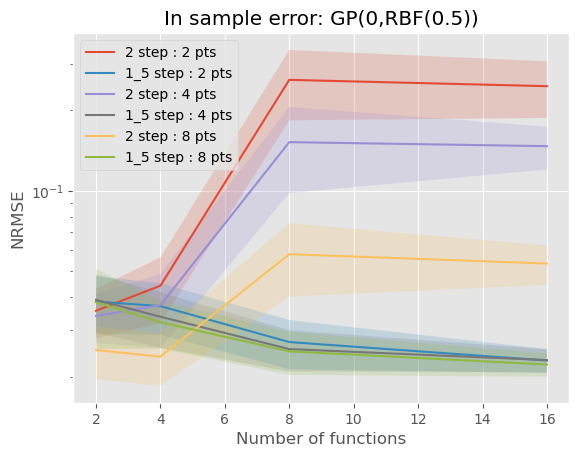

In [9]:
# In sample plot
plt.title('In sample error: GP(0,RBF(0.5))')
ms = NUM_FUN_LIST
OBS_PTS_LIST = [2,4,8]
for obs_pt in OBS_PTS_LIST:
    # 1_5 method
    mean_i_smpl_1_5 = jnp.array([jnp.mean(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['i_smpl'])])
    sd_i_smpl_1_5 = jnp.array([jnp.std(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['i_smpl'])])
    # 2 method
    mean_i_smpl_2 = jnp.array([jnp.mean(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['i_smpl'])])
    sd_i_smpl_2 = jnp.array([jnp.std(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['i_smpl'])])
    # Plot 2 method
    plt.plot(ms, mean_i_smpl_2, label = f'2 step : {obs_pt} pts')
    plt.fill_between(ms, mean_i_smpl_2 - sd_i_smpl_2, mean_i_smpl_2 + sd_i_smpl_2, alpha=.2)
    plt.yscale('log')
    # Plot 1_5 method
    plt.plot(ms, mean_i_smpl_1_5, label = f'1_5 step : {obs_pt} pts')
    plt.fill_between(ms, mean_i_smpl_1_5 - sd_i_smpl_1_5, mean_i_smpl_1_5 + sd_i_smpl_1_5, alpha=.2)
    plt.yscale('log')
plt.ylabel('NRMSE')
plt.xlabel('Number of functions')
plt.legend()
plt.show()

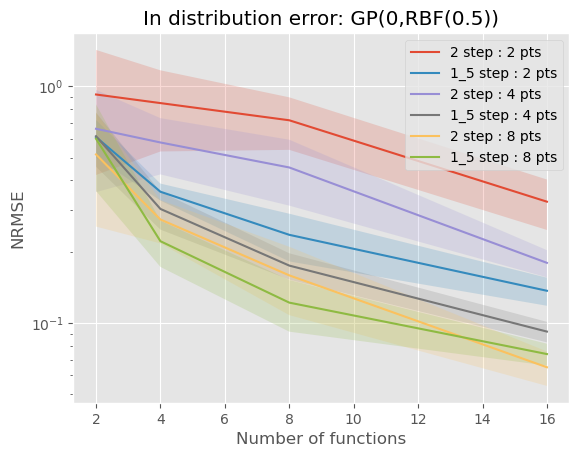

In [10]:
# In distribution plot
plt.title('In distribution error: GP(0,RBF(0.5))')
ms = NUM_FUN_LIST
OBS_PTS_LIST = [2,4,8]
for obs_pt in OBS_PTS_LIST:
    # 1_5 method
    mean_i_dis_1_5 = jnp.array([jnp.mean(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['i_dis'])])
    sd_i_dis_1_5 = jnp.array([jnp.std(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['i_dis'])])
    # 2 method
    mean_i_dis_2 = jnp.array([jnp.mean(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['i_dis'])])
    sd_i_dis_2 = jnp.array([jnp.std(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['i_dis'])])
    # Plot 2 method
    plt.plot(ms, mean_i_dis_2, label = f'2 step : {obs_pt} pts')
    plt.fill_between(ms, mean_i_dis_2 - sd_i_dis_2, mean_i_dis_2 + sd_i_dis_2, alpha=.2)
    plt.yscale('log')
    # Plot 1_5 method
    plt.plot(ms, mean_i_dis_1_5, label = f'1_5 step : {obs_pt} pts')
    plt.fill_between(ms, mean_i_dis_1_5 - sd_i_dis_1_5, mean_i_dis_1_5 + sd_i_dis_1_5, alpha=.2)
    plt.yscale('log')
plt.ylabel('NRMSE')
plt.xlabel('Number of functions')
plt.legend()
plt.show()

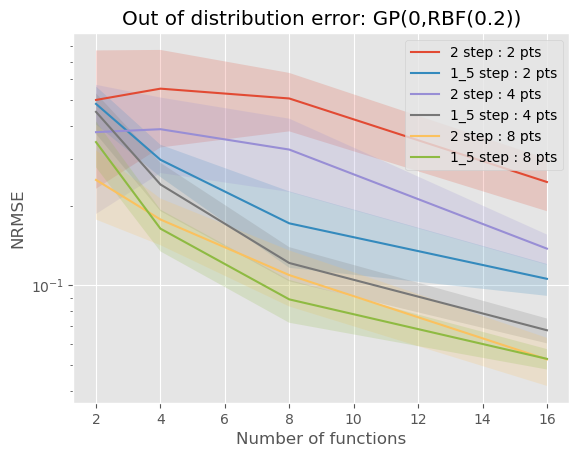

In [11]:
# Out of distribution
plt.title('Out of distribution error: GP(0,RBF(0.2))')
ms = NUM_FUN_LIST
OBS_PTS_LIST = [2,4,8]
for obs_pt in OBS_PTS_LIST:
    # 1_5 method
    mean_o_dis_1_5 = jnp.array([jnp.mean(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['o_dis'])])
    sd_o_dis_1_5 = jnp.array([jnp.std(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['o_dis'])])
    # 2 method
    mean_o_dis_2 = jnp.array([jnp.mean(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['o_dis'])])
    sd_o_dis_2 = jnp.array([jnp.std(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['o_dis'])])
    # Plot 2 method
    plt.plot(ms, mean_o_dis_2, label = f'2 step : {obs_pt} pts')
    plt.fill_between(ms, mean_o_dis_2 - sd_o_dis_2, mean_o_dis_2 + sd_o_dis_2, alpha=.2)
    plt.yscale('log')
    # Plot 1_5 method
    plt.plot(ms, mean_o_dis_1_5, label = f'1_5 step : {obs_pt} pts')
    plt.fill_between(ms, mean_o_dis_1_5 - sd_o_dis_1_5, mean_o_dis_1_5 + sd_o_dis_1_5, alpha=.2)
    plt.yscale('log')
plt.ylabel('NRMSE')
plt.xlabel('Number of functions')
plt.legend()
plt.show()